In [1]:
#no need to refresh kernel when changes are made to the helper scripts
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import os
import sys
from IPython.display import display,FileLink, Markdown, HTML, Image

cwd = os.path.dirname(os.getcwd()) #add the cwd so that python scripts can be imported.
if cwd not in sys.path:
    sys.path.insert(0, cwd)

#to save in the same directory as the notebook, change to resource_path="".

# print(project_root)
# print(resource_path)

In [4]:
#parameters
gse = "GSE247175"
project_root = cwd

In [5]:
# Parameters
gse = "GSE247883"
project_root = "/home/ajy20/geo2reports"


In [6]:
from pathlib import Path
resource_path = os.path.join(project_root, "output", gse)
Path(resource_path).mkdir(parents=True, exist_ok=True)

In [7]:
import contextlib

@contextlib.contextmanager
def suppress_output(stdout=True, stderr=True, dest='/dev/null'):
    ''' Usage:
    with suppress_output():
        print('hi')
    '''
    dev_null = open(dest, 'a')
    if stdout:
        _stdout = sys.stdout
        sys.stdout = dev_null
    if stderr:
        _stderr = sys.stderr
        sys.stderr = dev_null
    try:
        yield
    finally:
        if stdout:
            sys.stdout = _stdout
        if stderr:
            sys.stderr = _stderr

In [8]:
from Bio import Entrez
from dotenv import load_dotenv

load_dotenv()

os.environ['ENTREZ_EMAIL'] = os.getenv('ENTREZ_EMAIL')

Entrez.email = os.environ['ENTREZ_EMAIL']

id_handle = Entrez.esearch(db="gds", term=f"{gse}[Accession]", retmax=1)
id_record = Entrez.read(id_handle)
gds_id = id_record["IdList"][0]

In [9]:
stream = Entrez.esummary(db='gds', id=gds_id)
record = Entrez.read(stream)

In [10]:
map_species = {
    "homo sapiens": "human",
    "mus musculus": "mouse"
}

In [11]:
species = map_species[record[0]['taxon'].lower()]

In [12]:
if len(record[0]['PubMedIds'])==0: #discard studies with no pubmed citation
    raise ValueError("No PubMed citation found for this study.")

In [13]:
pmid = int(record[0]['PubMedIds'][0])

In [14]:
if len(record[0]['Samples']) not in range(6, 25): #discard studies that dont have 6-24 samples
    raise ValueError("Number of samples need to be within 6-24.")

In [15]:
def fetch_pubmed_metadata(pmid):
    handle = Entrez.efetch(db="pubmed", id=pmid, retmode="xml")
    records = Entrez.read(handle)
    article = records['PubmedArticle'][0]['MedlineCitation']['Article']

    title = article['ArticleTitle']
    journal = article['Journal']['Title']
    journal_abbr = article['Journal']['ISOAbbreviation']
    year = article['Journal']['JournalIssue']['PubDate'].get('Year', '')
    volume = article['Journal']['JournalIssue'].get('Volume', '')
    issue = article['Journal']['JournalIssue'].get('Issue', '')
    pages = article.get('Pagination', {}).get('MedlinePgn', '')
    authors = article.get('AuthorList', [])

    # def format_author(author):
    #     initials = ''.join(author.get('Initials', ''))
    #     return f"{author['LastName']} {initials}"

    def format_author(author):
        initials = '. '.join(author.get('Initials', '')) + '.'
        return f"{author['LastName']}, {initials}"


    authors = [format_author(a) for a in authors]

    return {
        "title": title,
        "journal": journal_abbr,
        "year": year,
        "volume": volume,
        "issue": issue,
        "pages": pages,
        "authors": authors
    }

In [16]:
pmdict = fetch_pubmed_metadata(pmid)

In [17]:
def format_apa_citation(metadata, pmid=None):
    authors = metadata['authors']

    if len(authors) <= 20:
        if len(authors) > 1:
            author_str = ', '.join(authors[:-1]) + ', & ' + authors[-1]
        else:
            author_str = authors[0]
    else:
        author_str = ', '.join(authors[:19]) + ', ... ' + authors[-1]

    citation = (
        f"{author_str} ({metadata['year']}). {metadata['title']}. "
        f"*{metadata['journal']}*, {metadata['volume']}({metadata['issue']}), {metadata['pages']}."
    )

    if metadata.get('doi'):
        citation += f" https://doi.org/{metadata['doi']}"
    elif pmid:
        citation += f" PMID: {pmid}"

    return citation


In [18]:
citation = format_apa_citation(pmdict)

In [19]:
display(Markdown(f"# **Reanalysis of \"{pmdict['title']}\" by {pmdict['authors'][0]} et al., {pmdict['journal']}, {pmdict['year']}**"))

# **Reanalysis of "Long non‑coding RNA lung cancer‑associated transcript 1 regulates ferroptosis via microRNA‑34a‑5p‑mediated GTP cyclohydrolase 1 downregulation in lung cancer cells." by Tai, F. et al., Int J Oncol, 2024**

In [20]:
link = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={gse}"
display(Markdown(f"{citation}"))
HTML(f'<a href="{link}" target="_blank">Visit GEO accession page</a>')

Tai, F., Zhai, R., Ding, K., Zhang, Y., Yang, H., Li, H., Wang, Q., Cao, Z., Ge, C., Fu, H., Xiao, F., & Zheng, X. (2024). Long non‑coding RNA lung cancer‑associated transcript 1 regulates ferroptosis via microRNA‑34a‑5p‑mediated GTP cyclohydrolase 1 downregulation in lung cancer cells.. *Int J Oncol*, 64(6), .

In [21]:
from google import genai

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

client = genai.Client(api_key=os.environ["GOOGLE_API_KEY"])
#print(os.environ["GOOGLE_API_KEY"])
prompt = f'''
  You are an expert academic writer. Your task is to reformat the provided research information into a concise abstract around 250 words following this exact template:

  "In this study, <FIRST AUTHOR> et al. [1] profiled <CELLS AND CONDITIONS> to further our understanding of <TOPIC>. The reanalysis of this dataset include <FILL IN>"

  Here is the contextual information:
  Author: {pmdict['authors']}
  Title: {pmdict['title']}
  Summary: {record[0]['summary']}

  In the reanalysis explanation, use the following information: the reanalysis is a full RNA-seq analysis pipeline that consists of: UMAP[2], PCA[3], t-SNE[4] plots of the samples; clustergram heatmap; differential gene expression analysis
  for each pair of control and perturbation samples; Enrichment analysis for each gene signature using Enrichr [5, 6, 7]; Transcription factor analysis of gene signatures
  using ChEA3 [8] ; Reverser and mimicker drug match analysis using L2S2 [9] and DRUG-seqr [10], both FDA and non-FDA approved. Results are provided as tables in addition to bar charts.

  Please write the reanalysis as a complete paragraph with smoothly transitioning sentences. Use consistent, present tense.
  Do not omit or change the ordering of the reference numbers.
  Do not change the reference and insert it, in parentheses, where indicated. 

  Now, generate the abstract strictly following the template. Do not include any other text or introductory/concluding remarks.
'''

response = client.models.generate_content(
    model="gemini-2.0-flash", contents=prompt
)
#print(response.text)

## **Abstract**

In [22]:
display(Markdown(f"{response.text}\n*This abstract was generated with the assistance of Gemini 2.0 Flash.*"))

In this study, Tai et al. [1] profiled A549 cells treated with DMSO, RSL3 alone, or co-treated with Fer-1 for 24h to further our understanding of ferroptosis-associated genes in non-small cell lung cancer (NSCLC). The reanalysis of this dataset include a comprehensive RNA-seq analysis pipeline which begins with dimensionality reduction using UMAP [2], PCA [3], and t-SNE [4] to visualize sample distributions. This is followed by a clustergram heatmap to show expression patterns across samples. Differential gene expression analysis is performed for each control and perturbation pair, and the resulting gene signatures are then subjected to enrichment analysis using Enrichr [5, 6, 7]. Furthermore, transcription factor analysis of the gene signatures is conducted using ChEA3 [8]. Finally, the analysis incorporates drug match prediction using L2S2 [9] and DRUG-seqr [10] to identify both FDA-approved and non-FDA-approved compounds that can reverse or mimic the observed gene expression changes. Results are presented as tables and bar charts to facilitate interpretation.

*This abstract was generated with the assistance of Gemini 2.0 Flash.*

## **Methods**

*RNA-seq alignment*

Gene count matrices were obtained from ARCHS4 [11], which preprocessed the raw FASTQ data using the Kallisto [12] and STAR [] pseudoalignment algorithm.

*Gene matrix processing* 

The raw gene matrix was filtered to remove genes that do not have an average of 3 reads across the samples. It was then quantile, log2, and z-score normalized. A regex-based function was used to infer whether individual samples belong to a “control” or a “perturbation” group by processing the metadata associated with each sample. 

*Dimensionality Reduction Visualization*

Three types of dimensionality reduction techniques were applied on the processed expression matrices: UMAP[2], PCA[3], and t-SNE[4]. UMAP was calculated by the UMAP Python package and PCA and t-SNE were calculated using the Scikit-Learn Python library. The samples were then represented on 2D scatterplots.

*Clustergram Heatmap*

As a preliminary step, the top 1000 genes exhibiting most variability were selected. Using this new set, clustergram heatmaps were generated. Two versions of the clustergram exist: an interactive one generated by Clustergrammer [13] and a publication-ready alternative.

*Differentially Expressed Genes Calculation and Volcano Plot*

Differentially expressed genes between the control and perturbation samples were calculated using Limma Voom [14]. The logFC and -log10p values of each gene were visualized as a volcano scatterplot. Upregulated and downregulated genes were selected according to this criteria: p < 0.05 and |logFC| > 1.0.

*Enrichr Enrichment Analysis*

The upregulated and down-regulated sets were separately submitted to Enrichr [5, 6, 7]. These sets were compared against libraries from ChEA [8], ARCHS4 [12], Reactome Pathways [15], MGI Mammalian Phenotype [16], Gene Ontology Biological Processes [17], GWAS Catalog [18], KEGG [19, 20, 21], and WikiPathways [22]. The top matched terms from each library and their respective -log10p values were visualized as barplots.

*Chea3 Transcription Factor Analysis*

The upregulated and down-regulated sets were separately submitted to Chea3 [8]. These sets were compared against the libraries ARCHS4 Coexpression [12], GTEx Coexpression [23], Enrichr [5, 6, 7], ENCODE ChIP-seq [24, 25], ReMap ChIP-seq [26], and Literature-mined ChIP-seq. The top matched TFs were ranked according to their average score across each library and represented as barplots.

*L2S2 and Drug-seqr drug analysis*

The top 500 up and downregulated sets were submitted simulataneously to identify reverser and mimicker molecules, both FDA and non-FDA approved, from the L2S2 [9] and Drug-seqr [10] databases. The top matched molecules were compiled into tables and visualized as barplots. 


In [23]:
%%capture

import json
from datetime import datetime

#write a json file as a catalog list.
metadata_path = Path(os.path.join(project_root, "public", "metadata.json"))

# 1. Load existing metadata (or create empty if file doesn't exist)
if metadata_path.exists():
    with open(metadata_path, "r") as f:
        metadata = json.load(f)
else:
    metadata = {}


entry = {
    "GSE": gse, 
    "author": ", ".join(pmdict['authors']),
    "year": pmdict['year'],
    "species": species,
    "title": pmdict['title'],
    "pmid": pmid,
    "num_samps": len(record[0]['Samples']),
    "samples": ", ".join(sorted([w['Accession'] for w in record[0]['Samples']])),
    "citation": citation,
    "notebook_path": f"{resource_path}/{gse}.ipynb",
    #"report_path": f"{resource_path}/{gse}.html",
    "timestamp": datetime.now().isoformat()
}

# 3. Add entry only if it doesn't already exist
if gse not in metadata:
    metadata[gse] = entry
    print(f"[INFO] Added metadata for {gse}")
else:
    print(f"[INFO] {gse} already exists in metadata. Skipping update.")

# 4. Write updated metadata back to file
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)


In [24]:
tab_num = 1
fig_num = 1
save_formats = ['png', 'svg', 'jpeg']

In [25]:
import archs4py as a4
#file_path = a4.download.counts("human", path="", version="latest") #comment out if the file is already downloaded
file = os.path.join("/home/ajy20/projects/8--auto-playbook-geo-reports", "human_gene_v2.latest.h5") 

In [26]:
metadata = a4.meta.series(file, gse)

In [27]:
%%capture
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
words_to_remove = ['experiement', 'tissue', 'type', 'batch', 'treatment', 'experiment', 'patient', 'batch', '1', '2', '3', '4', '5', '6', '7', '8', '9']
stopwords_plus = set(stopwords.words('english') + (words_to_remove))
pattern = r'[-,_.:]'


In [28]:
terms_to_remove = ["cell line", "cell type", "genotype", "treatment"]


pattern1 = r"\b(" + "|".join(map(re.escape, terms_to_remove)) + r")\b"

metadata["cleaned_characteristics"] = metadata["characteristics_ch1"].str.replace(
    pattern1, 
    "", 
    flags=re.IGNORECASE, 
    regex=True
).str.replace(r"\s+", " ", regex=True).str.strip()

metadata['cleaned_characteristics'] = metadata['cleaned_characteristics'].apply(lambda x: re.sub(pattern, " ", x).strip().lower())
metadata['cleaned_characteristics'] = metadata['cleaned_characteristics'].apply(
    lambda text: " ".join([word for word in text.split() if word not in stopwords_plus])
)

In [29]:
metadata['clean_title'] = metadata['title'].apply(lambda x: re.sub('[0-9]+', '', x))
metadata['clean_title'] = metadata['clean_title'].apply(lambda x: re.sub(pattern, " ", x).strip().lower())
metadata['clean_title'] = metadata['clean_title'].apply(
    lambda text: " ".join([word for word in text.split() if word not in stopwords_plus])
)

#metadata

In [30]:
groups = metadata.groupby(by='clean_title', level=None)

In [31]:
ctrl_words = set(['wt', 'wildtype', 'control', 'cntrl', 'ctrl', 'uninfected', 'normal', 'untreated', 'unstimulated', 'shctrl', 'ctl', 'healthy', 'sictrl', 'sicontrol', 'ctr', 'wild', 'dmso', 'vehicle', 'naive'])

In [32]:
groupings = {}
for label, group in groups:
    if len(group) not in {3, 4}: #enforce 3-4 samples per group
        raise ValueError("Study does not have 3-4 samples per group")
    
    groupings[label] = group['geo_accession'].tolist()

# print(groupings)

In [33]:
title_conditions = list(groupings.keys())
title_ctrl = []
for c in title_conditions:
    if len(set(c.split()).intersection(ctrl_words)) > 0:
        title_ctrl.append(c)
        
# print(title_conditions)
# print(title_ctrl)    

In [34]:
og_labels = {}
labled_groupings = {}

for label in groupings:
    samps = groupings[label]
    data = list(map(lambda s: s.lower(), metadata.loc[samps]['characteristics_ch1'].values))
    data_clean = []
    for d in data:
        data_clean.append(set(filter(lambda w: w not in stopwords_plus, re.sub(pattern, ' ', d).split())))
    condition = set(data_clean[0])
    for s in data_clean[1:]:
        condition.intersection_update(s)
    condition = ' '.join(list(condition))
    labled_groupings[condition] = samps
    og_labels[condition] = label

ch1_ctrl = []
ch1_conditions = list(labled_groupings.keys())

for condition in labled_groupings:
    split_conditions = condition.lower().split()
    if len(set(split_conditions).intersection(ctrl_words)) > 0:
        ch1_ctrl.append(condition)

# print(og_labels)
# print(ch1_conditions)
# print(ch1_ctrl)

In [35]:
#must have 1-2 controls. Must have perturbation groups as well (not all groups can be controls).
def check_eligibility(conditions, ctrl_conditions):
    if len(ctrl_conditions) not in range(1, 3) or len(ctrl_conditions) == len(conditions):
        return False
    else:
        return True

In [36]:
ch1_eligibility = check_eligibility(ch1_conditions, ch1_ctrl)
title_eligibility = check_eligibility(title_conditions, title_ctrl)
#print(ch1_eligibility)
#rint(title_eligibility)

In [37]:
def compare_groups(title_ctrl, ch1_ctrl, og_labels):
    #convert ch1 condition to corresponding title condition, check if their respective sample sets are equal
    for c in ch1_ctrl:
        ch1_corresponding = og_labels[c]
        if set(groupings[ch1_corresponding]) != set(labled_groupings[c]):
            return False

    return True

In [38]:
if ch1_eligibility and title_eligibility:
    if compare_groups(title_ctrl, ch1_ctrl, og_labels):
        ctrl_conditions = title_ctrl
        conditions = title_conditions
    else:
        raise Exception("Group Assignment Failed")
    
elif ch1_eligibility ^ title_eligibility:
    if ch1_eligibility:
        ctrl_conditions = ch1_ctrl
        conditions = ch1_conditions
        groupings = labled_groupings
    else:
        ctrl_conditions = title_ctrl
        conditions = title_conditions
else:
    raise Exception("Group Assignment Failed")

# print(ctrl_conditions)
# print(conditions)

In [39]:
%%capture
gene_matrix = a4.data.series(file, gse) #raw counts
gene_matrix.to_csv(os.path.join(resource_path, "raw_counts.csv"))

In [40]:
gene_matrix.head(5)

GSM7902660  GSM7902661  GSM7902662  GSM7902663  GSM7902664  \
TSPAN6           507         530         530         581         536   
TNMD               0           0           0           0           0   
DPM1             445         441         458         434         432   
SCYL3            221         230         232         261         238   
C1ORF112         554         558         634         483         580   

          GSM7902665  GSM7902666  GSM7902667  GSM7902668  
TSPAN6           517         566         579         619  
TNMD               0           0           0           0  
DPM1             383         459         462         466  
SCYL3            226         238         297         245  
C1ORF112         519         616         632         633

In [41]:
display(Markdown(f"**table {tab_num}**: This is a preview of the first 5 rows of the raw RNA-seq expression matrix from {gse}."))
tab_num +=1
display(FileLink(os.path.join(resource_path, "raw_counts.csv"), result_html_prefix="Download raw counts: "))

**table 1**: This is a preview of the first 5 rows of the raw RNA-seq expression matrix from GSE247883.

/home/ajy20/geo2reports/output/GSE247883/raw_counts.csv

In [42]:
# Remove genes with all-zero counts
filtered_matrix = gene_matrix.loc[gene_matrix.sum(axis=1) > 0, :]

# Then filter out low average expression
filtered_matrix = filtered_matrix.loc[filtered_matrix.mean(axis=1) >= 3, :]

In [43]:
from maayanlab_bioinformatics.normalization.log import log2_normalize
from maayanlab_bioinformatics.normalization.zscore import zscore_normalize 
from maayanlab_bioinformatics.normalization.quantile_legacy import quantile_normalize

def normalize(gene_counts):
    norm_exp = quantile_normalize(gene_counts)
    norm_exp = log2_normalize(norm_exp)
    norm_exp = zscore_normalize(norm_exp)
    return norm_exp


In [44]:
%%capture
# from python_scripts.matrix import normalize
norm_matrix = normalize(filtered_matrix) #normalize the matrix for dim reduction and clustergram

In [45]:
def annotate_matrix(expr_df, groupings, ctrl_conditions):
    sampdict = {}
    for group in groupings.keys():
        samps = groupings[group]
        for samp in samps:
            if group in ctrl_conditions:
                sampdict[samp] = "control"
            else:
                sampdict[samp] = "perturbation"
    
    annotat = pd.DataFrame.from_dict(sampdict, orient='index', columns=['group'])
    anndict = {
        'count': expr_df,
        'annotations': annotat
    }
    return anndict

In [46]:
annotated_norm_matrix = annotate_matrix(norm_matrix, groupings, ctrl_conditions)

#print(annotated_norm_matrix['annotations'])

In [47]:
annotated_matrix = annotate_matrix(filtered_matrix.astype('int64'), groupings, ctrl_conditions) #filtered but not normalized

# **Results**

In [48]:
save_html = True #if true, render plotly graphs as html and embed with ipython. else, use fig.show()
use_fig_plot = False #if true, render matplotlib graphs using show(), else it will render the saved pngs.

## **Dimensionality Reduction**

### **UMAP**

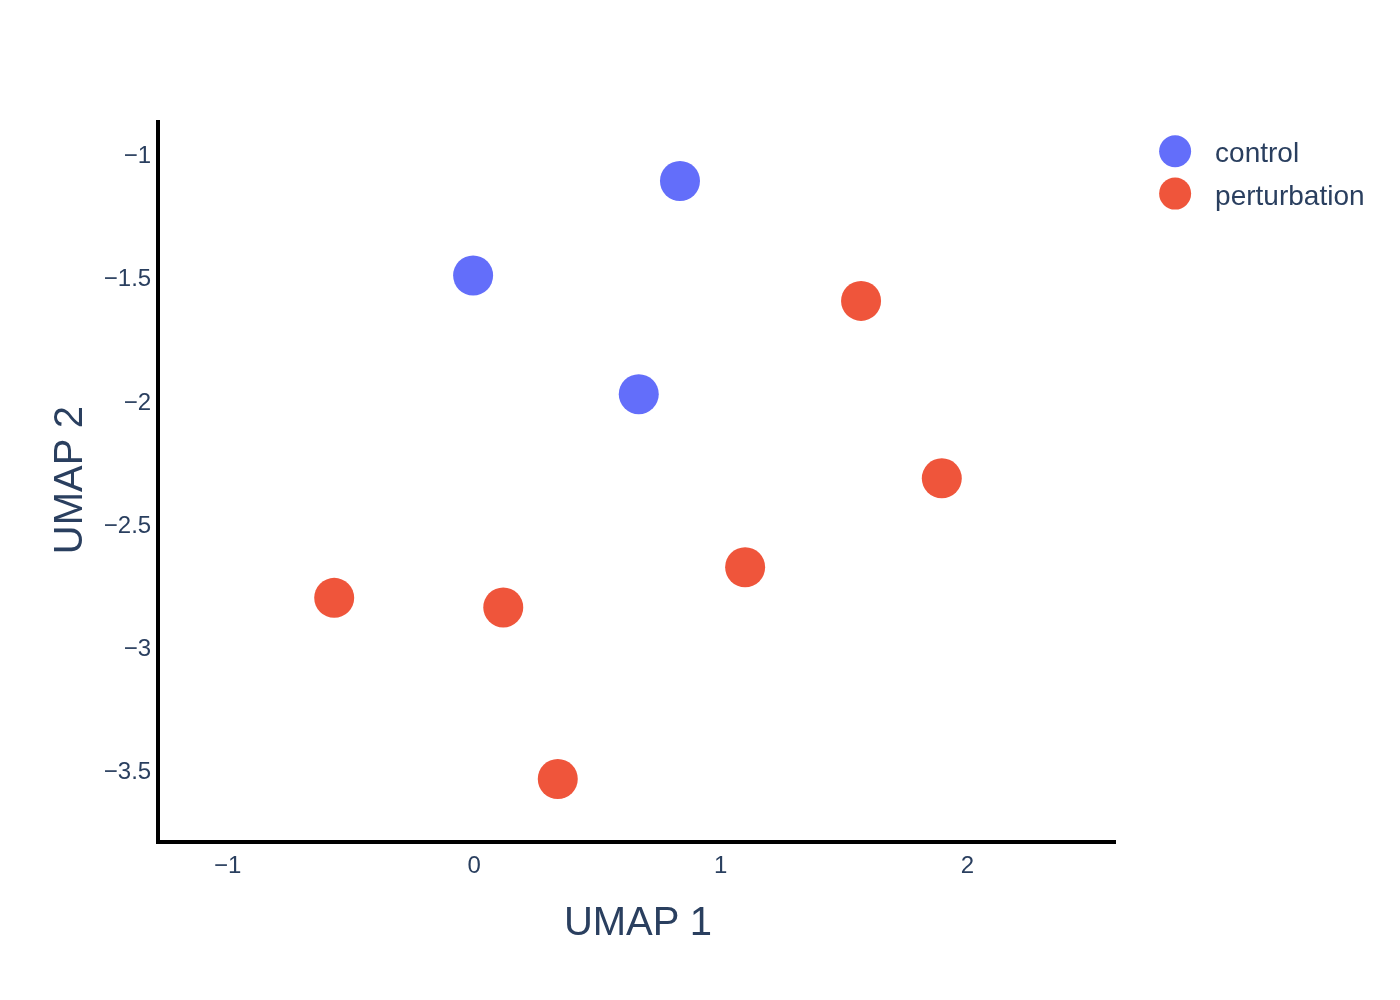

**Figure 1**: This figure displays a 2D scatter plot of a UMAP decomposition of the sample data. Each point represents an individual sample, colored by its experimental group.

/home/ajy20/geo2reports/output/GSE247883/umap.png

/home/ajy20/geo2reports/output/GSE247883/umap.svg

/home/ajy20/geo2reports/output/GSE247883/umap.jpeg

In [49]:
import python_scripts.visualizations as vis

vis.plot(annotated_norm_matrix['count'], annotated_norm_matrix['annotations'], n_components=2, save_formats=save_formats, decomp="umap", save_html=save_html, save_path=resource_path)
#if save_html: display(HTML(os.path.join(resource_path, "umap.html")))
display(Image(os.path.join(resource_path, "umap.png"), width=700))
display(Markdown(f"**Figure {fig_num}**: This figure displays a 2D scatter plot of a UMAP decomposition of the sample data. Each point represents an individual sample, colored by its experimental group."))
fig_num+=1

for fmt in save_formats:
    display(FileLink(os.path.join(resource_path, f"umap.{fmt}"), result_html_prefix=f"Download UMAP figure as {fmt}: "))


### **PCA**

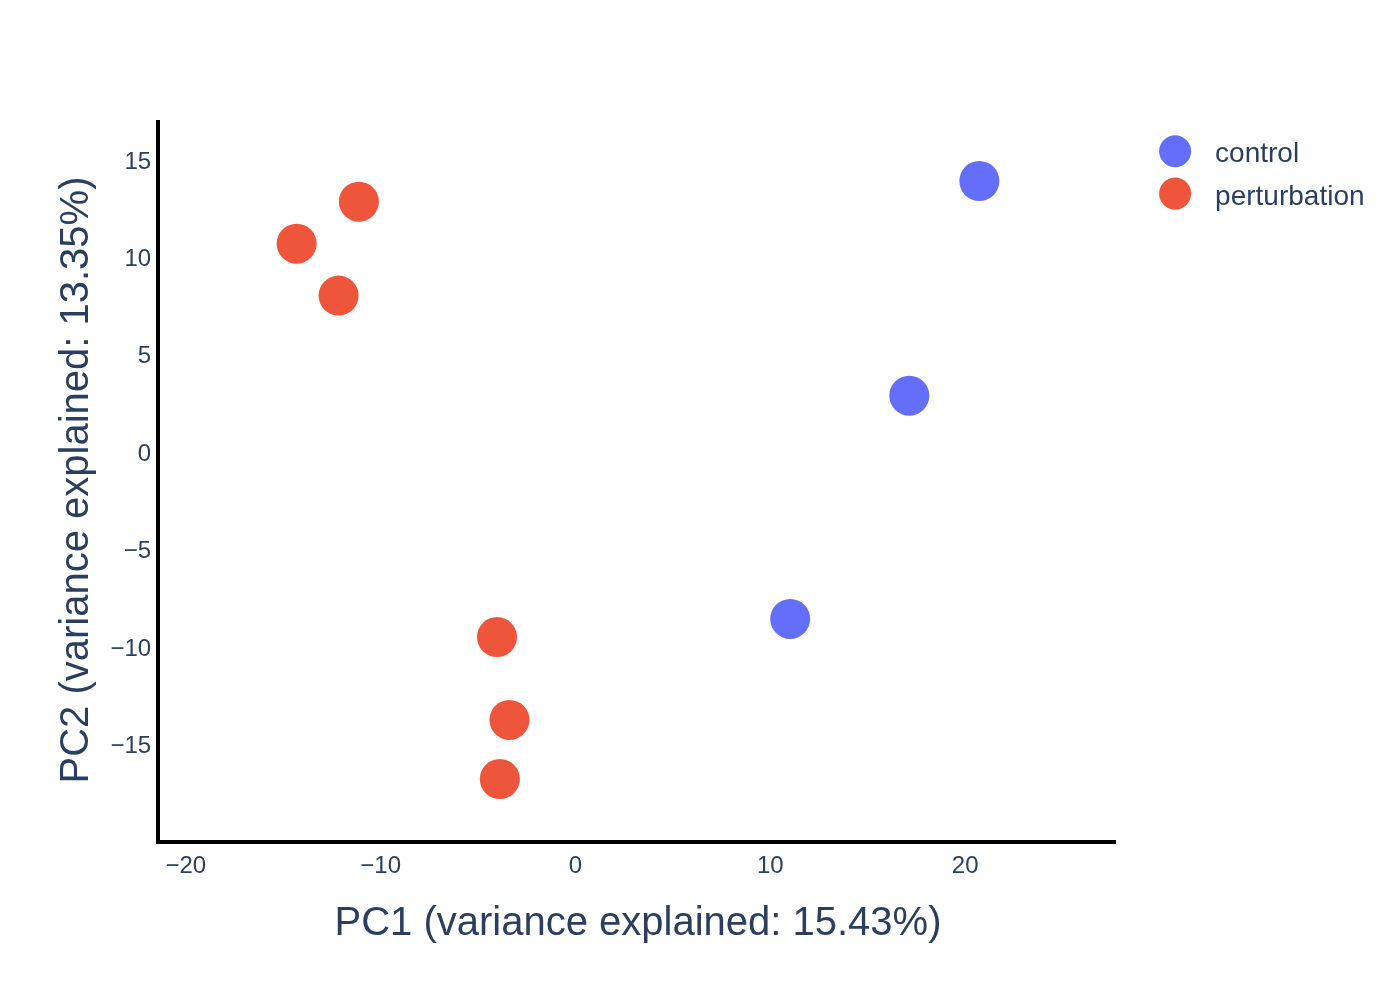

**Figure 2**: This figure displays a 2D scatter plot of a PCA decomposition of the sample data. Each point represents an individual sample, colored by its experimental group.

/home/ajy20/geo2reports/output/GSE247883/pca.png

/home/ajy20/geo2reports/output/GSE247883/pca.svg

/home/ajy20/geo2reports/output/GSE247883/pca.jpeg

In [50]:
vis.plot(annotated_norm_matrix['count'], annotated_norm_matrix['annotations'], n_components=2, save_formats=save_formats, decomp="pca", save_html=save_html, save_path=resource_path)
#if save_html: display(HTML(os.path.join(resource_path, "pca.html")))
display(Image(os.path.join(resource_path, "pca.png"), width=700))
display(Markdown(f"**Figure {fig_num}**: This figure displays a 2D scatter plot of a PCA decomposition of the sample data. Each point represents an individual sample, colored by its experimental group."))
fig_num+=1

for fmt in save_formats:
    display(FileLink(os.path.join(resource_path, f"pca.{fmt}"), result_html_prefix=f"Download PCA figure as {fmt}: "))

### **t-SNE**

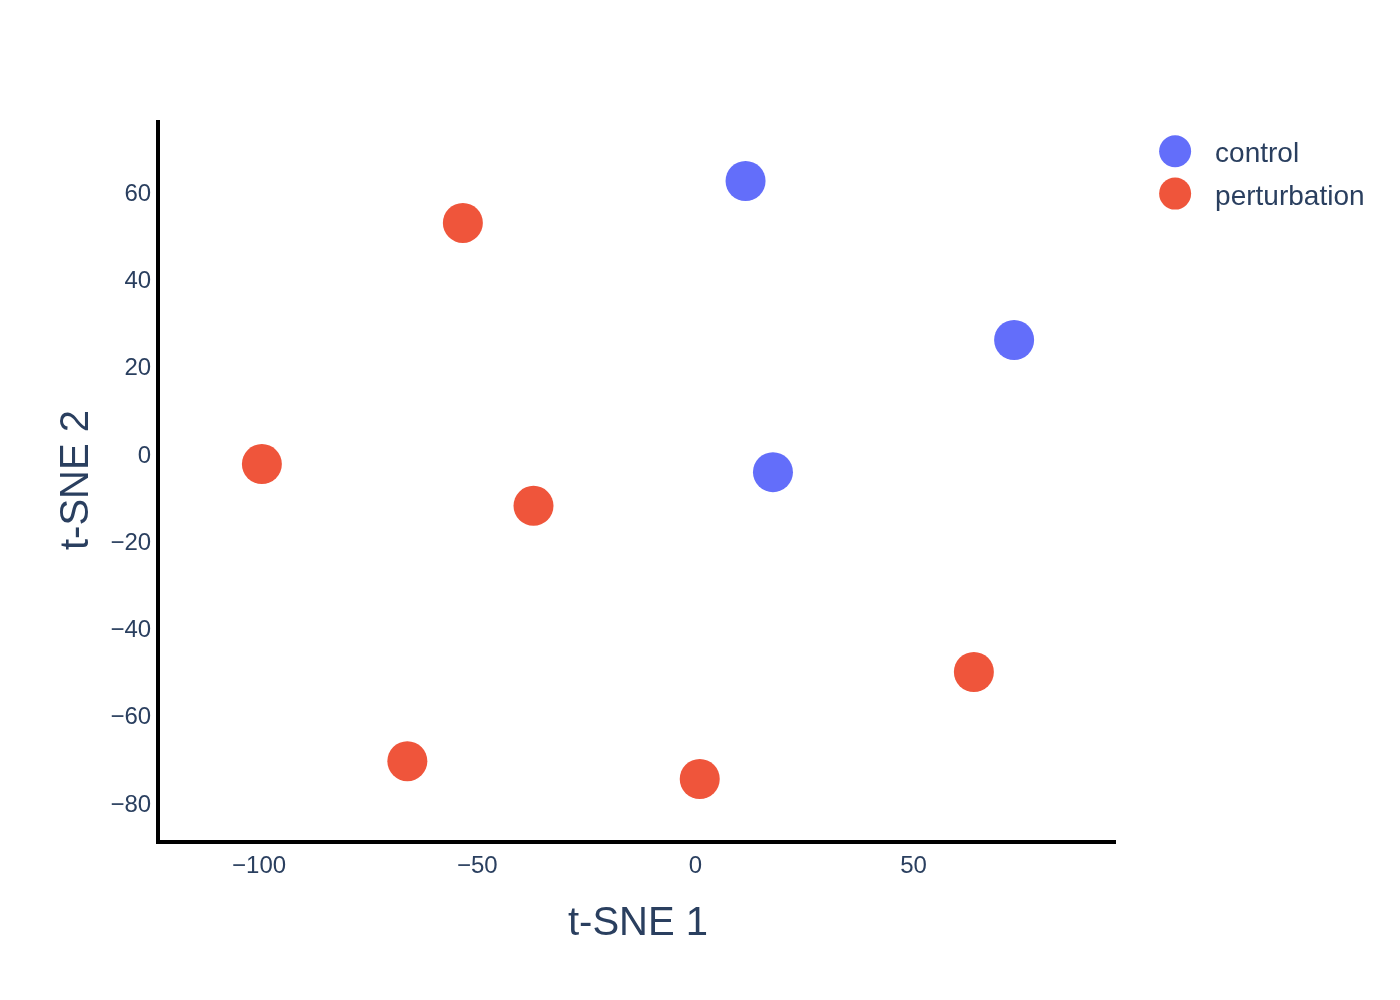

**Figure 3**: This figure displays a 2D scatter plot using a t-SNE decomposition of the sample data. Each point represents an individual sample, colored by its experimental group.

/home/ajy20/geo2reports/output/GSE247883/tsne.png

/home/ajy20/geo2reports/output/GSE247883/tsne.svg

/home/ajy20/geo2reports/output/GSE247883/tsne.jpeg

In [51]:
vis.plot(annotated_norm_matrix['count'], annotated_norm_matrix['annotations'], n_components=2, save_formats=save_formats, decomp="tsne", save_html=save_html, save_path=resource_path)
#if save_html: display(HTML(os.path.join(resource_path, "tsne.html")))
display(Image(os.path.join(resource_path, "tsne.png"), width=700))
display(Markdown(f"**Figure {fig_num}**: This figure displays a 2D scatter plot using a t-SNE decomposition of the sample data. Each point represents an individual sample, colored by its experimental group."))
fig_num+=1

for fmt in save_formats:
    display(FileLink(os.path.join(resource_path, f"tsne.{fmt}"), result_html_prefix=f"Download t-SNE figure as {fmt}: "))

## **Clustergram Heatmaps**

In [52]:
from maayanlab_bioinformatics.normalization.filter import filter_by_var
norm_t1000 = annotated_norm_matrix['count'].copy()
norm_t1000 = filter_by_var(annotated_norm_matrix['count'], top_n=1000, axis=1)
norm_t1000.columns=metadata['title'].tolist()

In [53]:
t1000_path = os.path.join(resource_path, 'expression_matrix_top1000_genes.txt')
norm_t1000.to_csv(t1000_path, sep='\t')

In [54]:
import requests, json
clustergrammer_url = 'http://amp.pharm.mssm.edu/clustergrammer/matrix_upload/'

r = requests.post(clustergrammer_url, files={'file': open(t1000_path, 'rb')})
link = r.text

In [55]:
from IPython.display import IFrame
display(IFrame(link, width="600", height="650"))
display(Markdown(f"**Figure {fig_num}**: The figure contains an interactive heatmap displaying gene expression for each sample in the RNA-seq dataset. Every row of the heatmap represents a gene, every column represents a sample, and every cell displays normalized gene expression values. The heatmap additionally features color bars beside each column which represent prior knowledge of each sample, such as the tissue of origin or experimental treatment."))
fig_num+=1

**Figure 4**: The figure contains an interactive heatmap displaying gene expression for each sample in the RNA-seq dataset. Every row of the heatmap represents a gene, every column represents a sample, and every cell displays normalized gene expression values. The heatmap additionally features color bars beside each column which represent prior knowledge of each sample, such as the tissue of origin or experimental treatment.

In [56]:
from python_scripts import visualizations as vis
clustergram = vis.plot_clustergram(norm_t1000)

In [57]:
for fmt in save_formats:
    file_name = os.path.join(resource_path, f"clustergram.{fmt}")
    clustergram.write_image(file_name, width=700, height=700)

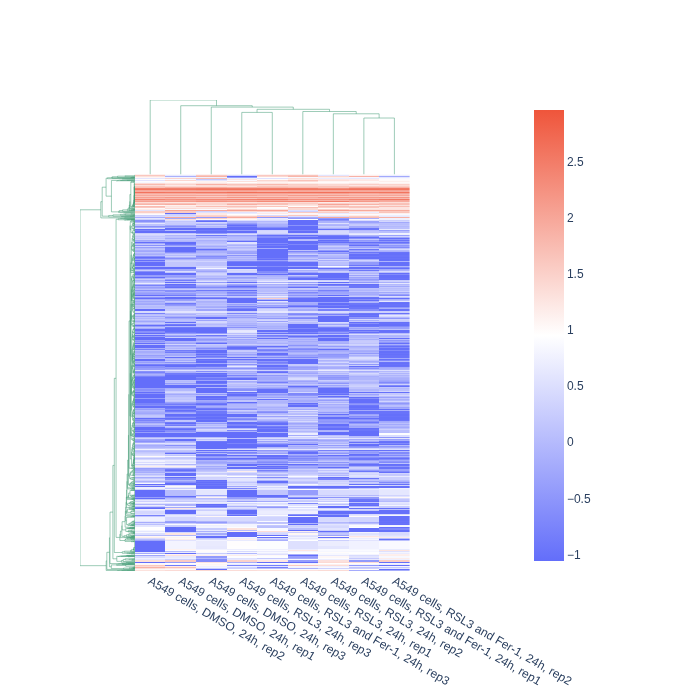

In [58]:
# if save_html:
#     cluster_path = os.path.join(resource_path, "clustergram.html")
#     clustergram.write_html(cluster_path)
#     display(HTML(cluster_path))
# else:
#     clustergram.show()

display(Image(os.path.join(resource_path, "clustergram.png"), width=700))

In [59]:
display(Markdown(f"**Figure {fig_num}**: this figure is a clustergram produced with the graphing library Plotly. It sacrifices some interactivity for a more polished look."))
fig_num+=1

for fmt in save_formats:
    file_name = os.path.join(resource_path, f"clustergram.{fmt}")
    #clustergram.write_image(file_name, width=600, height=600)
    display(FileLink(file_name, result_html_prefix=f"Download as {fmt}: "))

**Figure 5**: this figure is a clustergram produced with the graphing library Plotly. It sacrifices some interactivity for a more polished look.

/home/ajy20/geo2reports/output/GSE247883/clustergram.png

/home/ajy20/geo2reports/output/GSE247883/clustergram.svg

/home/ajy20/geo2reports/output/GSE247883/clustergram.jpeg

## **Differentially Expressed Genes Calculation and Volcano Plots**

In [60]:
from maayanlab_bioinformatics.dge.limma_voom import limma_voom_differential_expression

sig_names = []
matrix = annotated_matrix['count']
dges = {}

seen = []
for condition in ctrl_conditions:
    for condition2 in conditions:
        if condition!=condition2 and {condition, condition2} not in seen:
            seen.append({condition, condition2})
            
            sig_name = f'{condition}-vs-{condition2}.tsv'
            sig_names.append(sig_name)
            try:
                        with suppress_output():
                            dge = limma_voom_differential_expression(
                                matrix[groupings[condition]],
                                matrix[groupings[condition2]],
                                voom_design=True,
                            )
                        if not dge.empty:
                            dge['logFC'] = dge['logFC'].round(2)
                            dge['AveExpr'] = dge['AveExpr'].round(2)
                            dge['t'] = dge['t'].round(2)
                            dge['B'] = dge['B'].round(2)
                            dges[sig_name] = dge
                            dge.to_csv(os.path.join(resource_path, sig_name), sep='\t')
                        else:
                            print('Empty dge returned for', sig_name)
            except Exception as e:
                print(e)
                print('Error computing:', sig_name)

In [61]:
for sig_name in sig_names:
    dge_path = os.path.join(resource_path, sig_name)
    # table = pd.read_csv(dge_path, sep="\t")

    table = dges[sig_name]
    display(table.head(5))
    display(Markdown(f"**Table {tab_num}**: This is a preview of the first 5 rows of the differentially expressed gene table calculated by Limma Voom."))
    display(FileLink(dge_path, result_html_prefix="Download DGE table: "))
    tab_num+=1

logFC  AveExpr      t       P.Value     adj.P.Val      B
gene_symbol                                                          
GRAMD1B       0.74     8.93  33.03  5.954069e-17  9.013920e-13  29.05
SLC7A11       1.01     9.21  32.92  6.302118e-17  9.013920e-13  29.07
SQSTM1        0.59     9.05  27.02  1.745352e-15  1.328005e-11  25.81
TXNRD1        0.40    10.02  26.92  1.856959e-15  1.328005e-11  25.62
AKR1C3        2.11     5.73  23.36  1.984020e-14  1.135098e-10  20.59

**Table 2**: This is a preview of the first 5 rows of the differentially expressed gene table calculated by Limma Voom.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep.tsv

logFC  AveExpr      t       P.Value     adj.P.Val      B
gene_symbol                                                          
GRAMD1B       0.96     9.04  42.15  3.314248e-19  6.153087e-15  34.21
EGFR          0.39    11.97  41.52  4.301955e-19  6.153087e-15  33.20
TXNRD1        0.60    10.11  37.63  2.417543e-18  1.855332e-14  32.29
GPRC5A        0.84     9.50  37.32  2.786586e-18  1.855332e-14  32.21
SLC7A11       1.25     9.32  37.00  3.242907e-18  1.855332e-14  32.05

**Table 3**: This is a preview of the first 5 rows of the differentially expressed gene table calculated by Limma Voom.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep.tsv

In [62]:
threshold=1.0

**cells dmso h rep-vs-cells rsl fer h rep**

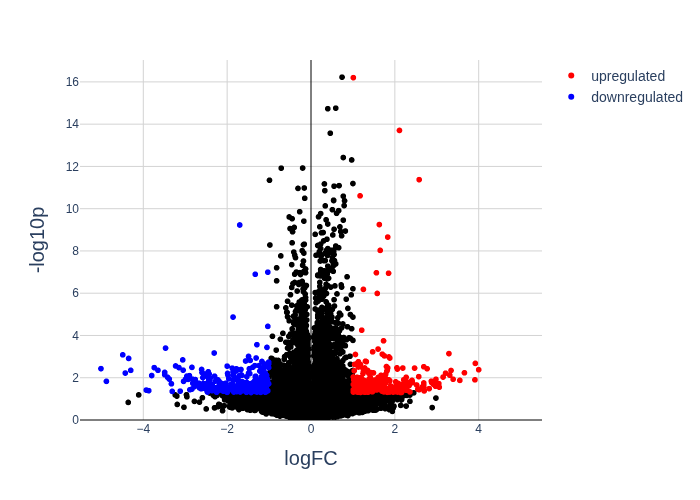

**Figure 6**: The figure contains an interactive scatter plot which displays the log2-fold changes and statistical significance of each gene calculated by performing a differential gene expression analysis for the comparison cells dmso h rep-vs-cells rsl fer h rep. Every point in the plot represents a gene. Red points indicate significantly up-regulated genes, blue points indicate down-regulated genes.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_volcano.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_volcano.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_volcano.jpeg

**cells dmso h rep-vs-cells rsl h rep**

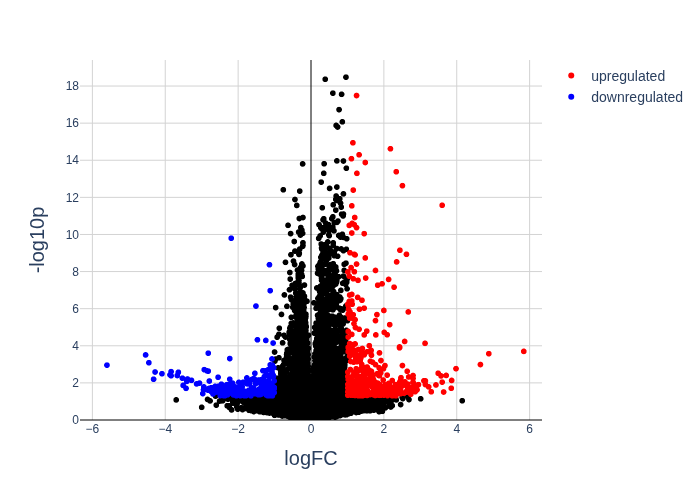

**Figure 7**: The figure contains an interactive scatter plot which displays the log2-fold changes and statistical significance of each gene calculated by performing a differential gene expression analysis for the comparison cells dmso h rep-vs-cells rsl h rep. Every point in the plot represents a gene. Red points indicate significantly up-regulated genes, blue points indicate down-regulated genes.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_volcano.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_volcano.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_volcano.jpeg

In [63]:
upreg = {}
downreg = {}

upreg_t500 = {}
downreg_t500 = {}

for sig_name in sig_names:
    #dge = pd.read_csv(os.path.join(resource_path, sig_name), sep="\t").set_index("gene_symbol")
    dge = dges[sig_name]

    sig_name = sig_name.replace(".tsv", "")

    up_genes = dge.loc[(dge['P.Value']<0.05) & (dge['logFC']>threshold), :].index.tolist() 
    down_genes = dge.loc[(dge['P.Value']<0.05) & (dge['logFC']<-threshold), :].index.tolist()

    upreg[sig_name] = up_genes
    downreg[sig_name] = down_genes

    up_genes_t500 = dge.loc[(dge['P.Value']<0.05)].sort_values(by="logFC", ascending=False)[:500].index.tolist()
    down_genes_t500 = dge.loc[(dge['P.Value']<0.05)].sort_values(by="logFC")[:500].index.tolist()

    upreg_t500[sig_name] = up_genes_t500
    downreg_t500[sig_name] = down_genes_t500

    save_name = f"{sig_name}_volcano"

    display(Markdown(f"**{sig_name}**"))
    vis.plot_volcano(dge, threshold=threshold, save_formats=save_formats, save_name = save_name, save_html=save_html, save_path=resource_path)
    #if save_html: display(HTML(os.path.join(resource_path, f"{save_name}.html")))
    display(Image(os.path.join(resource_path, f"{save_name}.png"), width=700))
    display(Markdown(f"**Figure {fig_num}**: The figure contains an interactive scatter plot which displays the log2-fold changes and statistical significance of each gene calculated by performing a differential gene expression analysis for the comparison {sig_name}. Every point in the plot represents a gene. Red points indicate significantly up-regulated genes, blue points indicate down-regulated genes."))
    fig_num+=1

    for fmt in save_formats:
        file_name=os.path.join(resource_path, f"{save_name}.{fmt}")
        display(FileLink(file_name, result_html_prefix=f"Download volcano plot as {fmt}: "))

## **Enrichr: Enrichment Analysis**

In [64]:
sig_names_clean = [name.replace('.tsv', '') for name in sig_names]

In [65]:
from python_scripts.enrichment import Enrichr_API, enrichr_figure

enrichr_libraries = ["ChEA_2022", "ARCHS4_TFs_Coexp", "Reactome_Pathways_2024", "MGI_Mammalian_Phenotype_Level_4_2024", "GO_Biological_Process_2025", "GWAS_Catalog_2023"]
if species == "human":
    enrichr_libraries.extend(["WikiPathways_2024_Human", "KEGG_2021_Human"])
elif species == "mouse":
    enrichr_libraries.extend(["WikiPathways_2024_Mouse", "KEGG_2019_Mouse"])
else:
    raise Exception("Species not supported.")

enrichr_libraries.sort()

figure_file_format = save_formats

color = "tomato"

### **Upregulated Set**

#### **cells dmso h rep-vs-cells rsl fer h rep**

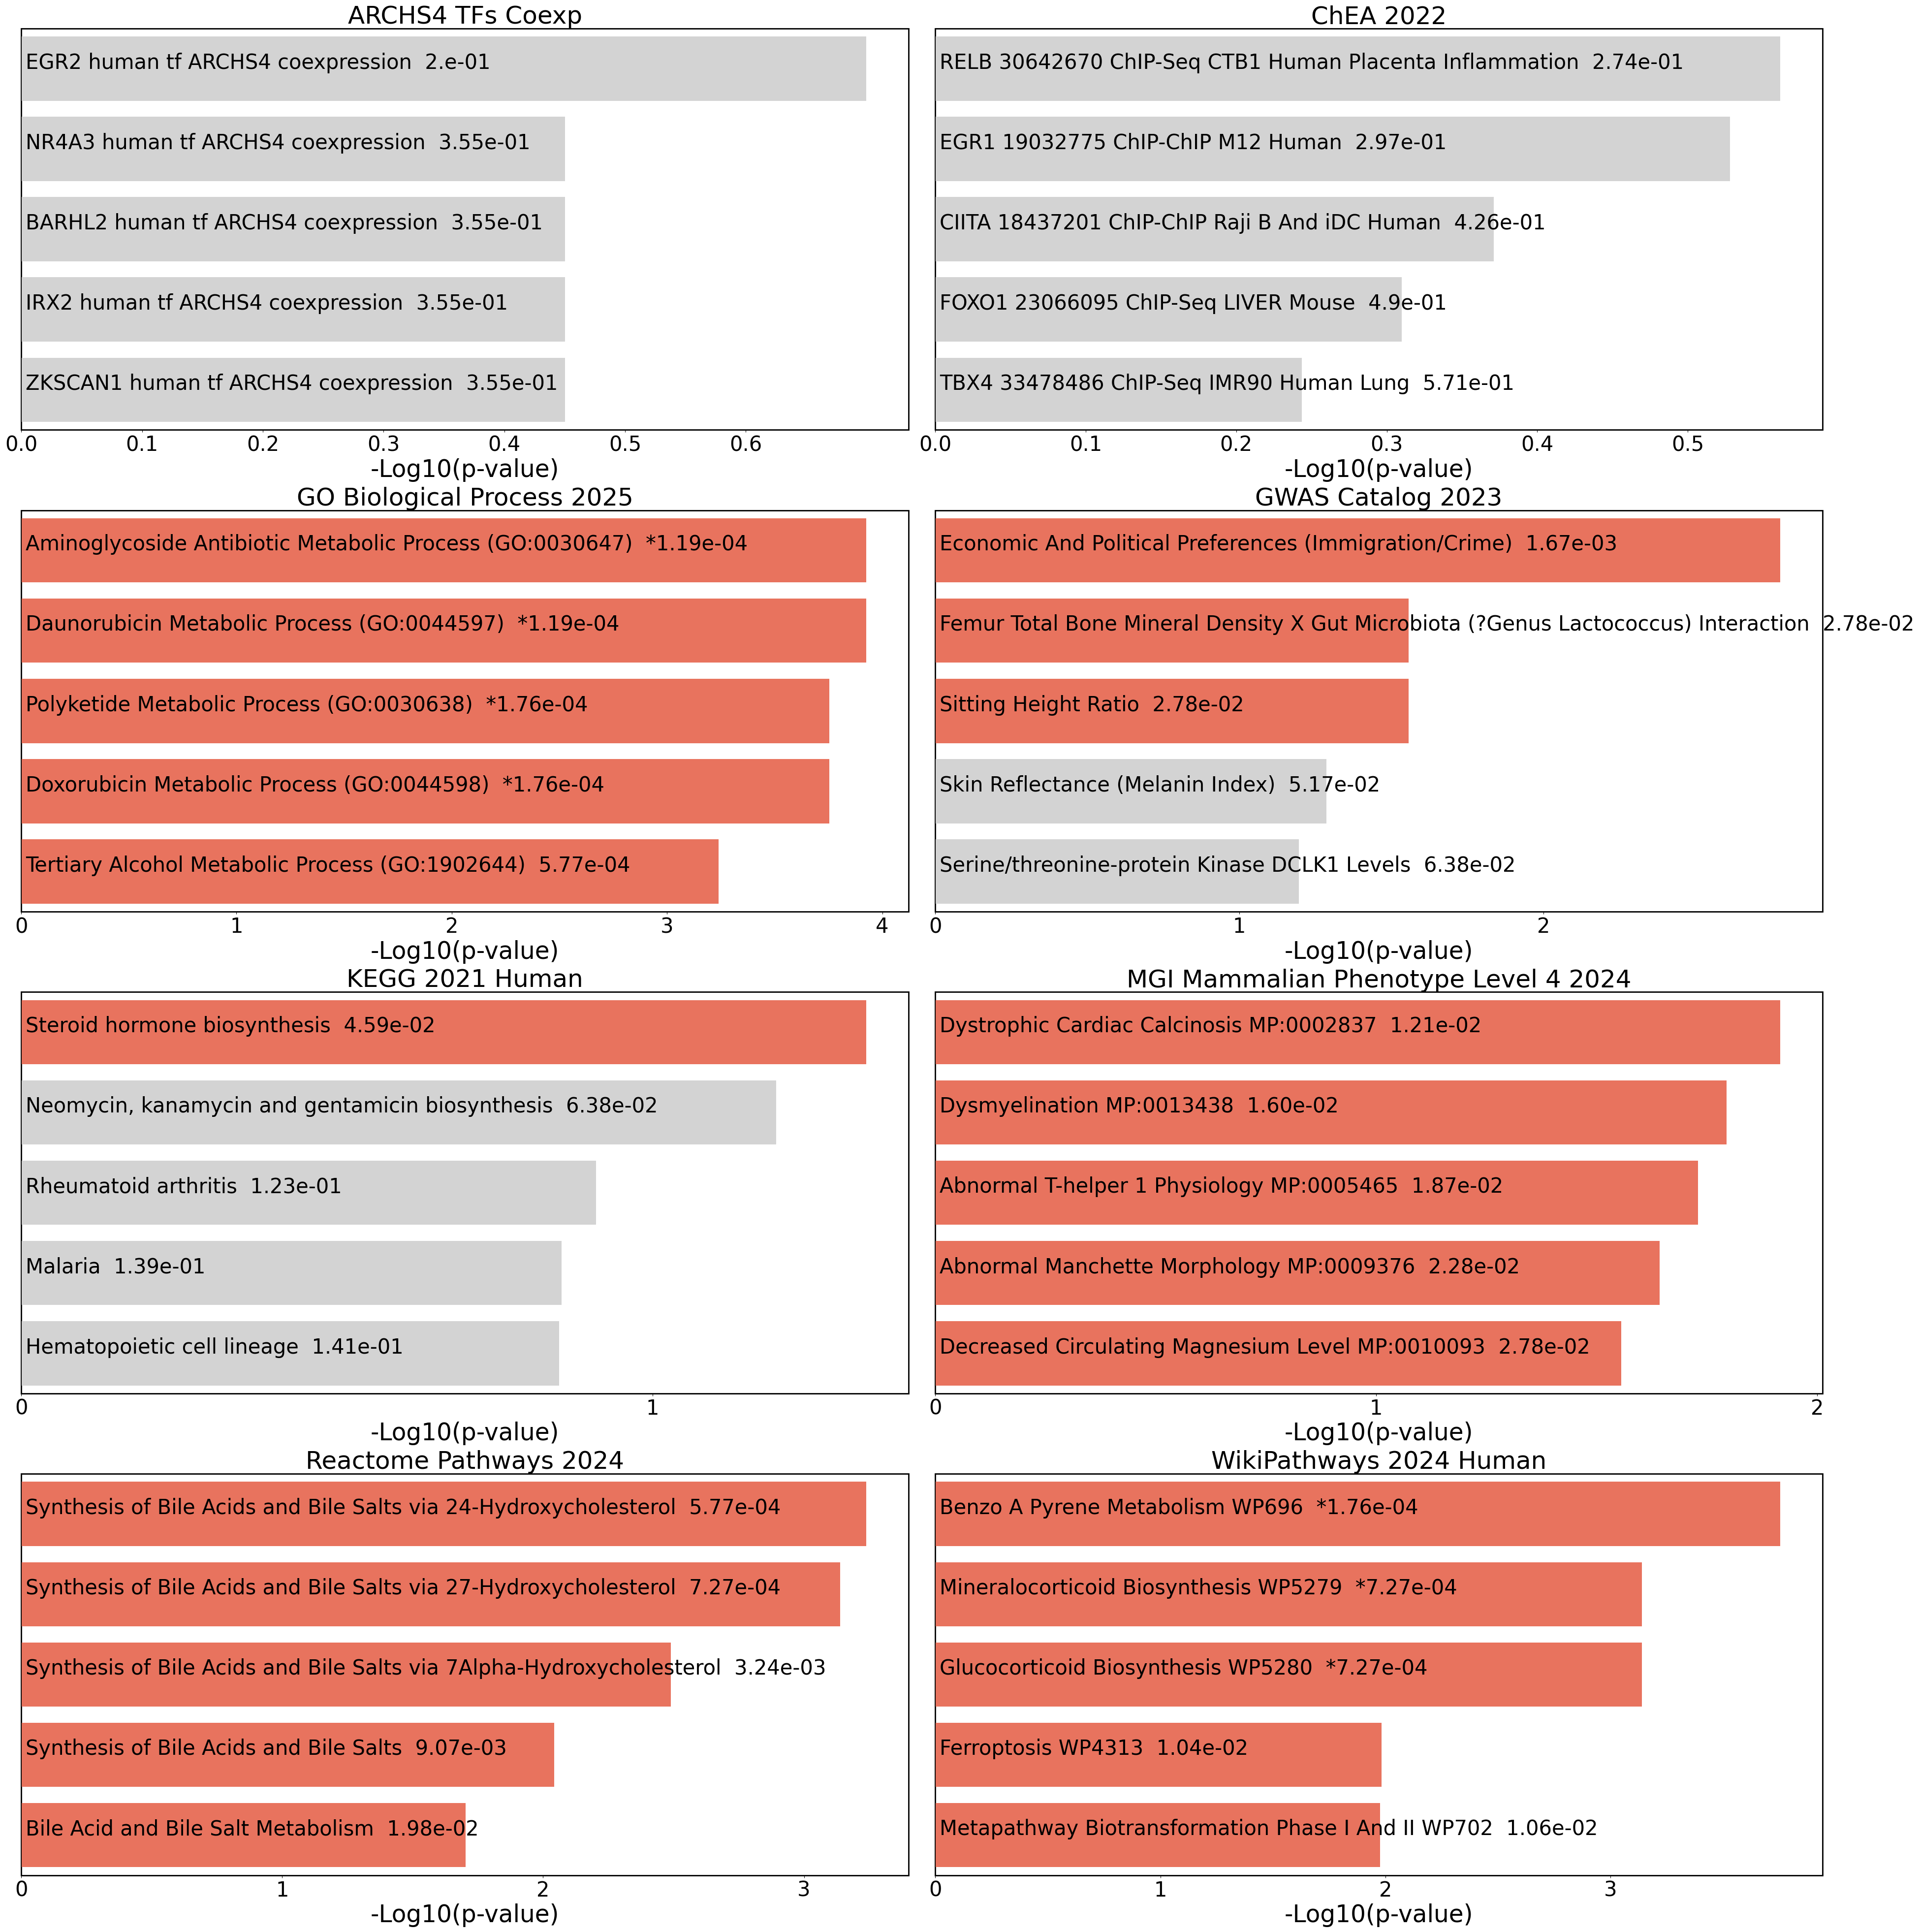

**Figure 8**: This figure contains several barplots depicting enrichment analysis results on the upregulated gene set. Each barplot corresponds to an individual library from Enrichr, and the top matching terms by p-value are depicted in each. Statistically significant terms are represented as red bars while others are represented as gray. Access your Enrichment results here: https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=37688fa2cdb8fd824ac139fe44ac4f5a

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep up_enrichr_results.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep up_enrichr_results.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep up_enrichr_results.jpeg

#### **cells dmso h rep-vs-cells rsl h rep**

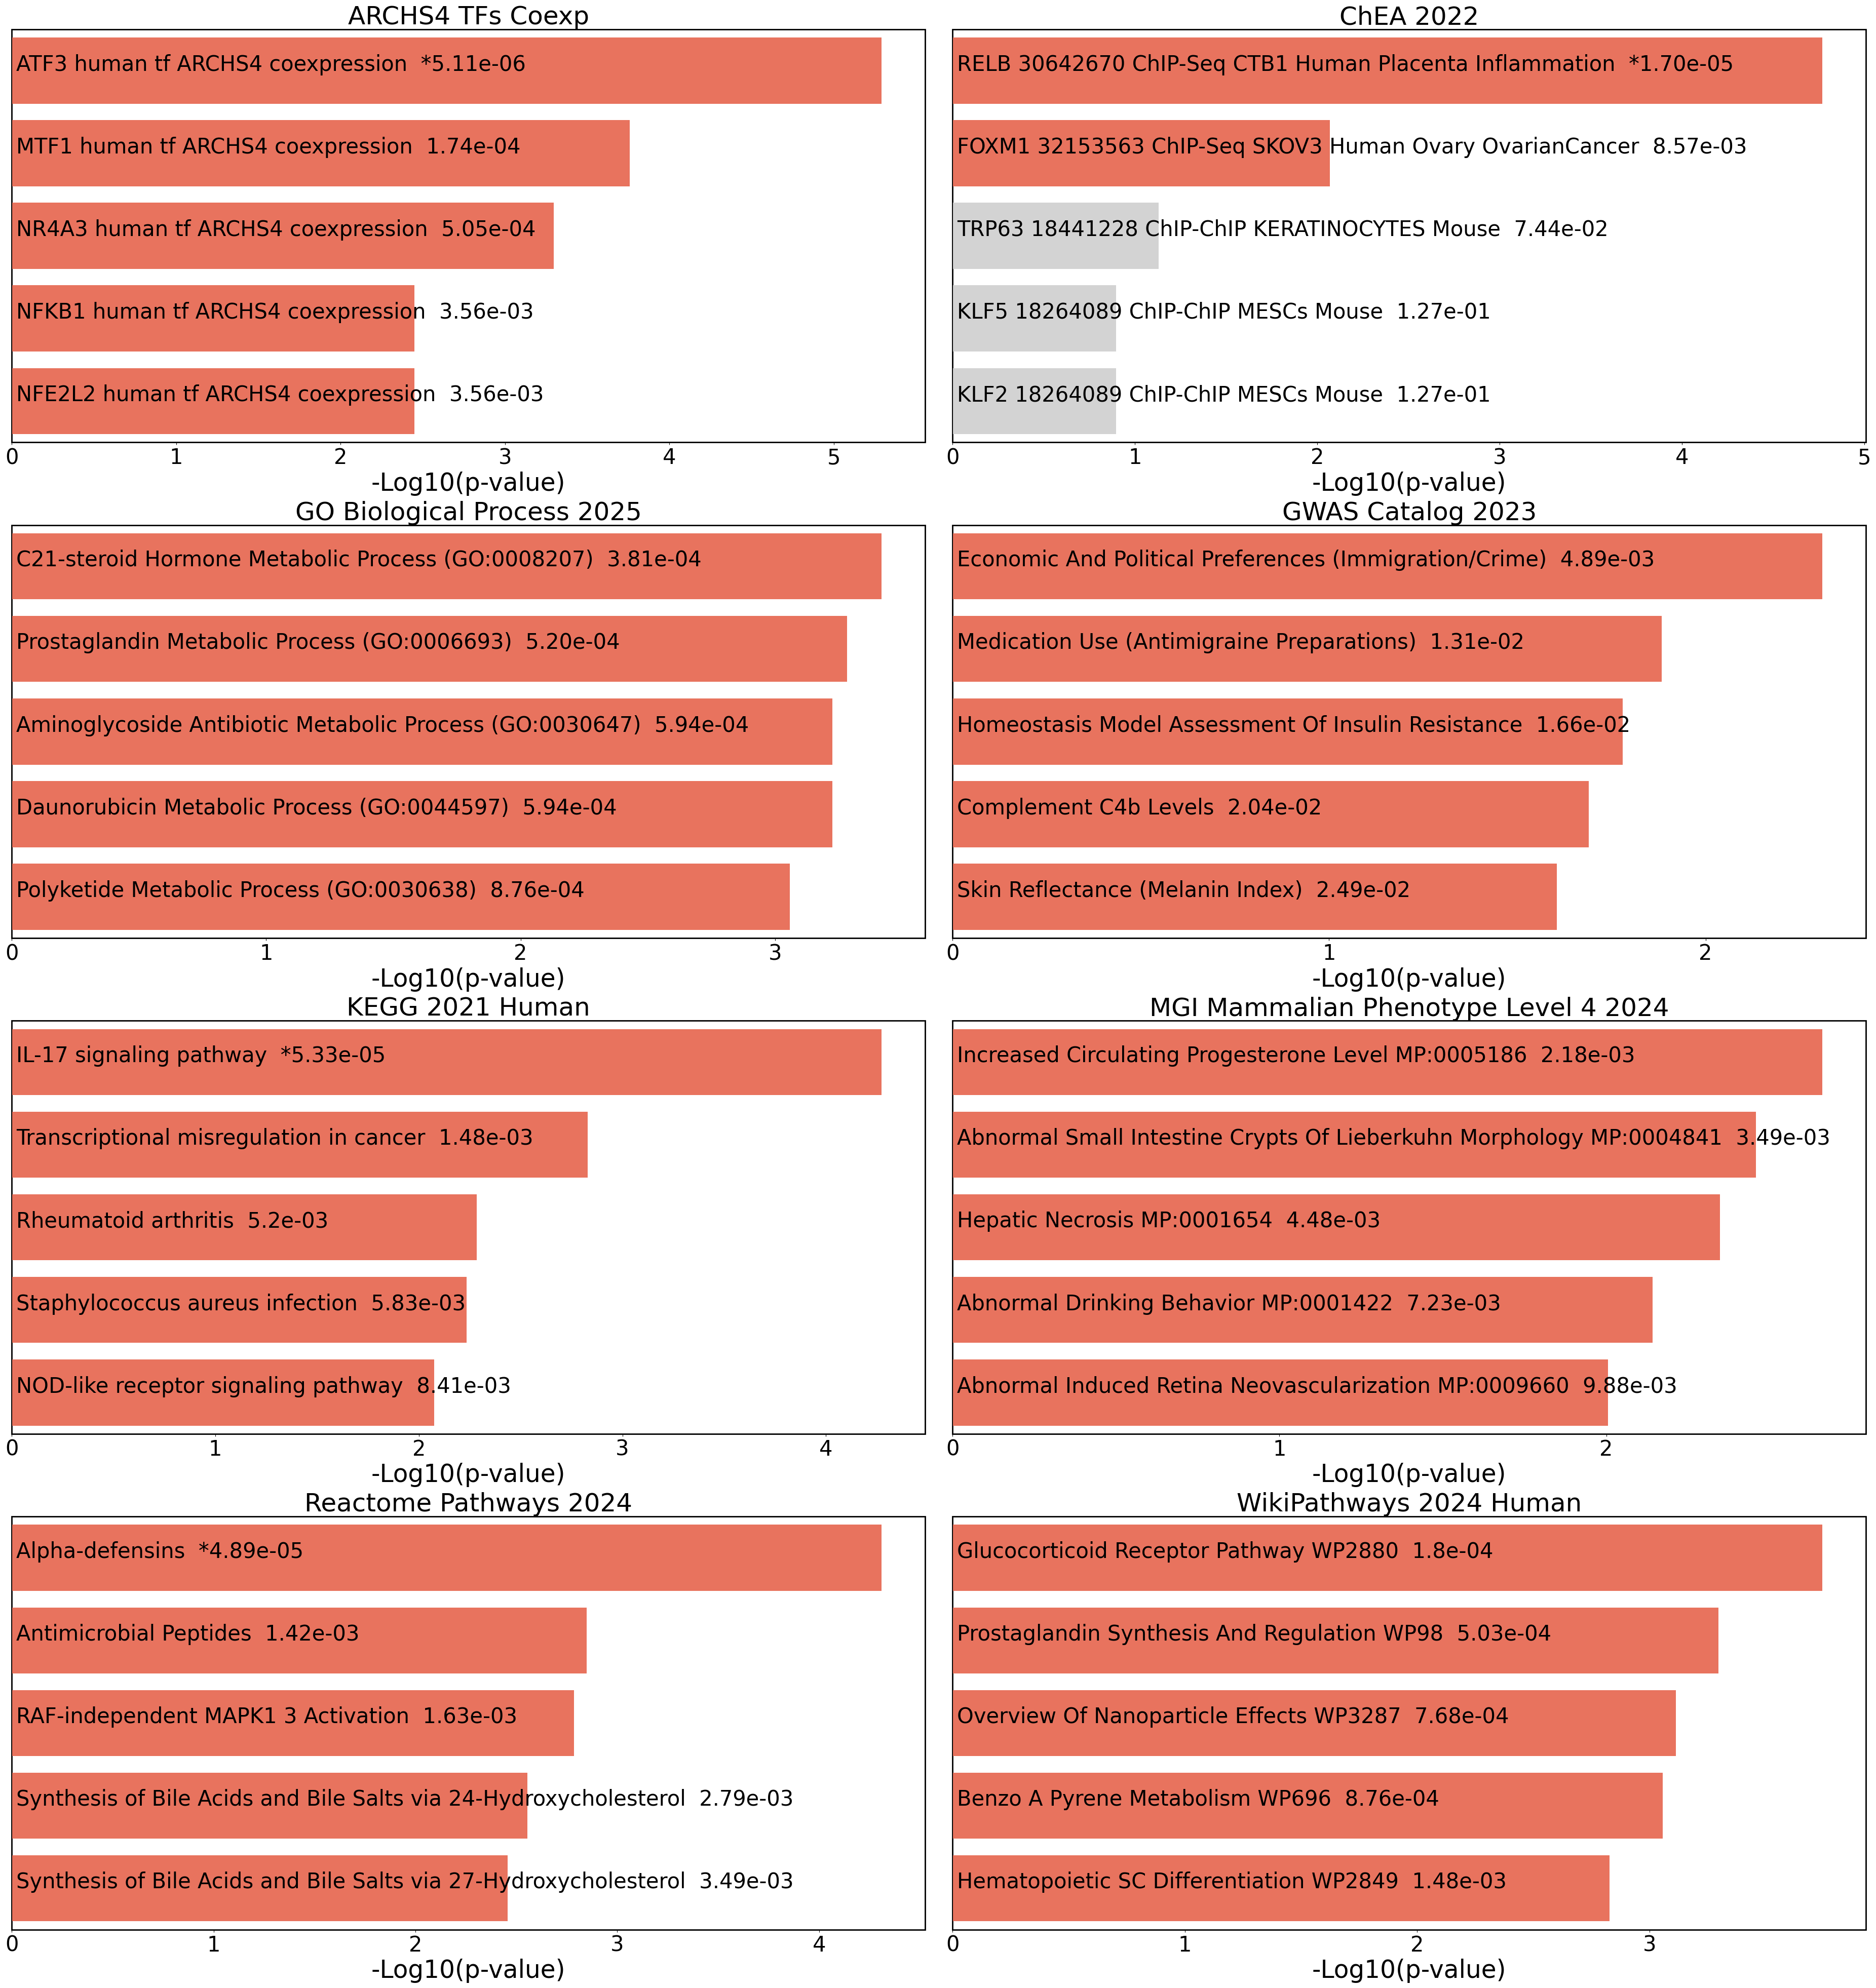

**Figure 9**: This figure contains several barplots depicting enrichment analysis results on the upregulated gene set. Each barplot corresponds to an individual library from Enrichr, and the top matching terms by p-value are depicted in each. Statistically significant terms are represented as red bars while others are represented as gray. Access your Enrichment results here: https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=f46cc8b3b6124d04b1e2ec6f647579ea

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep up_enrichr_results.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep up_enrichr_results.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep up_enrichr_results.jpeg

In [66]:
from IPython.display import Image
#upregulated results
for sig_name in sig_names_clean:
    up_file_name = sig_name + ' up_enrichr_results'
    final_output_file_names_up = [str(os.path.join(resource_path, up_file_name+'.'+file_type)) for file_type in figure_file_format]
    uresults = Enrichr_API(upreg[sig_name], enrichr_libraries)
    display(Markdown(f"#### **{sig_name}**"))
    enrichr_figure(uresults[0],uresults[1],uresults[2],final_output_file_names_up, uresults[4],figure_file_format, color, show_plot=False)
    display(Image(final_output_file_names_up[0], width=600)) #display the PNG
    display(Markdown(f'**Figure {fig_num}**: This figure contains several barplots depicting enrichment analysis results on the upregulated gene set. Each barplot corresponds to an individual library from Enrichr, and the top matching terms by p-value are depicted in each. Statistically significant terms are represented as red bars while others are represented as gray. Access your Enrichment results here: ' + str('https://amp.pharm.mssm.edu/Enrichr/enrich?dataset='+ uresults[3])))
    fig_num+=1

    for name in final_output_file_names_up: 
        display(FileLink(name, result_html_prefix=f"Download figure as {name[name.rfind('.')+1:]}:"))

### **Downregulated Set**

#### **cells dmso h rep-vs-cells rsl fer h rep**

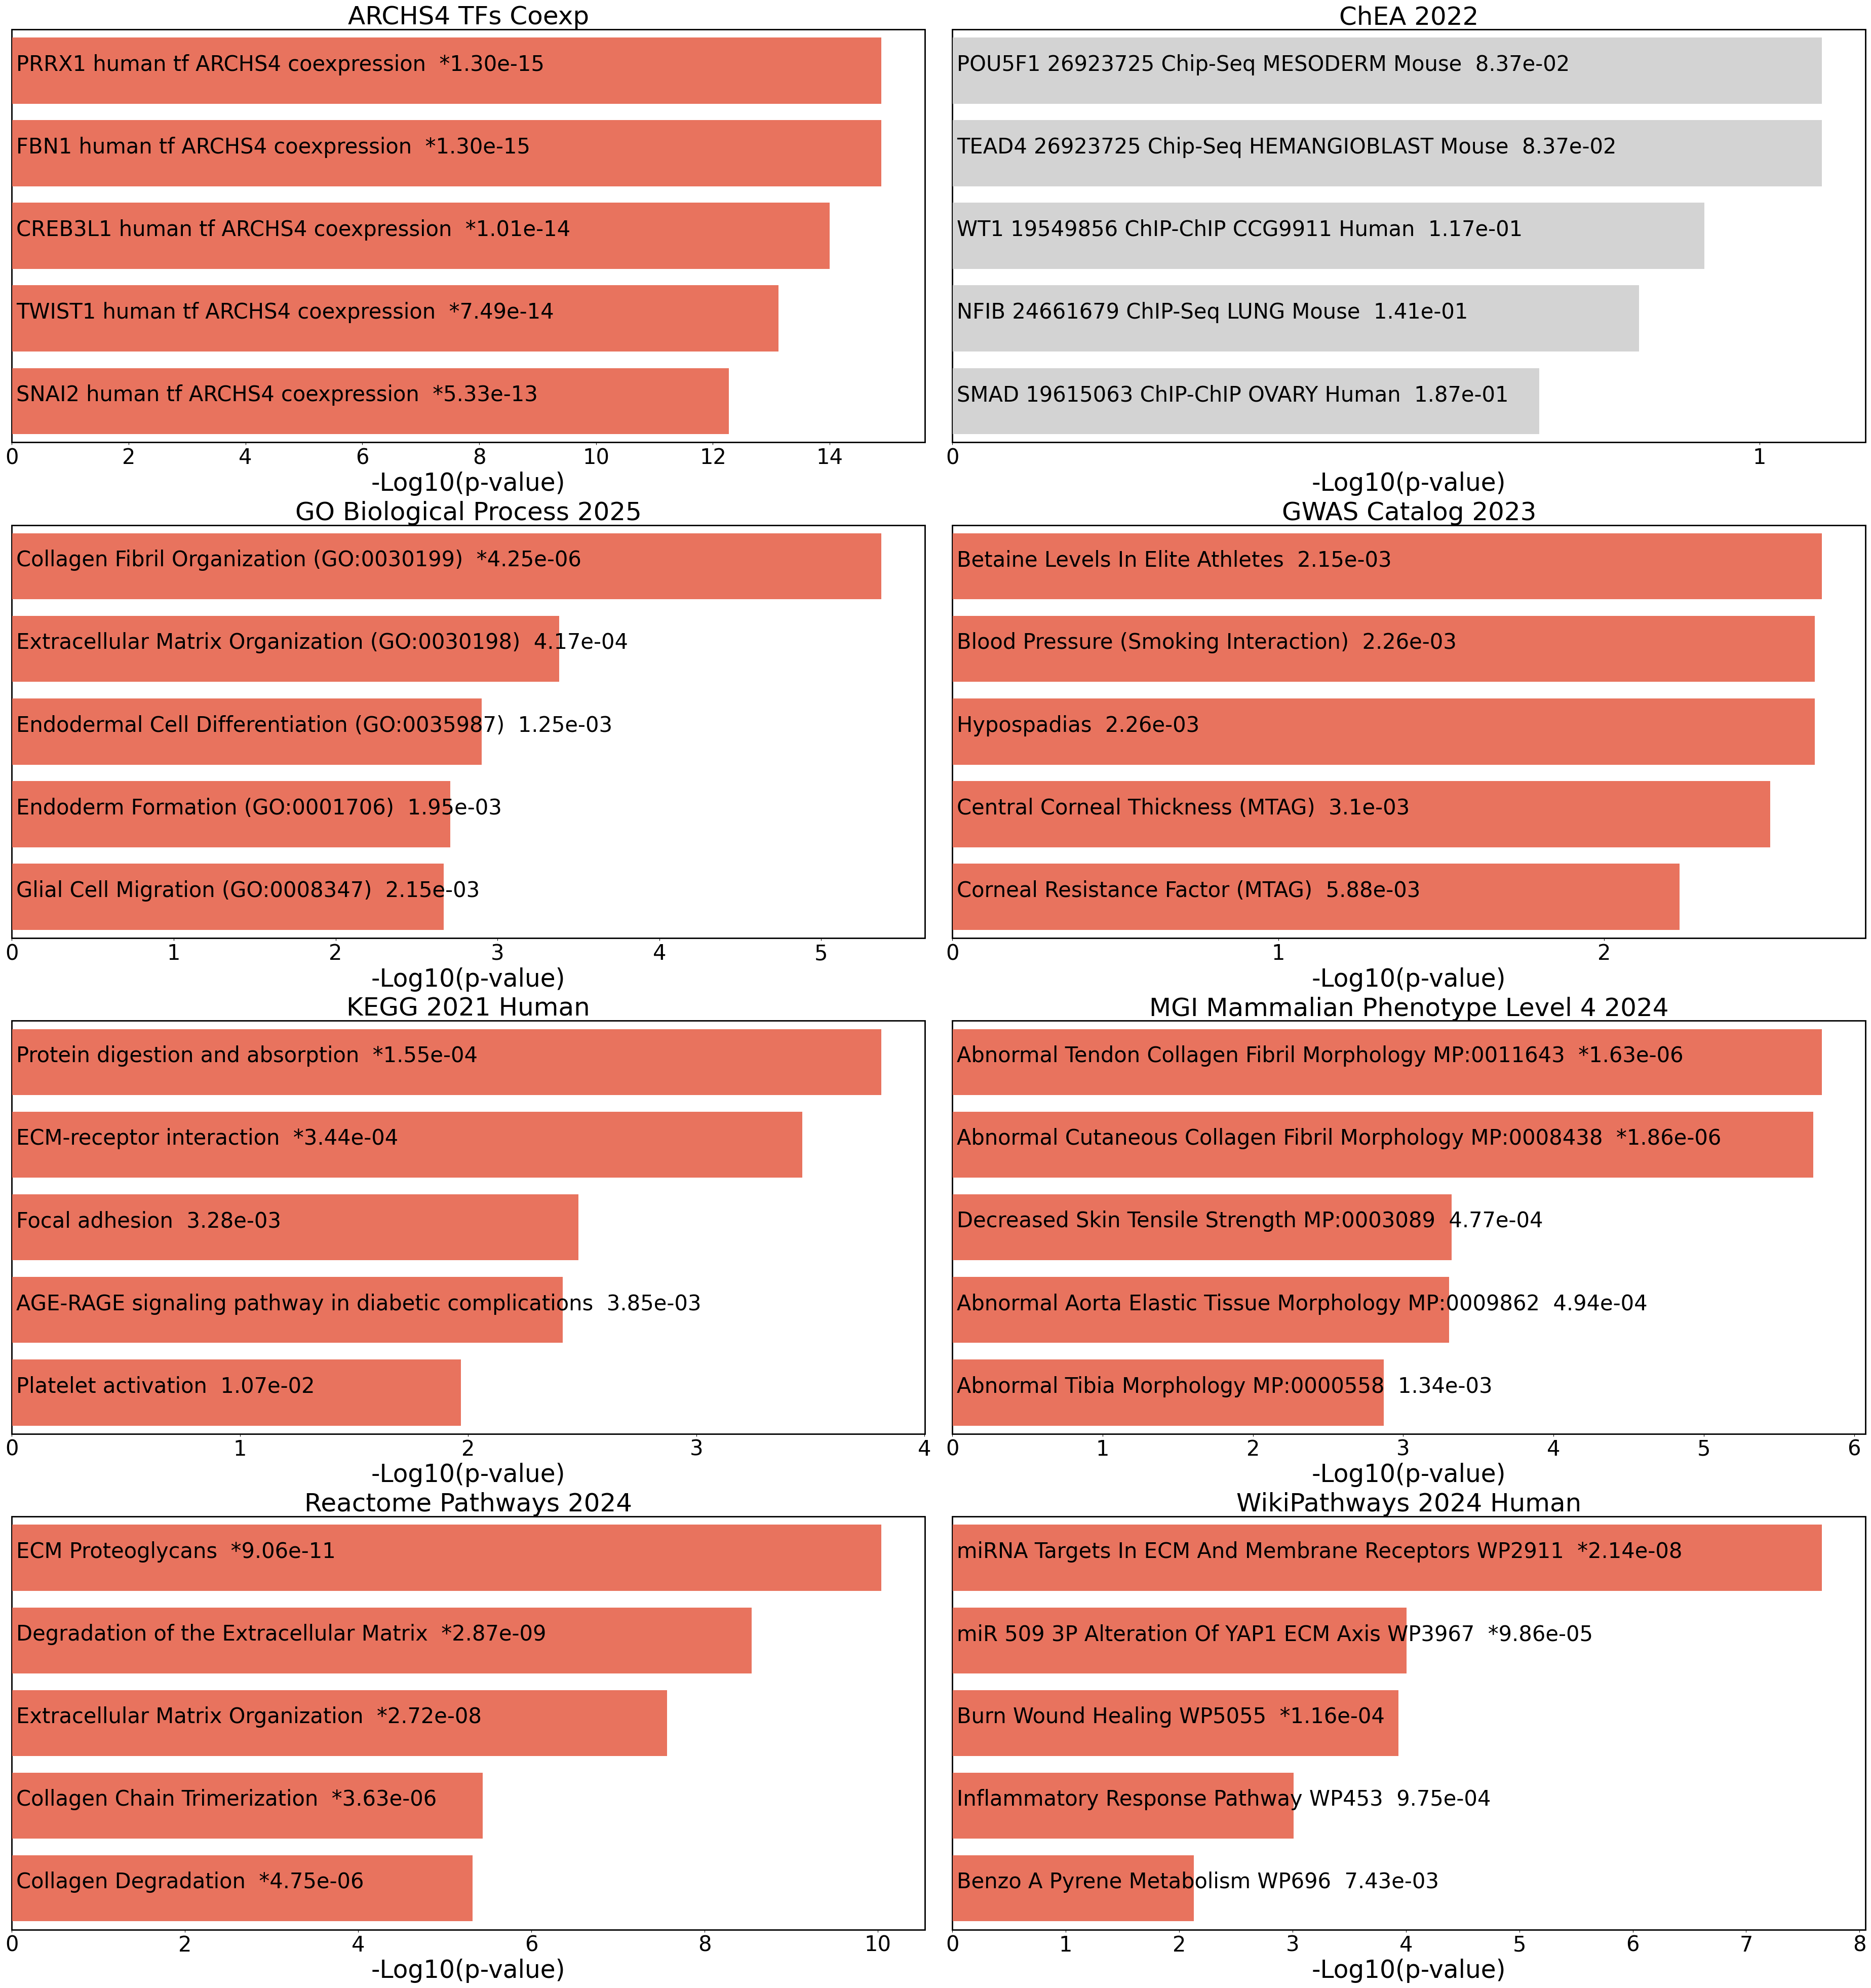

**Figure 10**: This figure contains several barplots depicting enrichment analysis results on the upregulated gene set. Each barplot corresponds to an individual library from Enrichr, and the top matching terms by p-value are depicted in each. Statistically significant terms are represented as red bars while others are represented as gray. Access your Enrichment results here: https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=f46cc8b3b6124d04b1e2ec6f647579ea

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep dn_enrichr_results.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep dn_enrichr_results.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep dn_enrichr_results.jpeg

#### **cells dmso h rep-vs-cells rsl h rep**

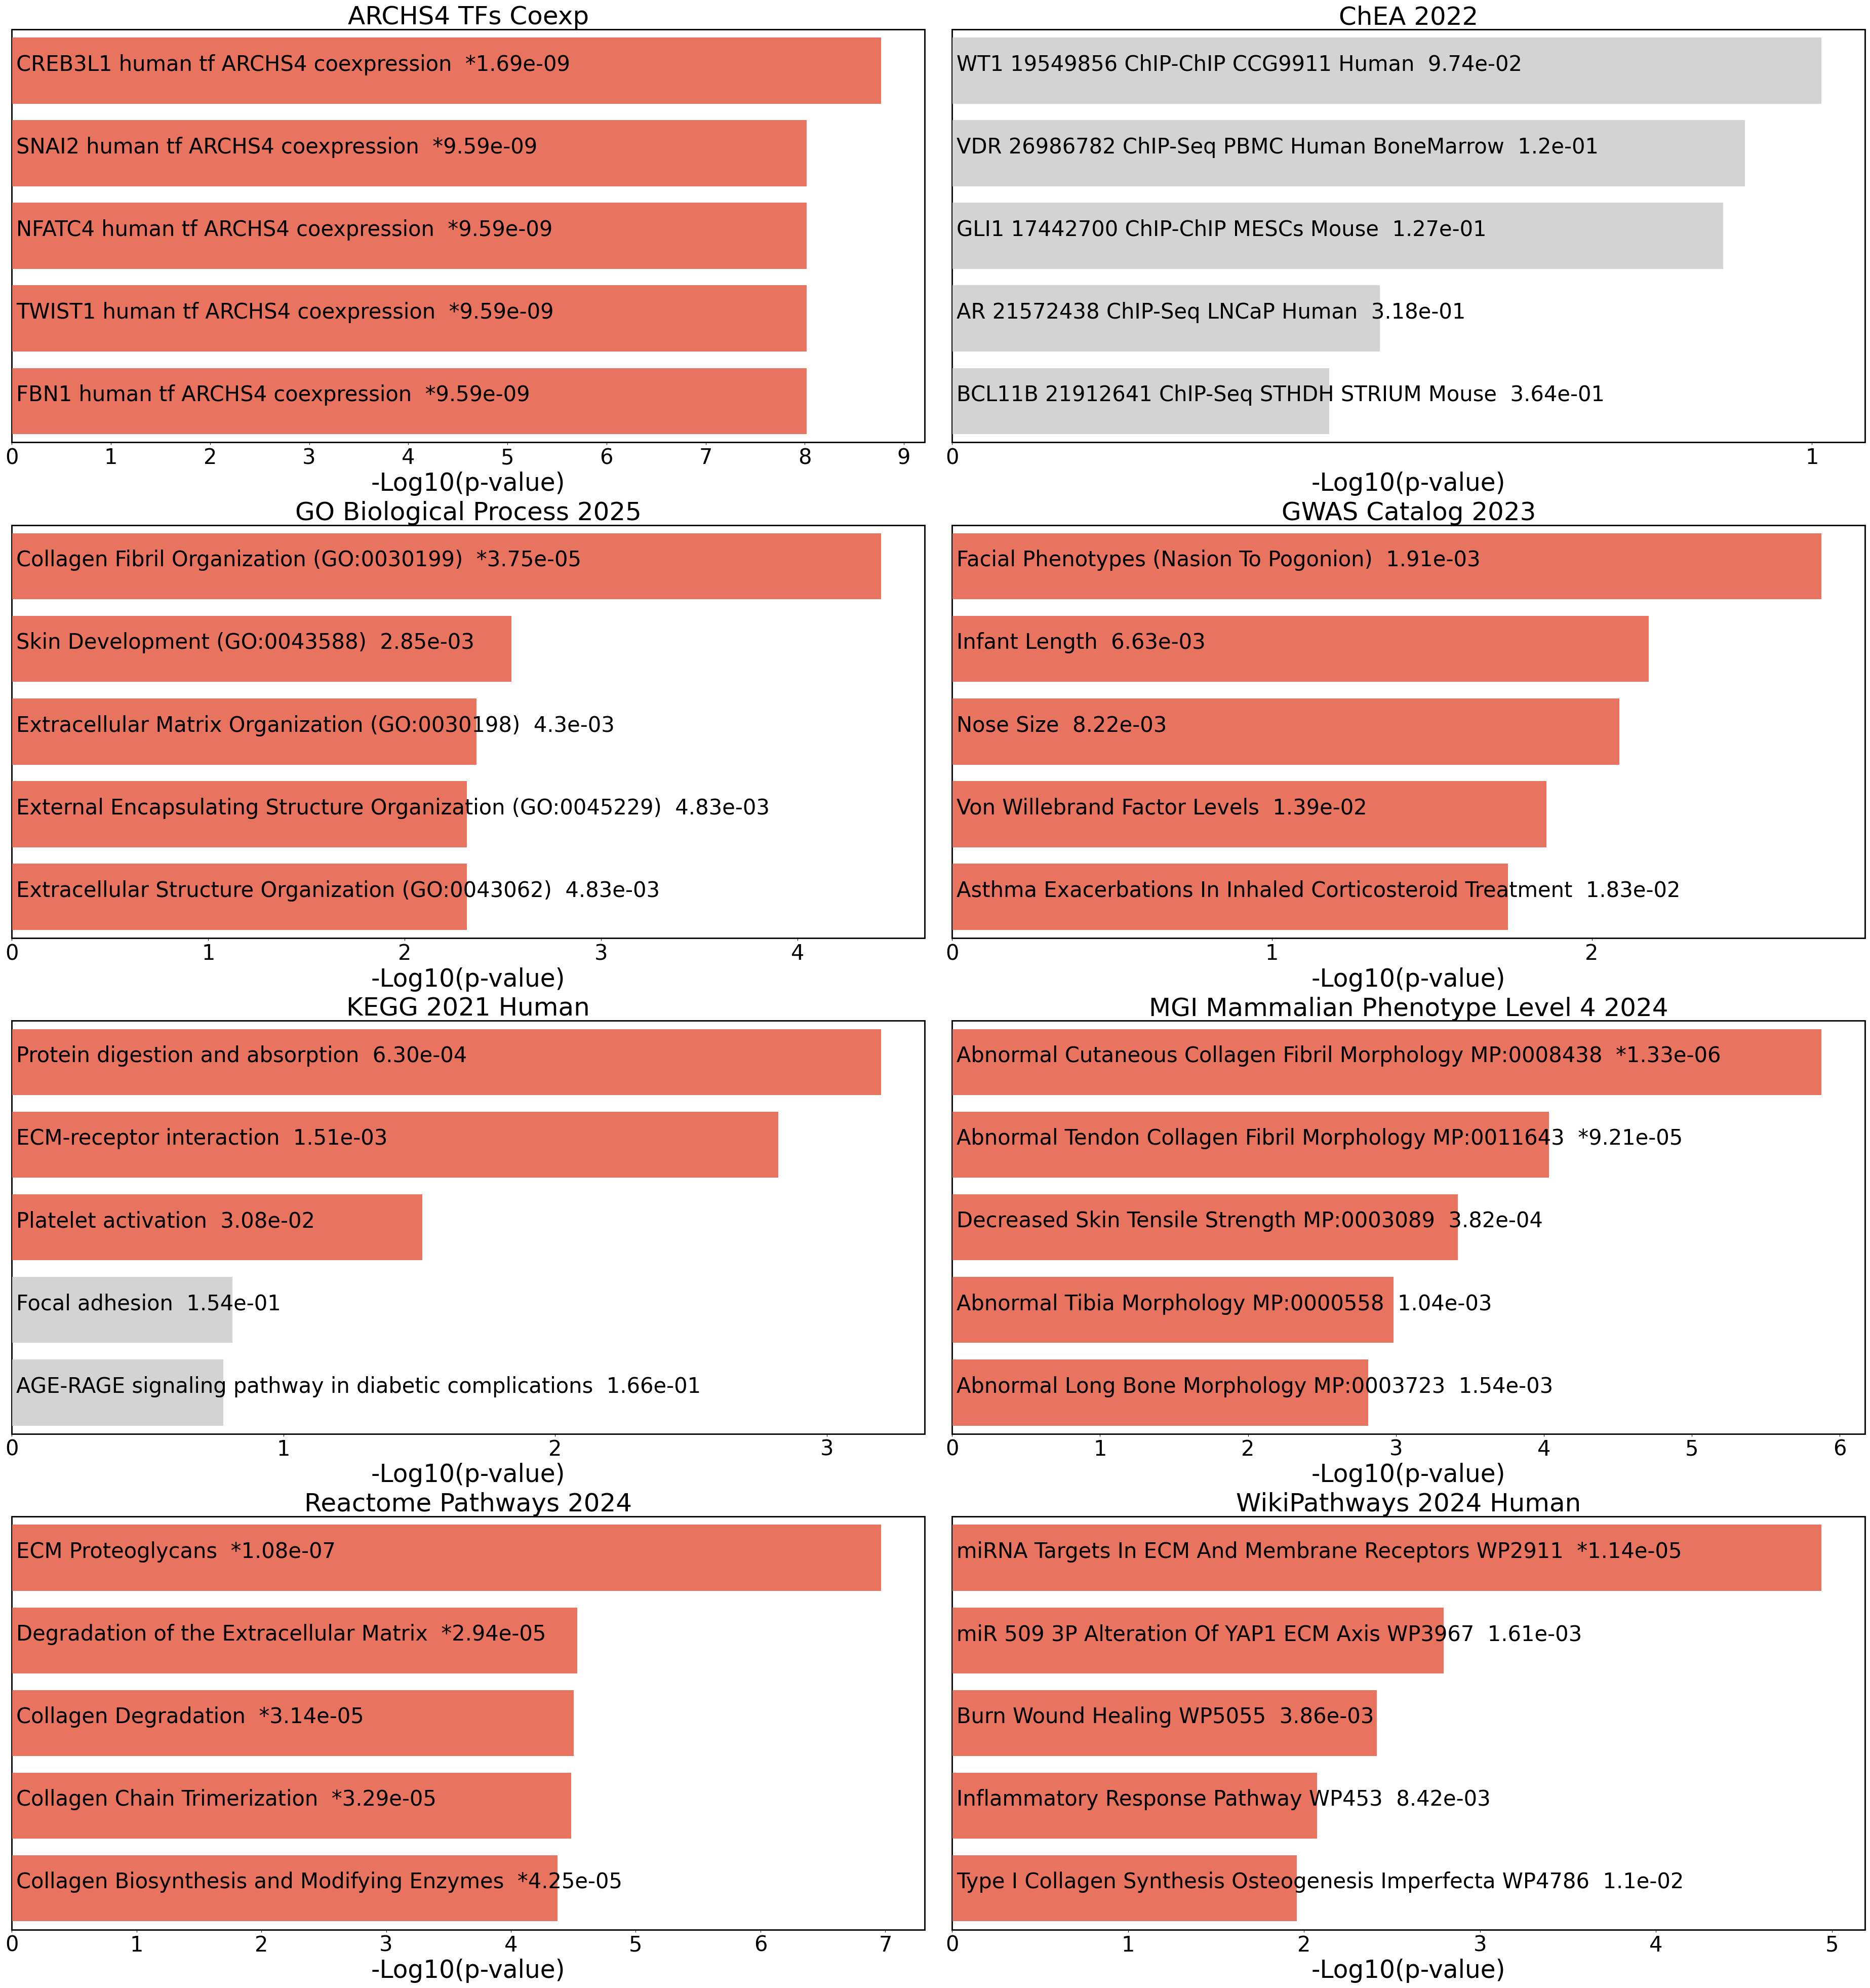

**Figure 11**: This figure contains several barplots depicting enrichment analysis results on the upregulated gene set. Each barplot corresponds to an individual library from Enrichr, and the top matching terms by p-value are depicted in each. Statistically significant terms are represented as red bars while others are represented as gray. Access your Enrichment results here: https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=f46cc8b3b6124d04b1e2ec6f647579ea

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep dn_enrichr_results.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep dn_enrichr_results.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep dn_enrichr_results.jpeg

In [67]:
#downregulated results
for sig_name in sig_names_clean:
    dn_file_name = sig_name + ' dn_enrichr_results'
    final_output_file_names_dn = [str(os.path.join(resource_path, dn_file_name+'.'+file_type)) for file_type in figure_file_format]
    dresults = Enrichr_API(downreg[sig_name], enrichr_libraries)
    display(Markdown(f"#### **{sig_name}**"))
    enrichr_figure(dresults[0],dresults[1],dresults[2],final_output_file_names_dn, dresults[4],figure_file_format, color, show_plot=False)
    display(Image(final_output_file_names_dn[0], width=600)) #display the PNG
    display(Markdown(f'**Figure {fig_num}**: This figure contains several barplots depicting enrichment analysis results on the upregulated gene set. Each barplot corresponds to an individual library from Enrichr, and the top matching terms by p-value are depicted in each. Statistically significant terms are represented as red bars while others are represented as gray. Access your Enrichment results here: ' + str('https://amp.pharm.mssm.edu/Enrichr/enrich?dataset='+ uresults[3])))
    fig_num+=1

    for name in final_output_file_names_dn: 
        display(FileLink(name, result_html_prefix=f"Download figure as {name[name.rfind('.')+1:]}:"))

## **CHEA3: Transcription Factor Enrichment Analysis**

### **Upregulated Set**

#### **cells dmso h rep-vs-cells rsl fer h rep**

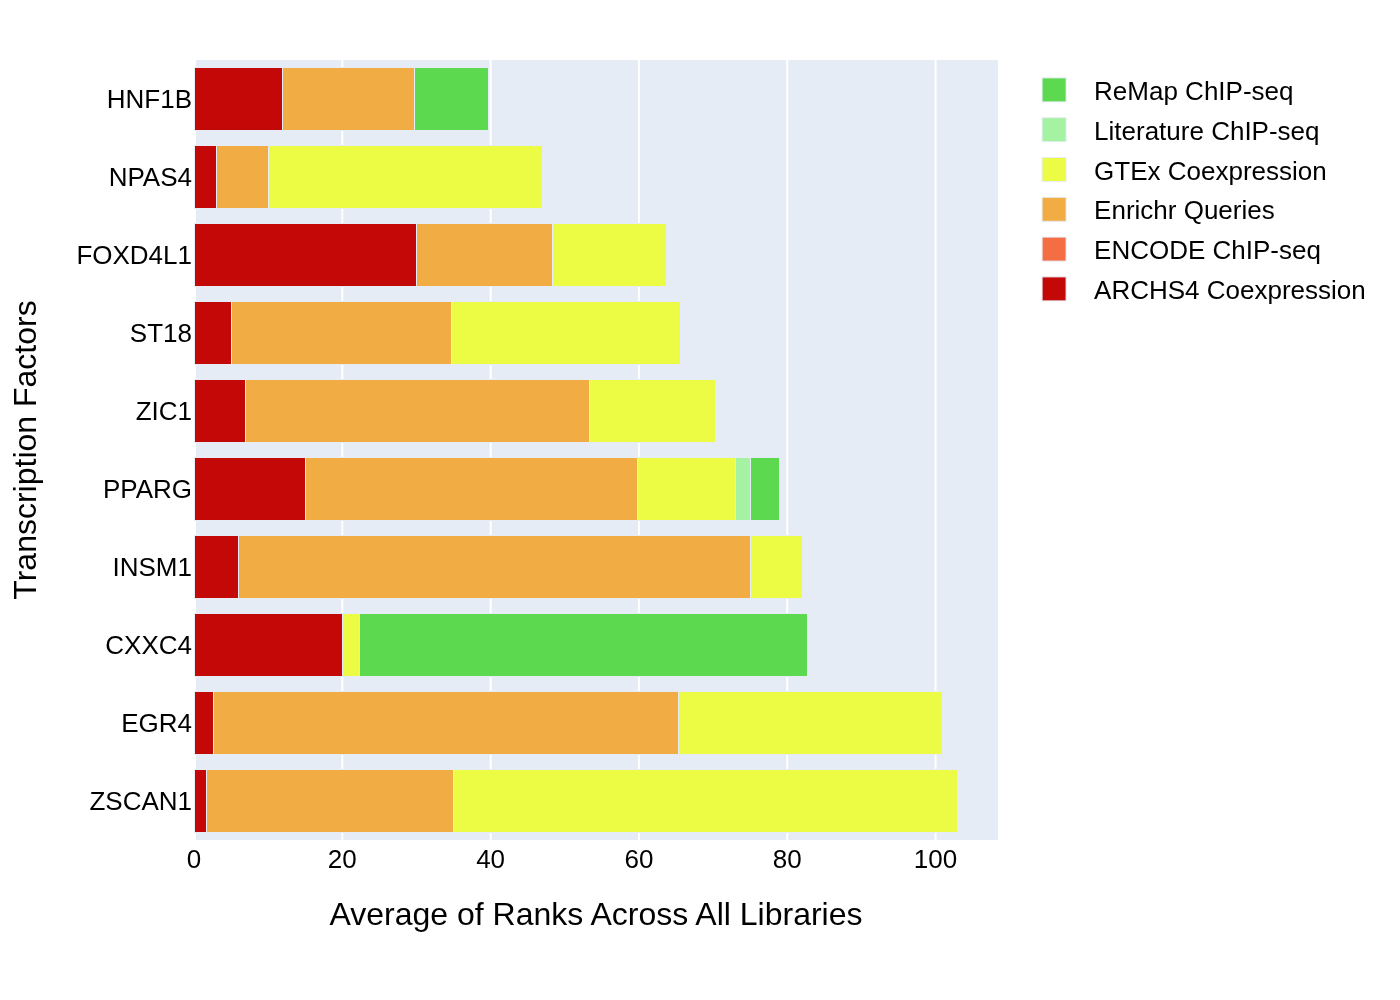

**Figure 12**: Horizontal bar chart, y-axis represents transcription factors. Displays the top ranked transcription factors for the upregulated set according to their average integrated scores across all the libraries.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h repupchea.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h repupchea.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h repupchea.jpeg

#### **cells dmso h rep-vs-cells rsl h rep**

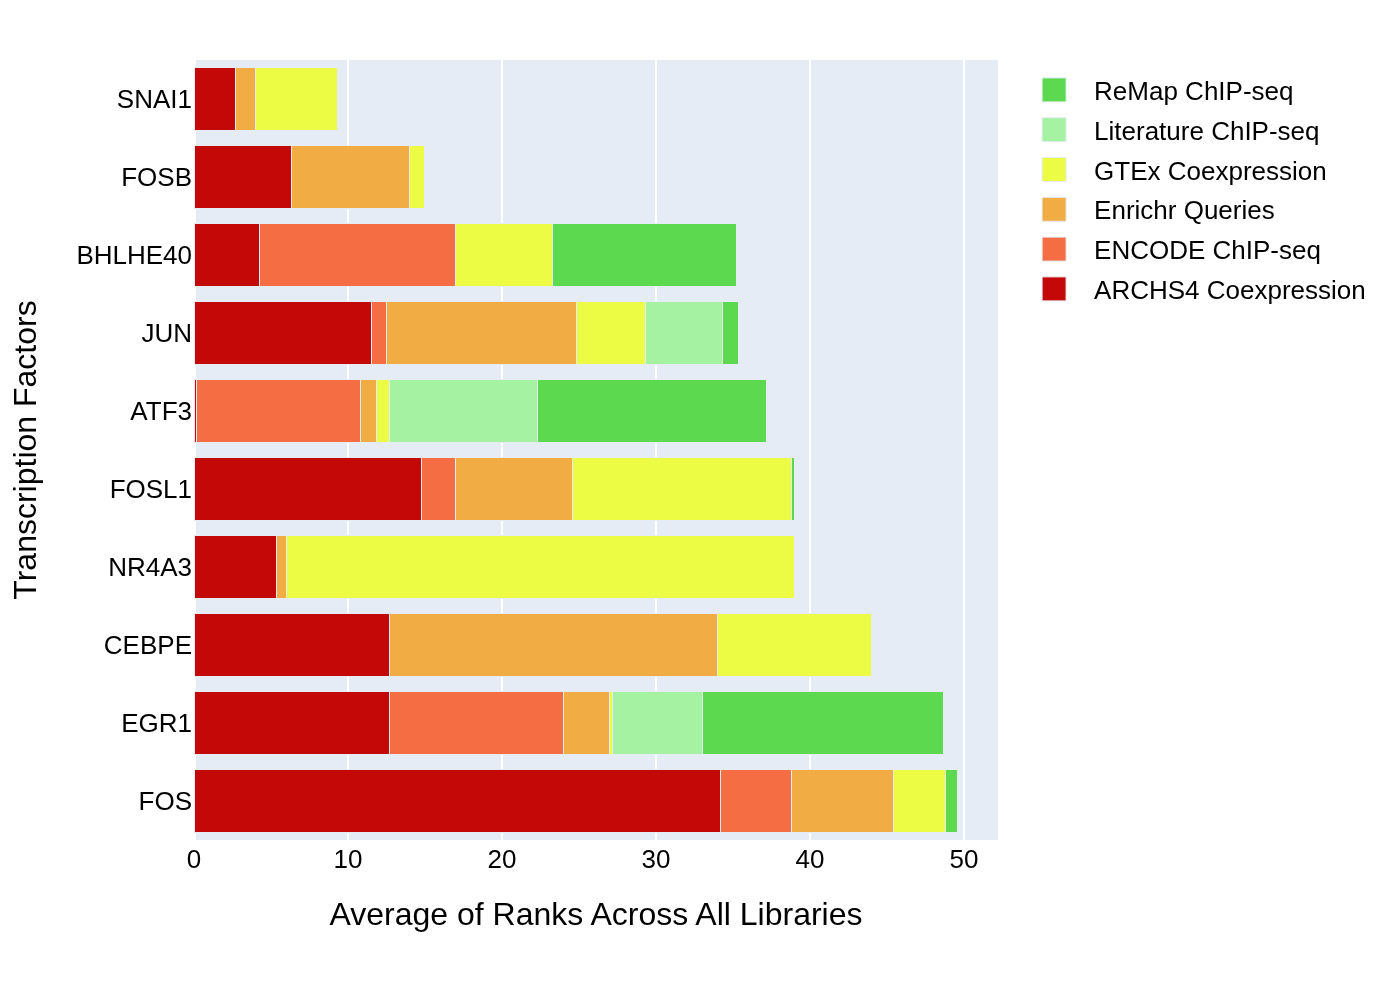

**Figure 13**: Horizontal bar chart, y-axis represents transcription factors. Displays the top ranked transcription factors for the upregulated set according to their average integrated scores across all the libraries.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h repupchea.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h repupchea.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h repupchea.jpeg

In [68]:
import python_scripts.chea3 as chea

#TFs of upregulated genes
for sig_name in sig_names_clean:
    save_name = sig_name + 'upchea'
    up_results = chea.get_chea3_results(upreg[sig_name], 'query')
    chea.mean_rank_bar(up_results, save_name=save_name, save_formats=save_formats, save_html=save_html, save_path=resource_path)
    
    display(Markdown(f"#### **{sig_name}**"))
    #if save_html: display(HTML(os.path.join(resource_path, f"{save_name}.html")))
    display(Image(os.path.join(resource_path, f"{save_name}.png"), width=700))
    display(Markdown(f"**Figure {fig_num}**: Horizontal bar chart, y-axis represents transcription factors. Displays the top ranked transcription factors for the upregulated set according to their average integrated scores across all the libraries."))
    fig_num+=1

    for fmt in save_formats:
        file_name=os.path.join(resource_path, f"{save_name}.{fmt}")
        display(FileLink(file_name, result_html_prefix=f"Download bar plot as {fmt}: "))


### **Downregulated Set**

#### **cells dmso h rep-vs-cells rsl fer h rep**

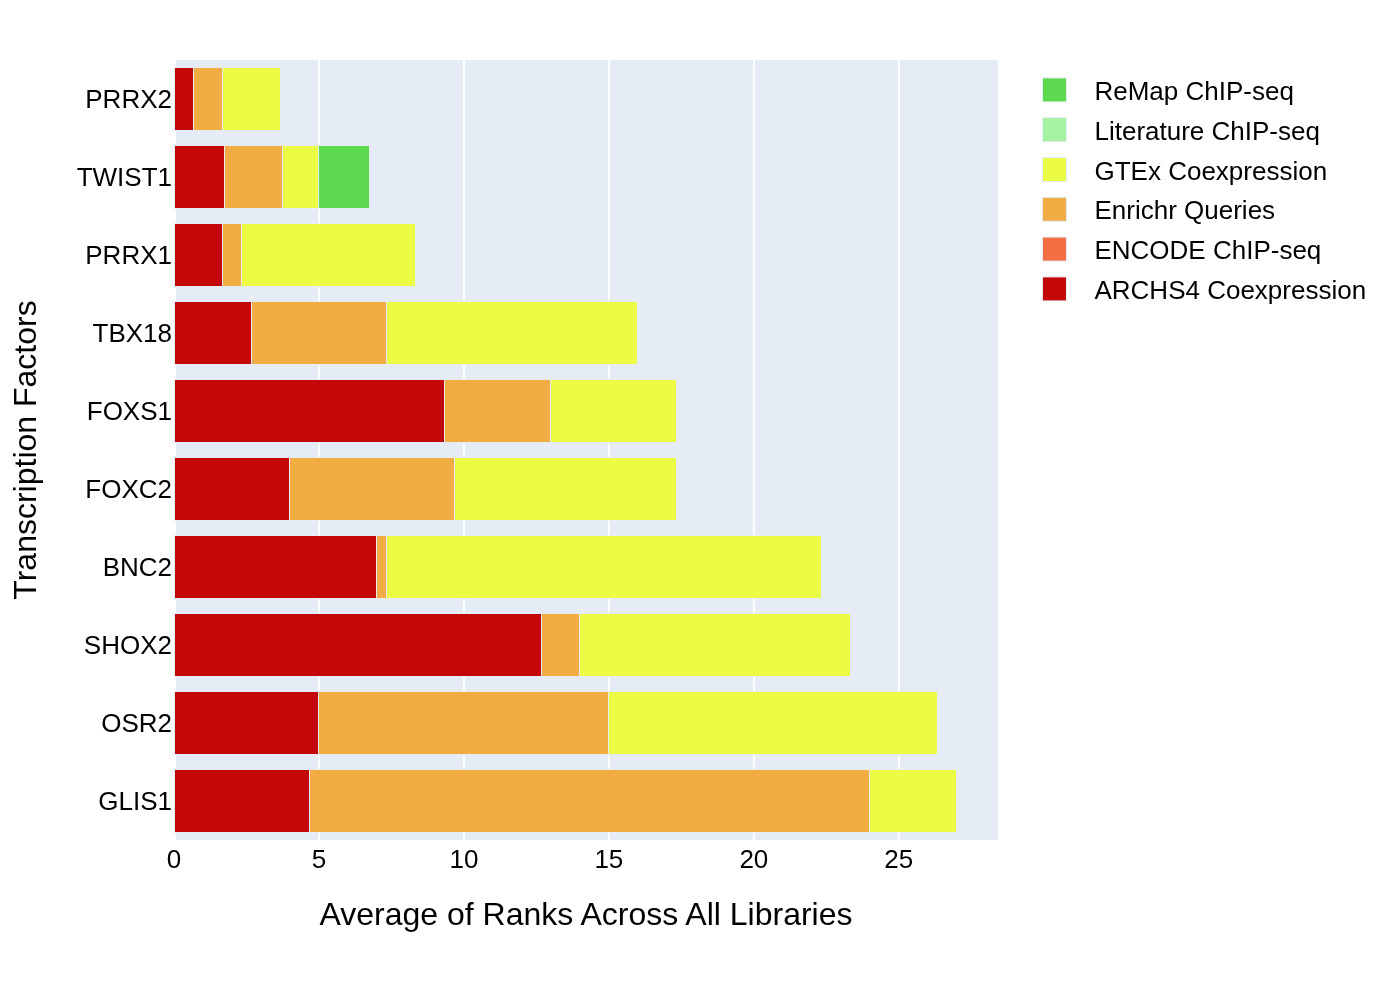

**Figure 14**: Horizontal bar chart, y-axis represents transcription factors. Displays the top ranked transcription factors for the upregulated set according to their average integrated scores across all the libraries.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h repdnchea.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h repdnchea.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h repdnchea.jpeg

#### **cells dmso h rep-vs-cells rsl h rep**

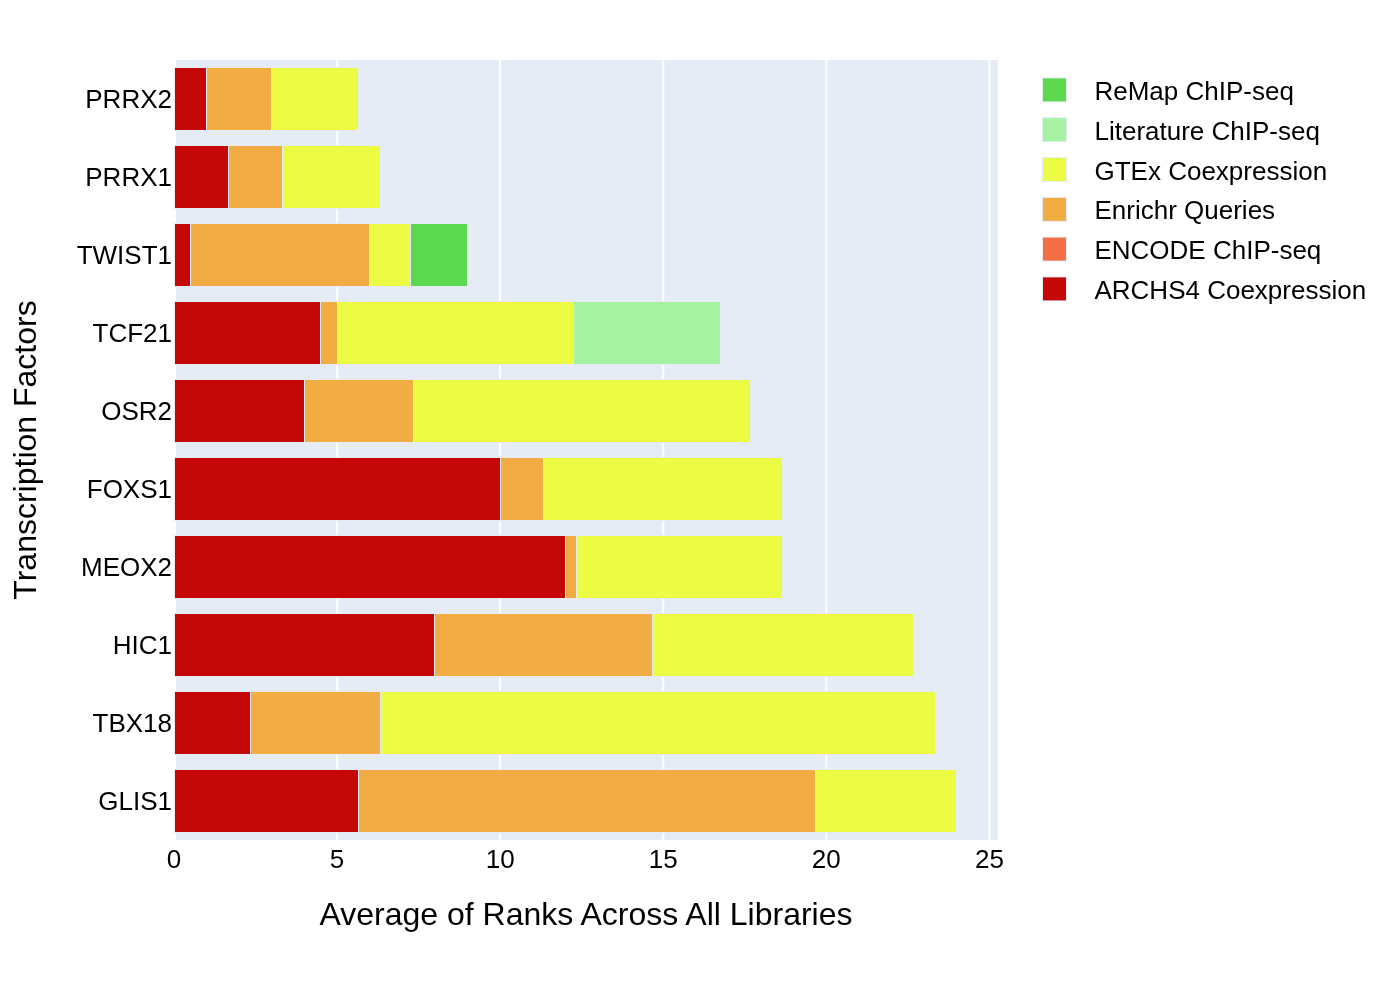

**Figure 15**: Horizontal bar chart, y-axis represents transcription factors. Displays the top ranked transcription factors for the upregulated set according to their average integrated scores across all the libraries.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h repdnchea.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h repdnchea.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h repdnchea.jpeg

In [69]:
for sig_name in sig_names_clean:
    save_name = sig_name + 'dnchea'
    dn_results = chea.get_chea3_results(downreg[sig_name], 'query')
    chea.mean_rank_bar(dn_results, save_name=save_name, save_formats=save_formats, save_html=save_html, save_path=resource_path)
    
    display(Markdown(f"#### **{sig_name}**"))
    #if save_html: display(HTML(os.path.join(resource_path, f"{save_name}.html")))
    display(Image(os.path.join(resource_path, f"{save_name}.png"), width=700))
    display(Markdown(f"**Figure {fig_num}**: Horizontal bar chart, y-axis represents transcription factors. Displays the top ranked transcription factors for the upregulated set according to their average integrated scores across all the libraries."))
    fig_num+=1

    for fmt in save_formats:
        file_name=os.path.join(resource_path, f"{save_name}.{fmt}")
        display(FileLink(file_name, result_html_prefix=f"Download bar plot as {fmt}: "))

## **L2S2 and DRUG-seqr: Reverser and Mimicker Drugs**

### **Reverser Results**

#### **cells dmso h rep-vs-cells rsl fer h rep**

**l2s2_fda**

perturbation                                          term  \
0         trametinib  PBIOA004_XC.L10_24H_K06_trametinib_2.22uM up   
1        selumetinib    ASG003_XC.P909_24H_E04_selumetinib_10uM up   
2           afatinib     ASG003_XC.P914_24H_M20_afatinib_1.11uM up   
3          acyclovir     REP.A008_MCF7_24H_E06_acyclovir_0.04uM up   
4        selumetinib     REP.A015_A375_24H_E19_selumetinib_10uM up   
5         trametinib    PBIOA004_XC.R10_24H_K04_trametinib_20uM up   
6       dinoprostone  FIBR026_MCLF141SZ_6H_M12_dinoprostone_4uM up   
7        selumetinib  ASG003_XC.P091_24H_E05_selumetinib_1.11uM up   
8        selumetinib       LJP006_A549_24H_M07_selumetinib_10uM up   
9         trametinib   ASG003_XC.P911_24H_N18_trametinib_0.12uM up   
10      thioridazine     CPC006_HCC515_6H_G23_thioridazine_10uM up   
11       selumetinib      LKCP001_A549_24H_J10_selumetinib_10uM up   
12        trametinib    PBIOA004_XC.L10_24H_K04_trametinib_20uM up   
13  chlorotrianisene   PAC003_U2OS_6H_F14_chlorotrianisene_10uM up   
14        trametinib   ASG003_XC.P909_24H_N18_trametinib_0.12uM up   
15        trametinib  ASG002_NCIH1573_24H_G09_trametinib_0.12uM up   
16        famotidine         PAC004_U2OS_6H_B06_famotidine_10uM up   
17        trametinib    LCP001_MCF10A.WT_3H_D16_trametinib_10uM up   
18       thalidomide        CPC006_A549_6H_E14_thalidomide_10uM up   
19         dasatinib       LJP007_HT29_24H_G14_dasatinib_3.33uM up   

    pvalueReverse  adjPvalueReverse  oddsRatioReverse  reverserOverlap  \
0        2.15e-10          1.64e-05          3.47e+00               37   
1        2.15e-10          1.64e-05          3.47e+00               37   
2        8.27e-10          3.22e-05          3.37e+00               36   
3        8.27e-10          3.22e-05          3.37e+00               36   
4        8.27e-10          3.22e-05          3.37e+00               36   
5        8.27e-10          3.22e-05          3.37e+00               36   
6        8.27e-10          3.22e-05          3.37e+00               36   
7        3.07e-09          7.16e-05          3.27e+00               35   
8        3.07e-09          7.16e-05          3.27e+00               35   
9        3.07e-09          7.16e-05          3.27e+00               35   
10       3.07e-09          7.16e-05          3.27e+00               35   
11       3.07e-09          7.16e-05          3.27e+00               35   
12       1.11e-08          1.47e-04          3.17e+00               34   
13       1.11e-08          1.47e-04          3.17e+00               34   
14       1.11e-08          1.47e-04          3.17e+00               34   
15       1.11e-08          1.47e-04          3.17e+00               34   
16       1.11e-08          1.47e-04          3.17e+00               34   
17       1.11e-08          1.47e-04          3.17e+00               34   
18       1.11e-08          1.47e-04          3.17e+00               34   
19       1.11e-08          1.47e-04          3.17e+00               34   

    approved  count  
0       True   1552  
1       True   2242  
2       True   2348  
3       True    290  
4       True   2242  
5       True   1552  
6       True    138  
7       True   2242  
8       True   2242  
9       True   1552  
10      True   1444  
11      True   2242  
12      True   1552  
13      True     28  
14      True   1552  
15      True   1552  
16      True    332  
17      True   1552  
18      True    850  
19      True   3026

Table 4: Ranked FDA-approved LINCS L1000 signatures predicted to reverse the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_l2s2_fda.tsv

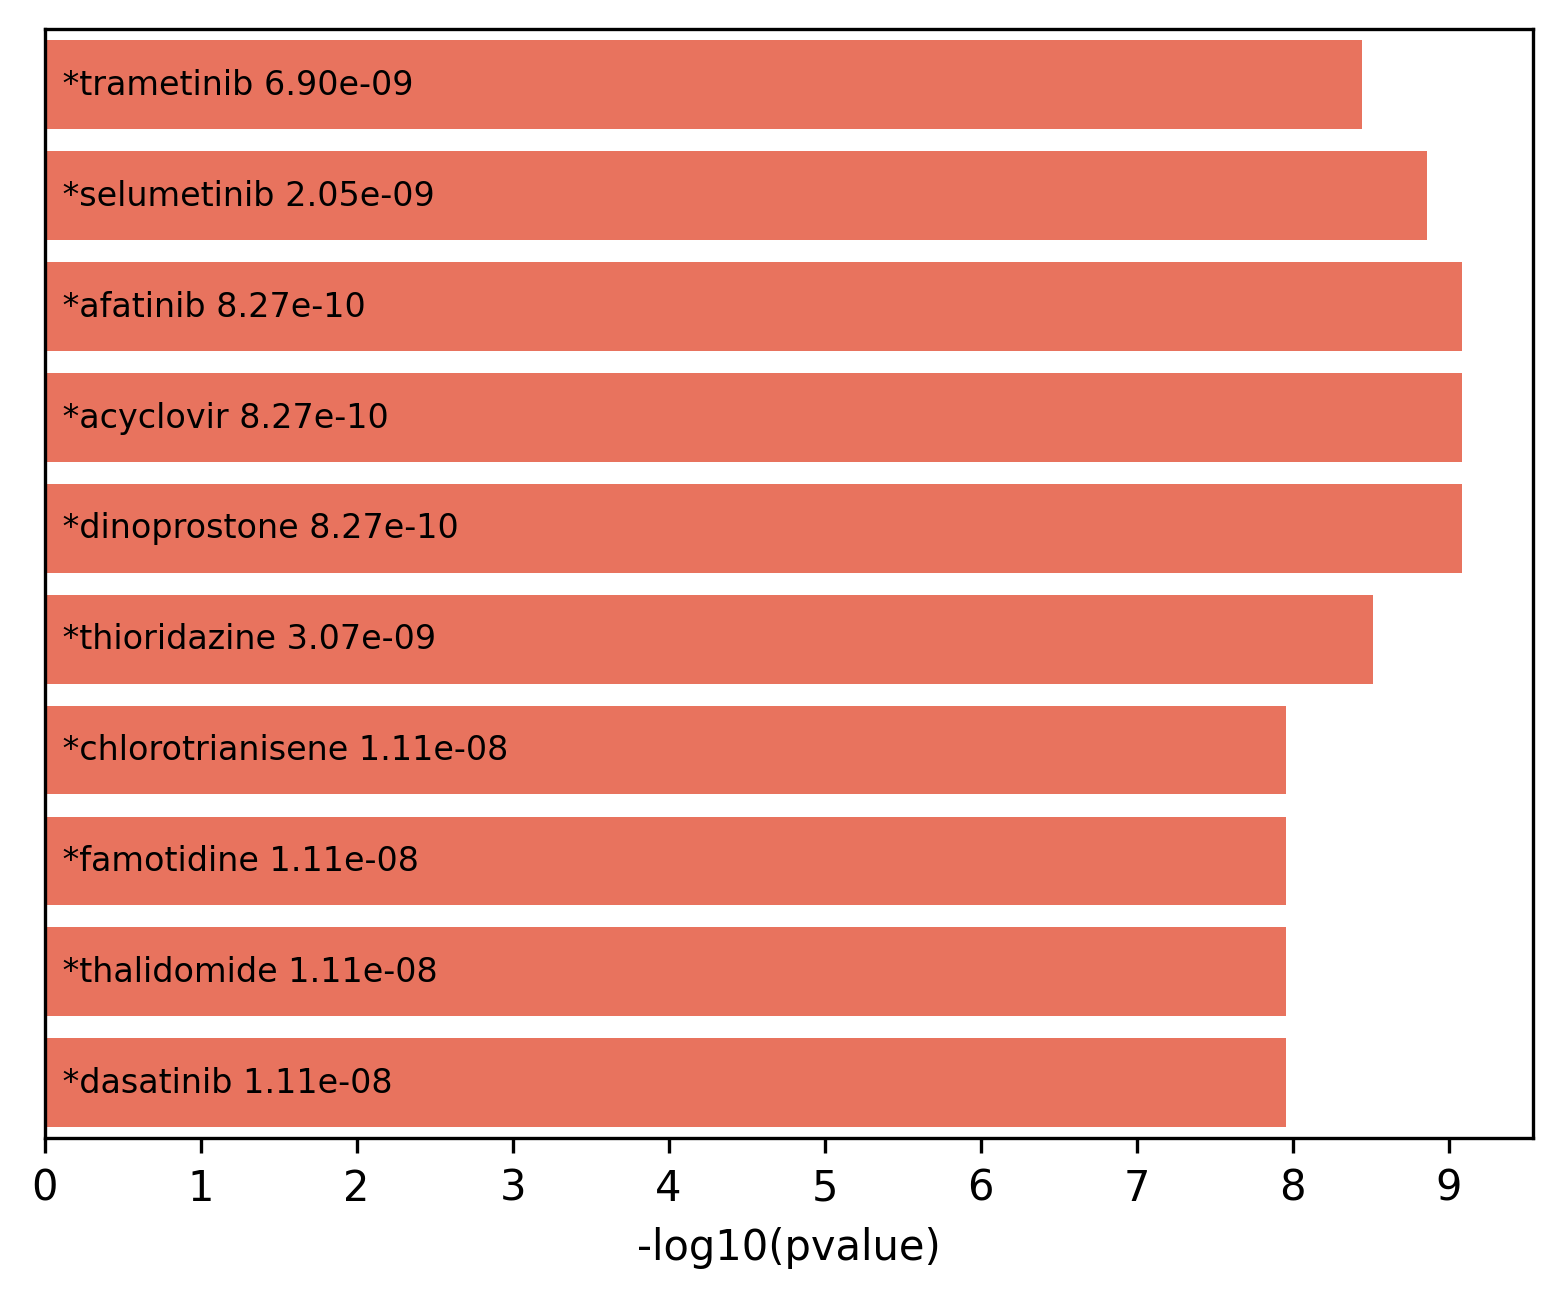

Figure 16: barplot representation depicting the -log10p values of the top FDA-approved l2s2_fda reversers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_l2s2_fda.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_l2s2_fda.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_l2s2_fda.jpeg

**l2s2_all**

perturbation                                            term  \
0      PD-0325901   LGR001_XC.L100.L_96H_H06_PD-0325901_0.04uM up   
1   BRD-K85051645        CPC007_MCF7_6H_M06_BRD-K85051645_10uM up   
2        BIIB-021    REP.A016_MDAMB231_24H_D22_BIIB-021_0.37uM up   
3      PD-0325901    LGR001_XC.L100.L_120H_H01_PD-0325901_10uM up   
4          XL-888         ASG003_XC.P908_24H_L14_XL-888_1.11uM up   
5      PD-0325901   LGR001_XC.L100.M_72H_H02_PD-0325901_3.33uM up   
6          XL-888         ASG003_XC.P907_24H_L14_XL-888_1.11uM up   
7      PD-0325901  LGR001_XC.L100.M_72H_H05_PD-0325901_0.125uM up   
8   BRD-K82710617       MOA001_A549_24H_G05_BRD-K82710617_10uM up   
9       SH3BP5 up             XPR014_U251MG.311_96H_E11_SH3BP5 up   
10  BRD-K26347562       MOA001_A549_24H_K21_BRD-K26347562_10uM up   
11     trametinib    PBIOA004_XC.L10_24H_K06_trametinib_2.22uM up   
12    vemurafenib   LJP005_MDAMB231_24H_C16_vemurafenib_0.37uM up   
13  BRD-K00824317         PAC004_U2OS_6H_B09_BRD-K00824317_4uM up   
14         AZ-628        LJP001_MDAMB231_24H_J12_AZ-628_0.08uM up   
15    TNFRSF1A up             XPR028_A549.311_96H_C03_TNFRSF1A up   
16     NVP-AUY922     ASG003_XC.P907_24H_M14_NVP-AUY922_1.11uM up   
17  BRD-K12244279   PBIOA015_A549_24H_K04_BRD-K12244279_0.37uM up   
18         PRIMA1              MOA001_A549_24H_I19_PRIMA1_10uM up   
19         AZ-628            ASG003_A549_48H_J14_AZ-628_1.11uM up   

    pvalueReverse  adjPvalueReverse  oddsRatioReverse  reverserOverlap  \
0        1.57e-13          2.63e-07          3.98e+00               42   
1        3.10e-12          2.60e-06          3.78e+00               40   
2        1.31e-11          4.41e-06          3.67e+00               39   
3        1.31e-11          4.41e-06          3.67e+00               39   
4        1.31e-11          4.41e-06          3.67e+00               39   
5        5.40e-11          8.24e-06          3.57e+00               38   
6        5.40e-11          8.24e-06          3.57e+00               38   
7        5.40e-11          8.24e-06          3.57e+00               38   
8        5.40e-11          8.24e-06          3.57e+00               38   
9        5.40e-11          8.24e-06          3.57e+00               38   
10       5.40e-11          8.24e-06          3.57e+00               38   
11       2.15e-10          1.64e-05          3.47e+00               37   
12       2.15e-10          1.64e-05          3.47e+00               37   
13       2.15e-10          1.64e-05          3.47e+00               37   
14       2.15e-10          1.64e-05          3.47e+00               37   
15       2.15e-10          1.64e-05          3.47e+00               37   
16       2.15e-10          1.64e-05          3.47e+00               37   
17       2.15e-10          1.64e-05          3.47e+00               37   
18       2.15e-10          1.64e-05          3.47e+00               37   
19       2.15e-10          1.64e-05          3.47e+00               37   

    approved  count  
0      False   3630  
1      False     58  
2      False    346  
3      False   3630  
4      False    878  
5      False   3630  
6      False    878  
7      False   3630  
8      False     16  
9      False    150  
10     False    196  
11      True   1552  
12     False   1862  
13     False     40  
14     False   1618  
15     False     84  
16     False   1158  
17     False    204  
18     False    218  
19     False   1618

Table 5: Ranked  LINCS L1000 signatures predicted to reverse the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_l2s2_all.tsv

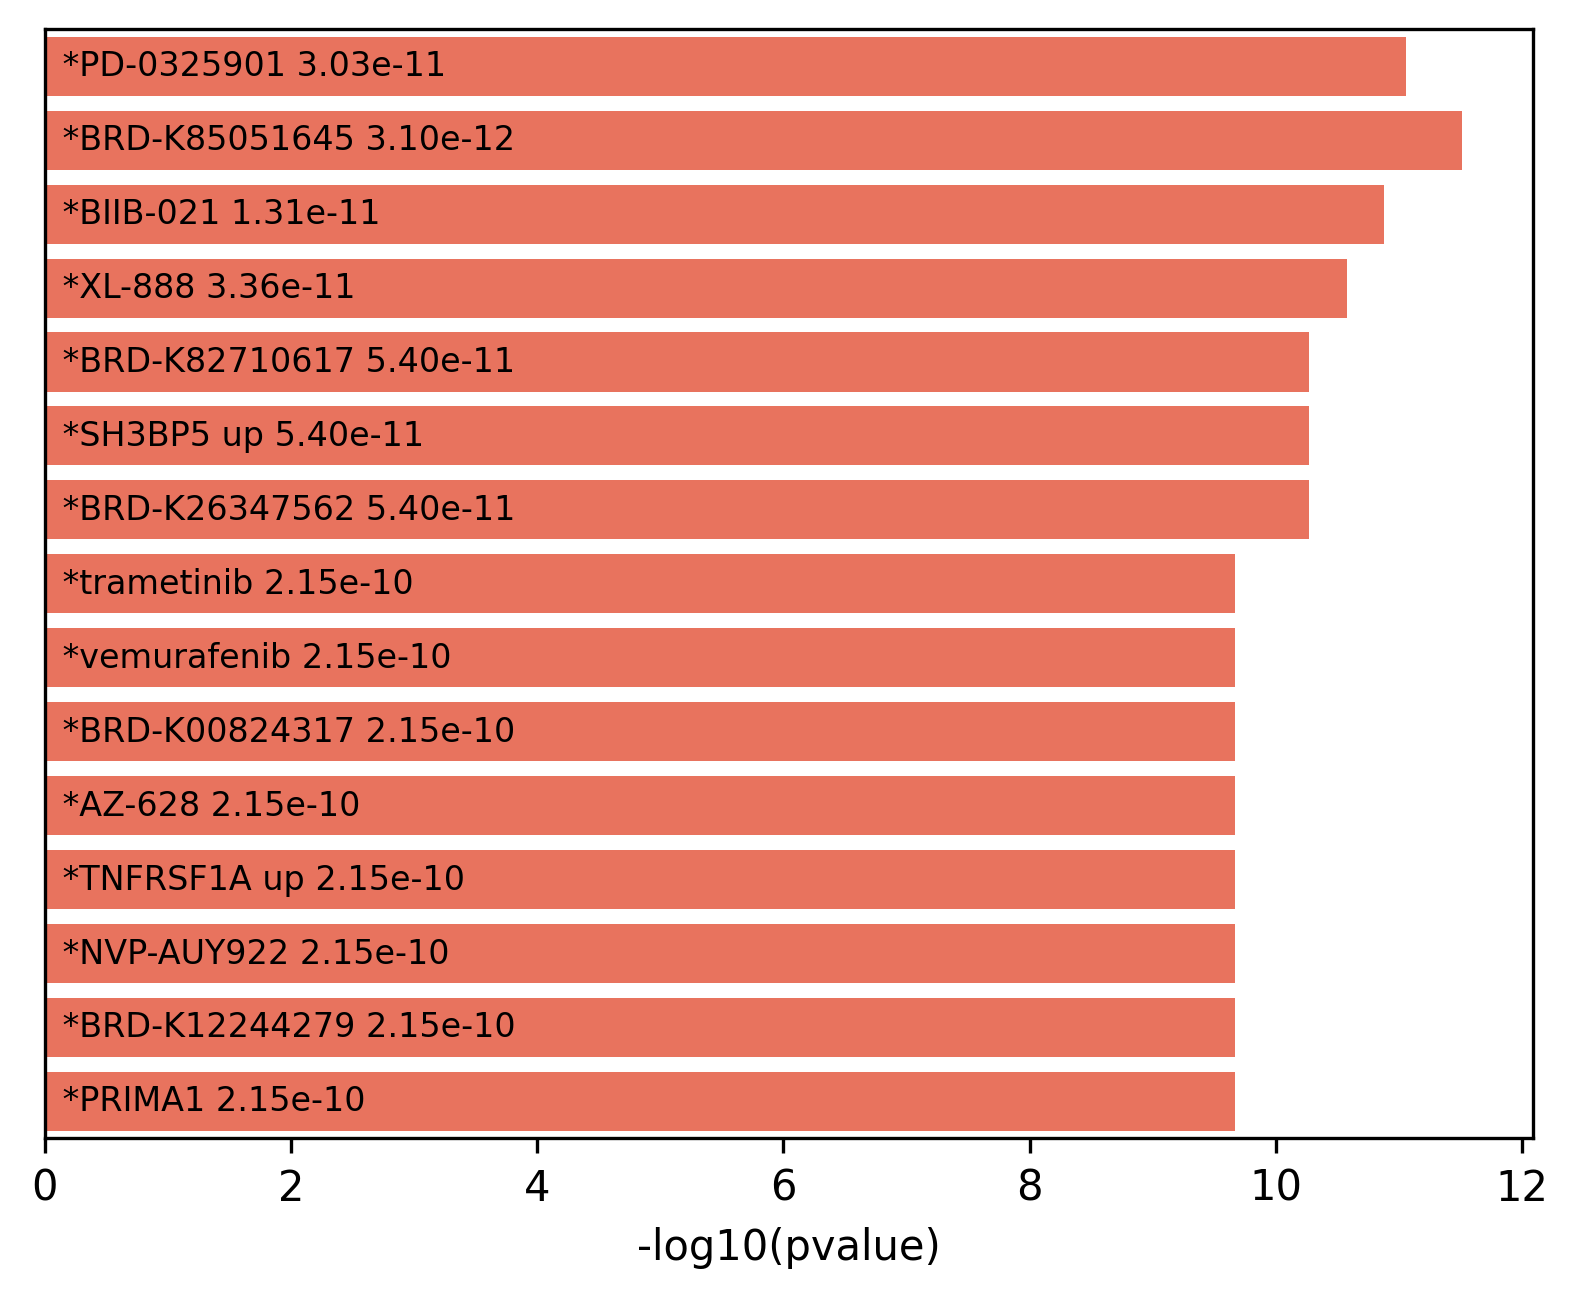

Figure 17: barplot representation depicting the -log10p values of the top  l2s2_all reversers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_l2s2_all.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_l2s2_all.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_l2s2_all.jpeg

**drugseqr_fda**

perturbation  \
0  omacetaxine mepesuccinate   
1  omacetaxine mepesuccinate   
2                  bosutinib   
3  omacetaxine mepesuccinate   
4               tirbanibulin   
5  omacetaxine mepesuccinate   
6  omacetaxine mepesuccinate   
7  omacetaxine mepesuccinate   
8               temozolomide   
9  omacetaxine mepesuccinate   

                                                term  pvalueReverse  \
0  Omacetaxine Mepesuccinate_EA-18-FP00_batchid28...       5.96e-02   
1  Omacetaxine Mepesuccinate_EA-18-FP00_batchid40...       1.97e-01   
2         Bosutinib_FA-10-SN61_batchid16_10uM_24h up       2.07e-01   
3  Omacetaxine Mepesuccinate_EA-18-FP00_batchid6_...       2.86e-01   
4      Tirbanibulin_AD-86-OB87_batchid6_0.1uM_24h up       3.74e-01   
5  Omacetaxine Mepesuccinate_EA-18-FP00_batchid3_...       4.34e-01   
6  Omacetaxine Mepesuccinate_EA-18-FP00_batchid16...       7.22e-01   
7  Omacetaxine Mepesuccinate_EA-18-FP00_batchid44...       8.30e-01   
8      Temozolomide_BA-92-YC70_batchid20_10uM_24h up       8.31e-01   
9  Omacetaxine Mepesuccinate_EA-18-FP00_batchid23...       9.21e-01   

   adjPvalueReverse  oddsRatioReverse  reverserOverlap  approved  count  
0                 1          1.58e+00               15      True    110  
1                 1          1.34e+00               12      True    110  
2                 1          1.37e+00               10      True      8  
3                 1          1.23e+00               12      True    110  
4                 1          1.15e+00               11      True      8  
5                 1          1.13e+00                7      True    110  
6                 1          8.27e-01                4      True    110  
7                 1          7.68e-01                8      True    110  
8                 1          5.72e-01                1      True      4  
9                 1          6.31e-01                6      True    110

Table 6: Ranked FDA-approved DRUG-seq signatures predicted to reverse the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_drugseqr_fda.tsv

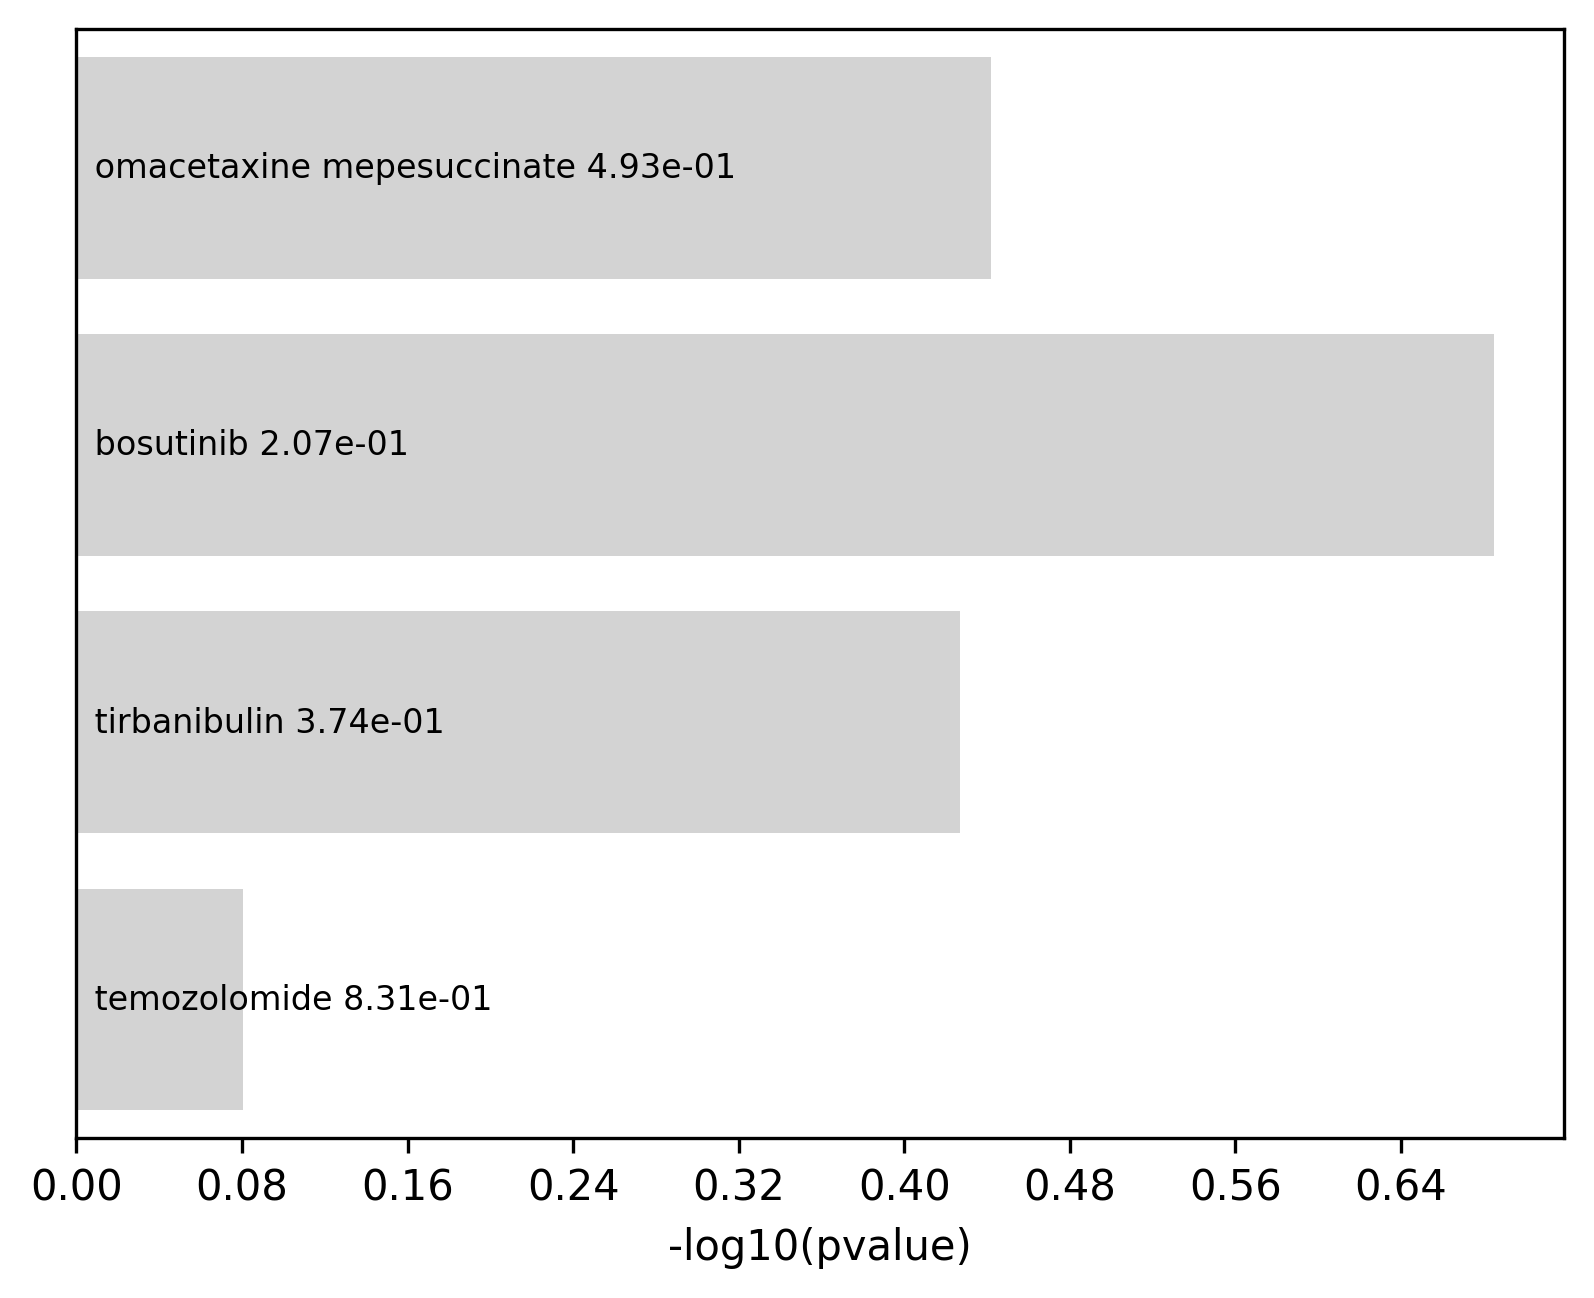

Figure 18: barplot representation depicting the -log10p values of the top FDA-approved drugseqr_fda reversers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_drugseqr_fda.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_drugseqr_fda.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_drugseqr_fda.jpeg

**drugseqr_all**

perturbation  \
0   omacetaxine mepesuccinate   
1              cephalochromin   
2                    24995756   
3                      tp-472   
4                               
5   omacetaxine mepesuccinate   
6                   bosutinib   
7                     pik-iii   
8   omacetaxine mepesuccinate   
9            pi4kiiibeta-in-9   
10                   tx1-85-1   
11    cathepsin g inhibitor i   
12               tirbanibulin   
13  omacetaxine mepesuccinate   
14                              
15                              
16                              
17                 mefloquine   
18                              
19                   46184988   

                                                 term  pvalueReverse  \
0   Omacetaxine Mepesuccinate_EA-18-FP00_batchid28...       5.96e-02   
1     Cephalochromin_QA-14-AU91_batchid40_10uM_24h up       1.13e-01   
2           24995756_CE-03-YQ91_batchid16_10uM_24h up       1.20e-01   
3             TP-472_HB-87-YY34_batchid28_10uM_24h up       1.63e-01   
4                   _HB-92-PE54_batchid52_10uM_24h up       1.91e-01   
5   Omacetaxine Mepesuccinate_EA-18-FP00_batchid40...       1.97e-01   
6          Bosutinib_FA-10-SN61_batchid16_10uM_24h up       2.07e-01   
7            Pik-III_EB-47-BB89_batchid16_10uM_24h up       2.12e-01   
8   Omacetaxine Mepesuccinate_EA-18-FP00_batchid6_...       2.86e-01   
9   PI4KIIIbeta-IN-9_PD-71-MW24_batchid24_10uM_24h up       3.09e-01   
10          TX1-85-1_S0-EE-YMWJ_batchid32_10uM_24h up       3.33e-01   
11  Cathepsin G Inhibitor I_PD-60-FM93_batchid16_1...       3.63e-01   
12      Tirbanibulin_AD-86-OB87_batchid6_0.1uM_24h up       3.74e-01   
13  Omacetaxine Mepesuccinate_EA-18-FP00_batchid3_...       4.34e-01   
14                  _BD-11-DV28_batchid32_10uM_24h up       4.76e-01   
15                  _BD-11-DV28_batchid48_10uM_24h up       4.88e-01   
16                  _BD-11-DV28_batchid33_10uM_24h up       5.17e-01   
17        Mefloquine_FA-16-HR75_batchid16_10uM_24h up       5.20e-01   
18                  _BD-11-DV28_batchid29_10uM_24h up       5.25e-01   
19          46184988_DE-69-QQ25_batchid32_10uM_24h up       5.90e-01   

    adjPvalueReverse  oddsRatioReverse  reverserOverlap  approved  count  
0                  1          1.58e+00               15      True    110  
1                  1          1.37e+00               19     False      5  
2                  1          1.49e+00               12     False      6  
3                  1          1.59e+00                7     False      7  
4                  1          1.80e+00                4     False      8  
5                  1          1.34e+00               12      True    110  
6                  1          1.37e+00               10      True      8  
7                  1          1.93e+00                3     False      7  
8                  1          1.23e+00               12      True    110  
9                  1          1.33e+00                6     False      7  
10                 1          1.29e+00                6     False      6  
11                 1          1.20e+00                8     False      7  
12                 1          1.15e+00               11      True      8  
13                 1          1.13e+00                7      True    110  
14                 1          1.12e+00                5     False    104  
15                 1          1.10e+00                5     False    104  
16                 1          1.04e+00                8     False    104  
17                 1          1.04e+00                7     False      8  
18                 1          1.03e+00               10     False    104  
19                 1          9.75e-01               11     False      5

Table 7: Ranked  DRUG-seq signatures predicted to reverse the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_drugseqr_all.tsv

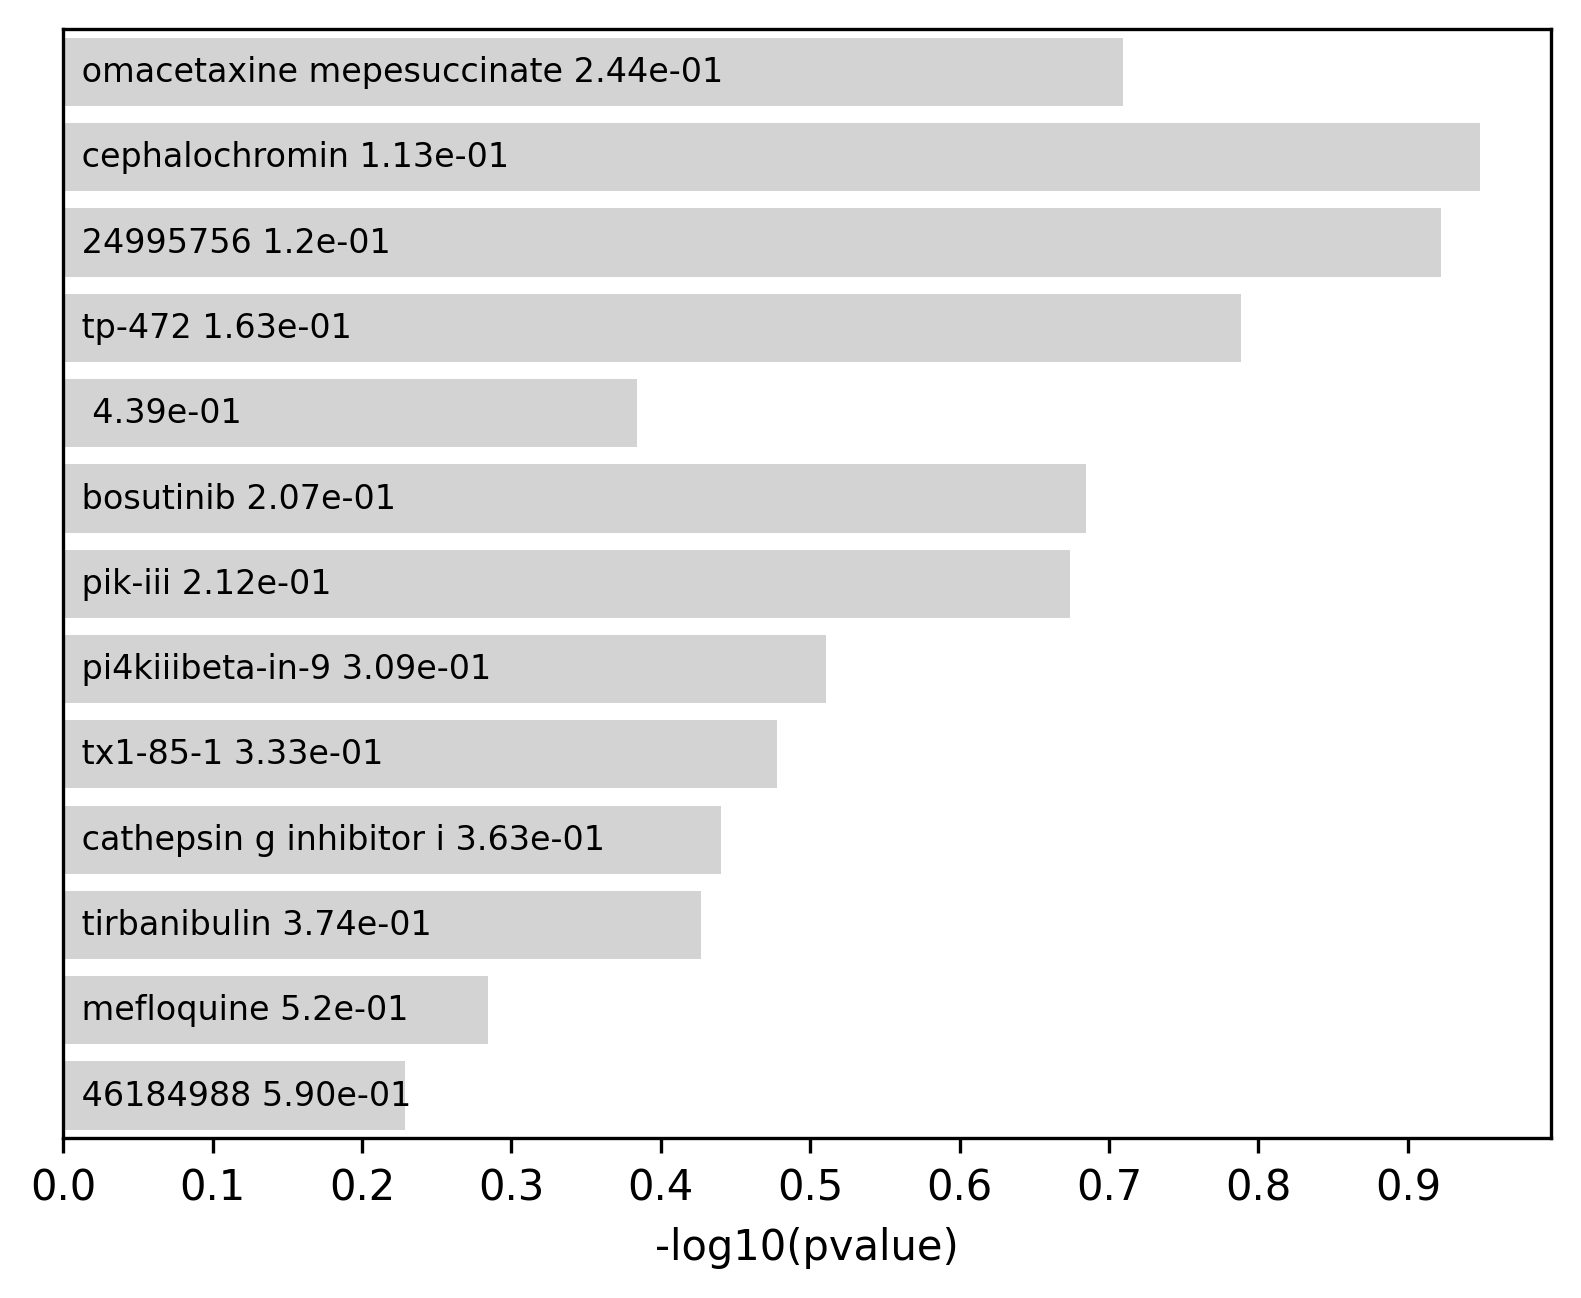

Figure 19: barplot representation depicting the -log10p values of the top  drugseqr_all reversers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_drugseqr_all.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_drugseqr_all.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_reversers_drugseqr_all.jpeg

---

#### **cells dmso h rep-vs-cells rsl h rep**

**l2s2_fda**

perturbation                                          term  \
0         trametinib  PBIOA004_XC.L10_24H_K06_trametinib_2.22uM up   
1        selumetinib    ASG003_XC.P909_24H_E04_selumetinib_10uM up   
2           afatinib     ASG003_XC.P914_24H_M20_afatinib_1.11uM up   
3          acyclovir     REP.A008_MCF7_24H_E06_acyclovir_0.04uM up   
4        selumetinib     REP.A015_A375_24H_E19_selumetinib_10uM up   
5         trametinib    PBIOA004_XC.R10_24H_K04_trametinib_20uM up   
6       dinoprostone  FIBR026_MCLF141SZ_6H_M12_dinoprostone_4uM up   
7        selumetinib  ASG003_XC.P091_24H_E05_selumetinib_1.11uM up   
8        selumetinib       LJP006_A549_24H_M07_selumetinib_10uM up   
9         trametinib   ASG003_XC.P911_24H_N18_trametinib_0.12uM up   
10      thioridazine     CPC006_HCC515_6H_G23_thioridazine_10uM up   
11       selumetinib      LKCP001_A549_24H_J10_selumetinib_10uM up   
12        trametinib    PBIOA004_XC.L10_24H_K04_trametinib_20uM up   
13  chlorotrianisene   PAC003_U2OS_6H_F14_chlorotrianisene_10uM up   
14        trametinib   ASG003_XC.P909_24H_N18_trametinib_0.12uM up   
15        trametinib  ASG002_NCIH1573_24H_G09_trametinib_0.12uM up   
16        famotidine         PAC004_U2OS_6H_B06_famotidine_10uM up   
17        trametinib    LCP001_MCF10A.WT_3H_D16_trametinib_10uM up   
18       thalidomide        CPC006_A549_6H_E14_thalidomide_10uM up   
19         dasatinib       LJP007_HT29_24H_G14_dasatinib_3.33uM up   

    pvalueReverse  adjPvalueReverse  oddsRatioReverse  reverserOverlap  \
0        2.15e-10          1.64e-05          3.47e+00               37   
1        2.15e-10          1.64e-05          3.47e+00               37   
2        8.27e-10          3.22e-05          3.37e+00               36   
3        8.27e-10          3.22e-05          3.37e+00               36   
4        8.27e-10          3.22e-05          3.37e+00               36   
5        8.27e-10          3.22e-05          3.37e+00               36   
6        8.27e-10          3.22e-05          3.37e+00               36   
7        3.07e-09          7.16e-05          3.27e+00               35   
8        3.07e-09          7.16e-05          3.27e+00               35   
9        3.07e-09          7.16e-05          3.27e+00               35   
10       3.07e-09          7.16e-05          3.27e+00               35   
11       3.07e-09          7.16e-05          3.27e+00               35   
12       1.11e-08          1.47e-04          3.17e+00               34   
13       1.11e-08          1.47e-04          3.17e+00               34   
14       1.11e-08          1.47e-04          3.17e+00               34   
15       1.11e-08          1.47e-04          3.17e+00               34   
16       1.11e-08          1.47e-04          3.17e+00               34   
17       1.11e-08          1.47e-04          3.17e+00               34   
18       1.11e-08          1.47e-04          3.17e+00               34   
19       1.11e-08          1.47e-04          3.17e+00               34   

    approved  count  
0       True   1552  
1       True   2242  
2       True   2348  
3       True    290  
4       True   2242  
5       True   1552  
6       True    138  
7       True   2242  
8       True   2242  
9       True   1552  
10      True   1444  
11      True   2242  
12      True   1552  
13      True     28  
14      True   1552  
15      True   1552  
16      True    332  
17      True   1552  
18      True    850  
19      True   3026

Table 8: Ranked FDA-approved LINCS L1000 signatures predicted to reverse the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_l2s2_fda.tsv

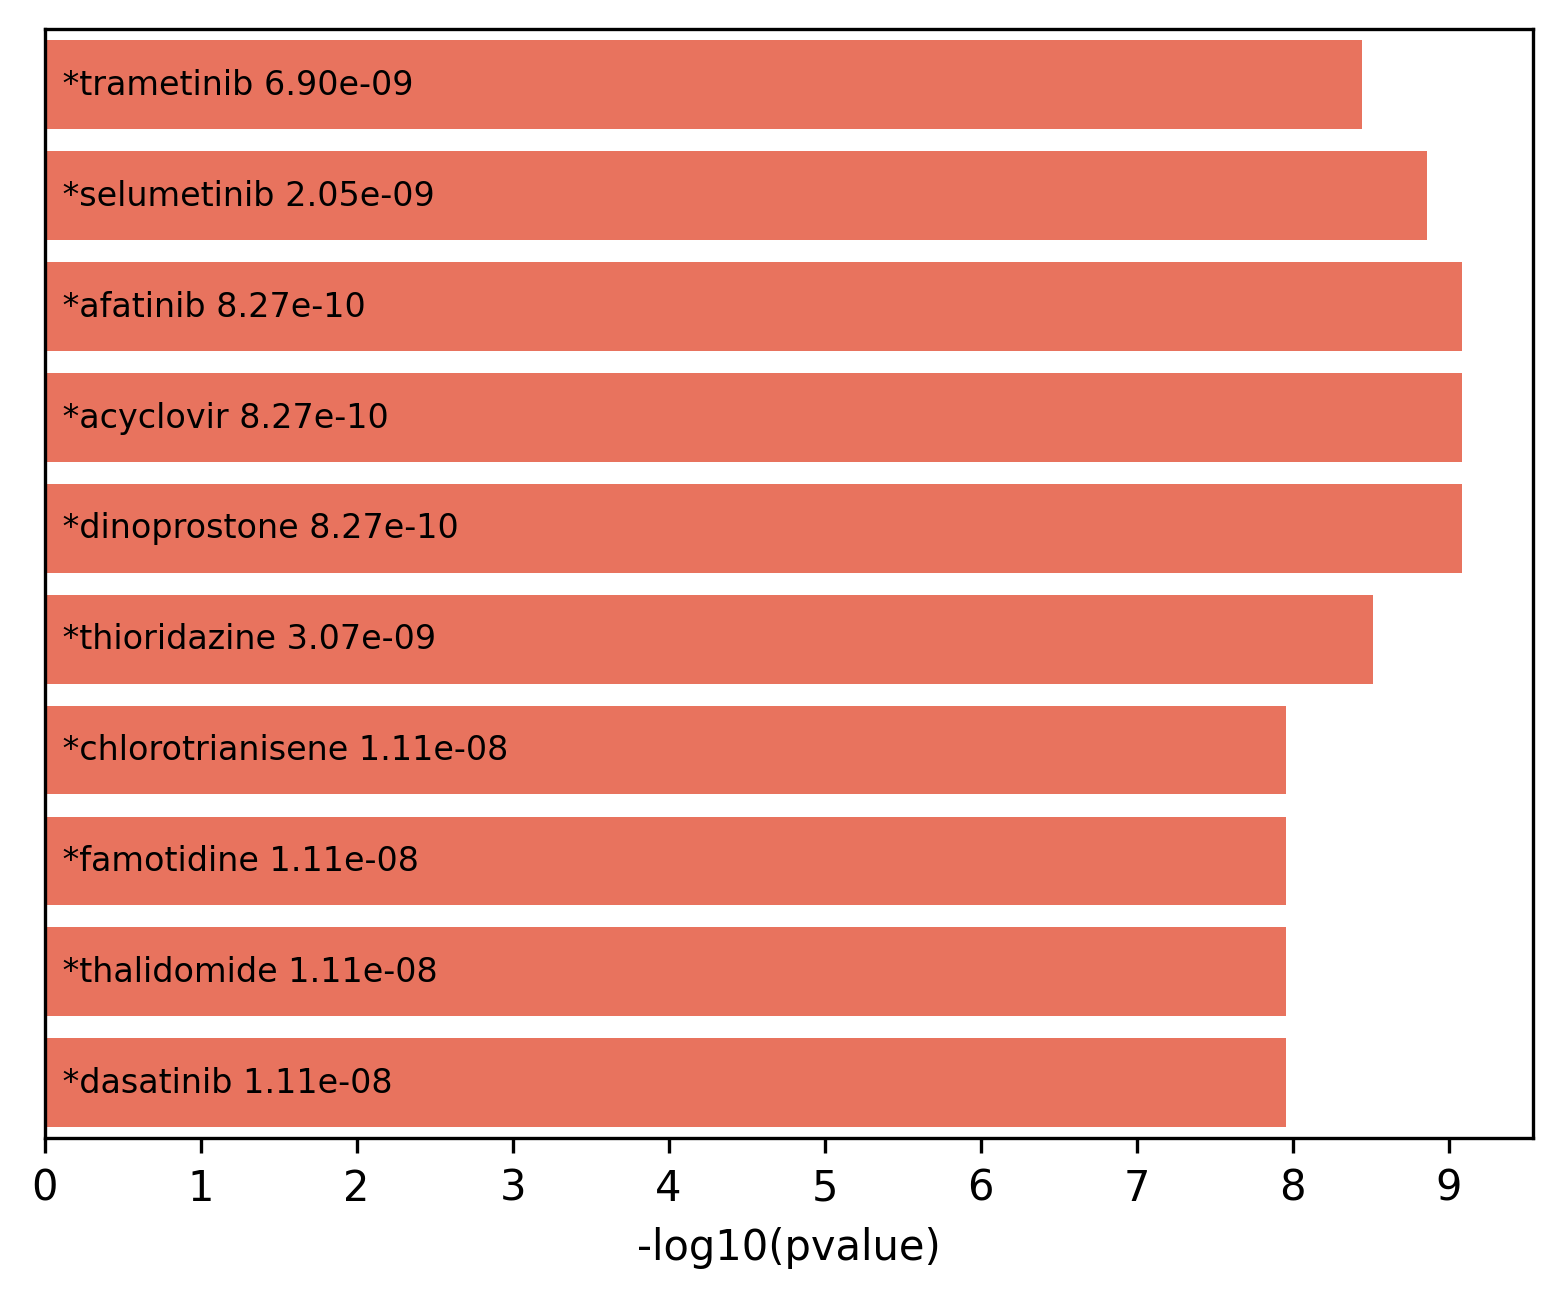

Figure 20: barplot representation depicting the -log10p values of the top FDA-approved l2s2_fda reversers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_l2s2_fda.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_l2s2_fda.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_l2s2_fda.jpeg

**l2s2_all**

perturbation                                            term  \
0      PD-0325901   LGR001_XC.L100.L_96H_H06_PD-0325901_0.04uM up   
1   BRD-K85051645        CPC007_MCF7_6H_M06_BRD-K85051645_10uM up   
2        BIIB-021    REP.A016_MDAMB231_24H_D22_BIIB-021_0.37uM up   
3      PD-0325901    LGR001_XC.L100.L_120H_H01_PD-0325901_10uM up   
4          XL-888         ASG003_XC.P908_24H_L14_XL-888_1.11uM up   
5      PD-0325901   LGR001_XC.L100.M_72H_H02_PD-0325901_3.33uM up   
6          XL-888         ASG003_XC.P907_24H_L14_XL-888_1.11uM up   
7      PD-0325901  LGR001_XC.L100.M_72H_H05_PD-0325901_0.125uM up   
8   BRD-K82710617       MOA001_A549_24H_G05_BRD-K82710617_10uM up   
9       SH3BP5 up             XPR014_U251MG.311_96H_E11_SH3BP5 up   
10  BRD-K26347562       MOA001_A549_24H_K21_BRD-K26347562_10uM up   
11     trametinib    PBIOA004_XC.L10_24H_K06_trametinib_2.22uM up   
12    vemurafenib   LJP005_MDAMB231_24H_C16_vemurafenib_0.37uM up   
13  BRD-K00824317         PAC004_U2OS_6H_B09_BRD-K00824317_4uM up   
14         AZ-628        LJP001_MDAMB231_24H_J12_AZ-628_0.08uM up   
15    TNFRSF1A up             XPR028_A549.311_96H_C03_TNFRSF1A up   
16     NVP-AUY922     ASG003_XC.P907_24H_M14_NVP-AUY922_1.11uM up   
17  BRD-K12244279   PBIOA015_A549_24H_K04_BRD-K12244279_0.37uM up   
18         PRIMA1              MOA001_A549_24H_I19_PRIMA1_10uM up   
19         AZ-628            ASG003_A549_48H_J14_AZ-628_1.11uM up   

    pvalueReverse  adjPvalueReverse  oddsRatioReverse  reverserOverlap  \
0        1.57e-13          2.63e-07          3.98e+00               42   
1        3.10e-12          2.60e-06          3.78e+00               40   
2        1.31e-11          4.41e-06          3.67e+00               39   
3        1.31e-11          4.41e-06          3.67e+00               39   
4        1.31e-11          4.41e-06          3.67e+00               39   
5        5.40e-11          8.24e-06          3.57e+00               38   
6        5.40e-11          8.24e-06          3.57e+00               38   
7        5.40e-11          8.24e-06          3.57e+00               38   
8        5.40e-11          8.24e-06          3.57e+00               38   
9        5.40e-11          8.24e-06          3.57e+00               38   
10       5.40e-11          8.24e-06          3.57e+00               38   
11       2.15e-10          1.64e-05          3.47e+00               37   
12       2.15e-10          1.64e-05          3.47e+00               37   
13       2.15e-10          1.64e-05          3.47e+00               37   
14       2.15e-10          1.64e-05          3.47e+00               37   
15       2.15e-10          1.64e-05          3.47e+00               37   
16       2.15e-10          1.64e-05          3.47e+00               37   
17       2.15e-10          1.64e-05          3.47e+00               37   
18       2.15e-10          1.64e-05          3.47e+00               37   
19       2.15e-10          1.64e-05          3.47e+00               37   

    approved  count  
0      False   3630  
1      False     58  
2      False    346  
3      False   3630  
4      False    878  
5      False   3630  
6      False    878  
7      False   3630  
8      False     16  
9      False    150  
10     False    196  
11      True   1552  
12     False   1862  
13     False     40  
14     False   1618  
15     False     84  
16     False   1158  
17     False    204  
18     False    218  
19     False   1618

Table 9: Ranked  LINCS L1000 signatures predicted to reverse the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_l2s2_all.tsv

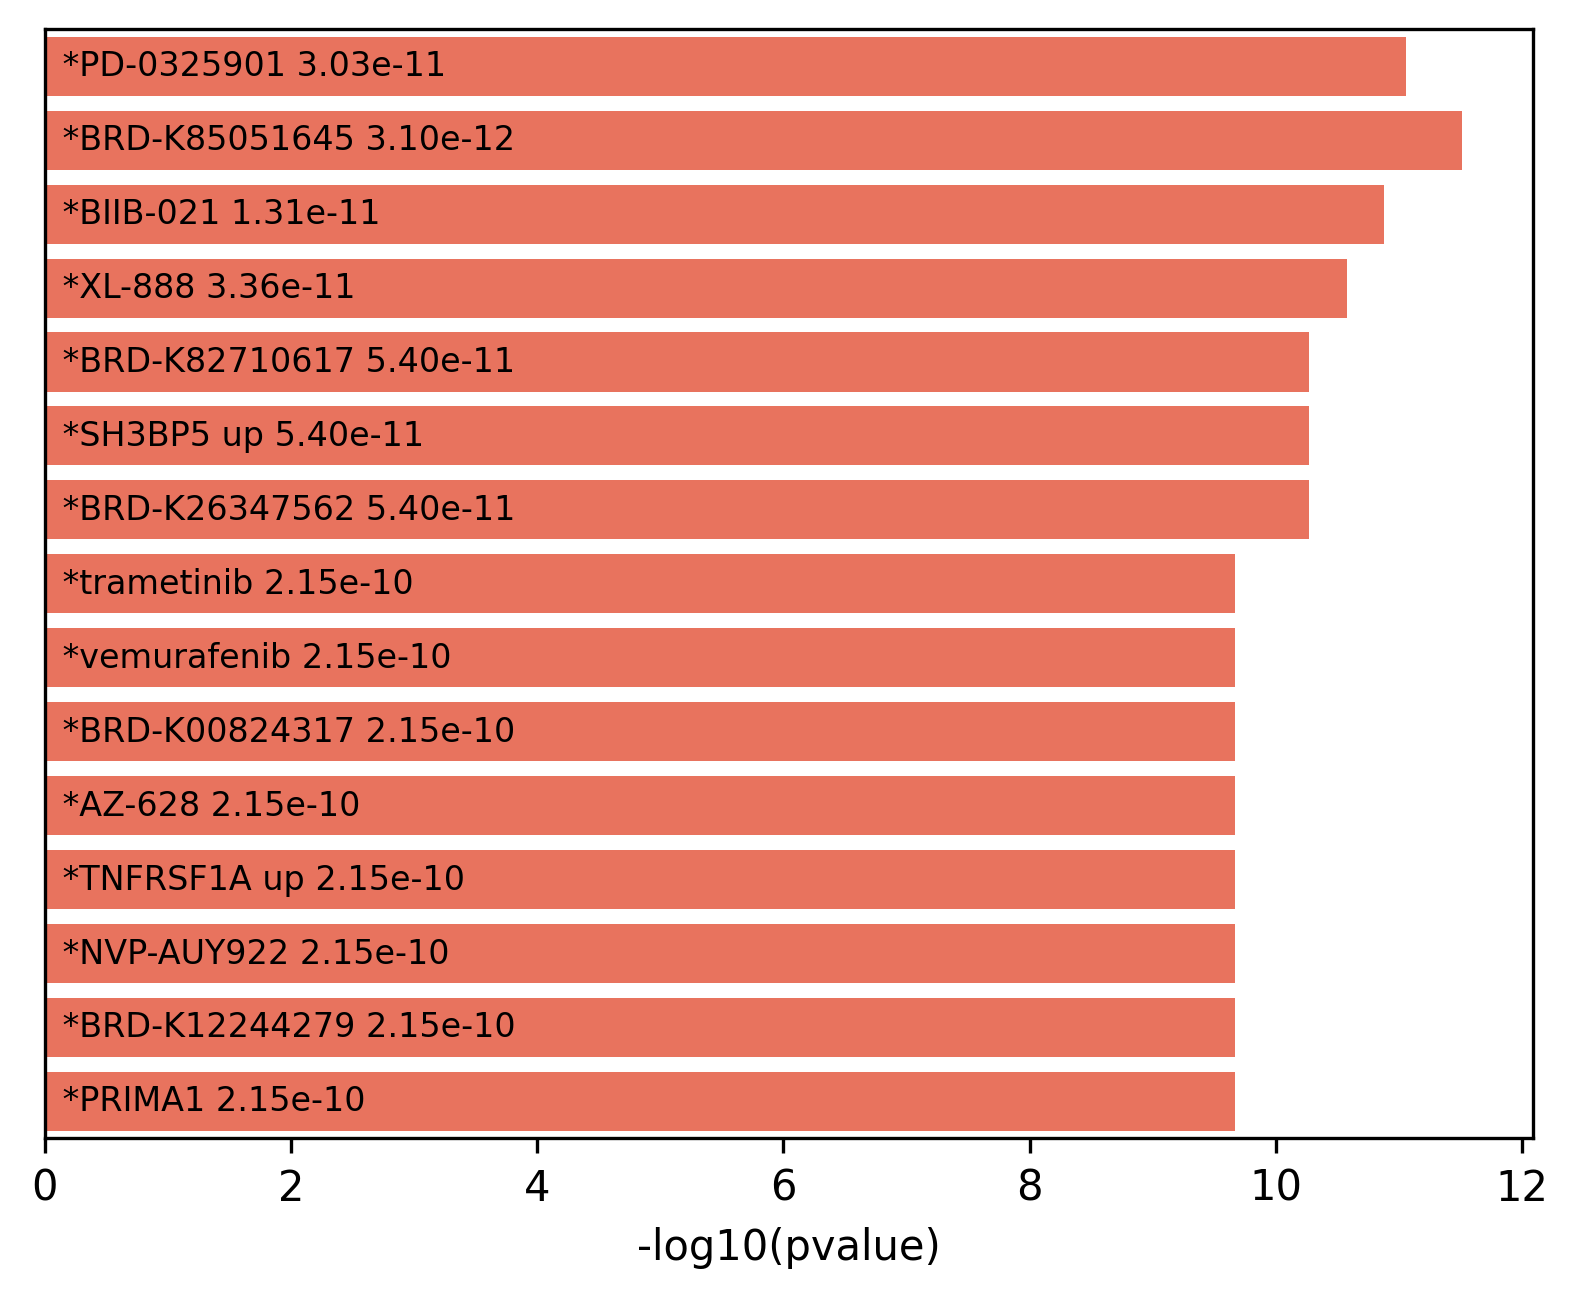

Figure 21: barplot representation depicting the -log10p values of the top  l2s2_all reversers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_l2s2_all.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_l2s2_all.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_l2s2_all.jpeg

**drugseqr_fda**

perturbation  \
0  omacetaxine mepesuccinate   
1  omacetaxine mepesuccinate   
2                  bosutinib   
3  omacetaxine mepesuccinate   
4               tirbanibulin   
5  omacetaxine mepesuccinate   
6  omacetaxine mepesuccinate   
7  omacetaxine mepesuccinate   
8               temozolomide   
9  omacetaxine mepesuccinate   

                                                term  pvalueReverse  \
0  Omacetaxine Mepesuccinate_EA-18-FP00_batchid28...       5.96e-02   
1  Omacetaxine Mepesuccinate_EA-18-FP00_batchid40...       1.97e-01   
2         Bosutinib_FA-10-SN61_batchid16_10uM_24h up       2.07e-01   
3  Omacetaxine Mepesuccinate_EA-18-FP00_batchid6_...       2.86e-01   
4      Tirbanibulin_AD-86-OB87_batchid6_0.1uM_24h up       3.74e-01   
5  Omacetaxine Mepesuccinate_EA-18-FP00_batchid3_...       4.34e-01   
6  Omacetaxine Mepesuccinate_EA-18-FP00_batchid16...       7.22e-01   
7  Omacetaxine Mepesuccinate_EA-18-FP00_batchid44...       8.30e-01   
8      Temozolomide_BA-92-YC70_batchid20_10uM_24h up       8.31e-01   
9  Omacetaxine Mepesuccinate_EA-18-FP00_batchid23...       9.21e-01   

   adjPvalueReverse  oddsRatioReverse  reverserOverlap  approved  count  
0                 1          1.58e+00               15      True    110  
1                 1          1.34e+00               12      True    110  
2                 1          1.37e+00               10      True      8  
3                 1          1.23e+00               12      True    110  
4                 1          1.15e+00               11      True      8  
5                 1          1.13e+00                7      True    110  
6                 1          8.27e-01                4      True    110  
7                 1          7.68e-01                8      True    110  
8                 1          5.72e-01                1      True      4  
9                 1          6.31e-01                6      True    110

Table 10: Ranked FDA-approved DRUG-seq signatures predicted to reverse the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_drugseqr_fda.tsv

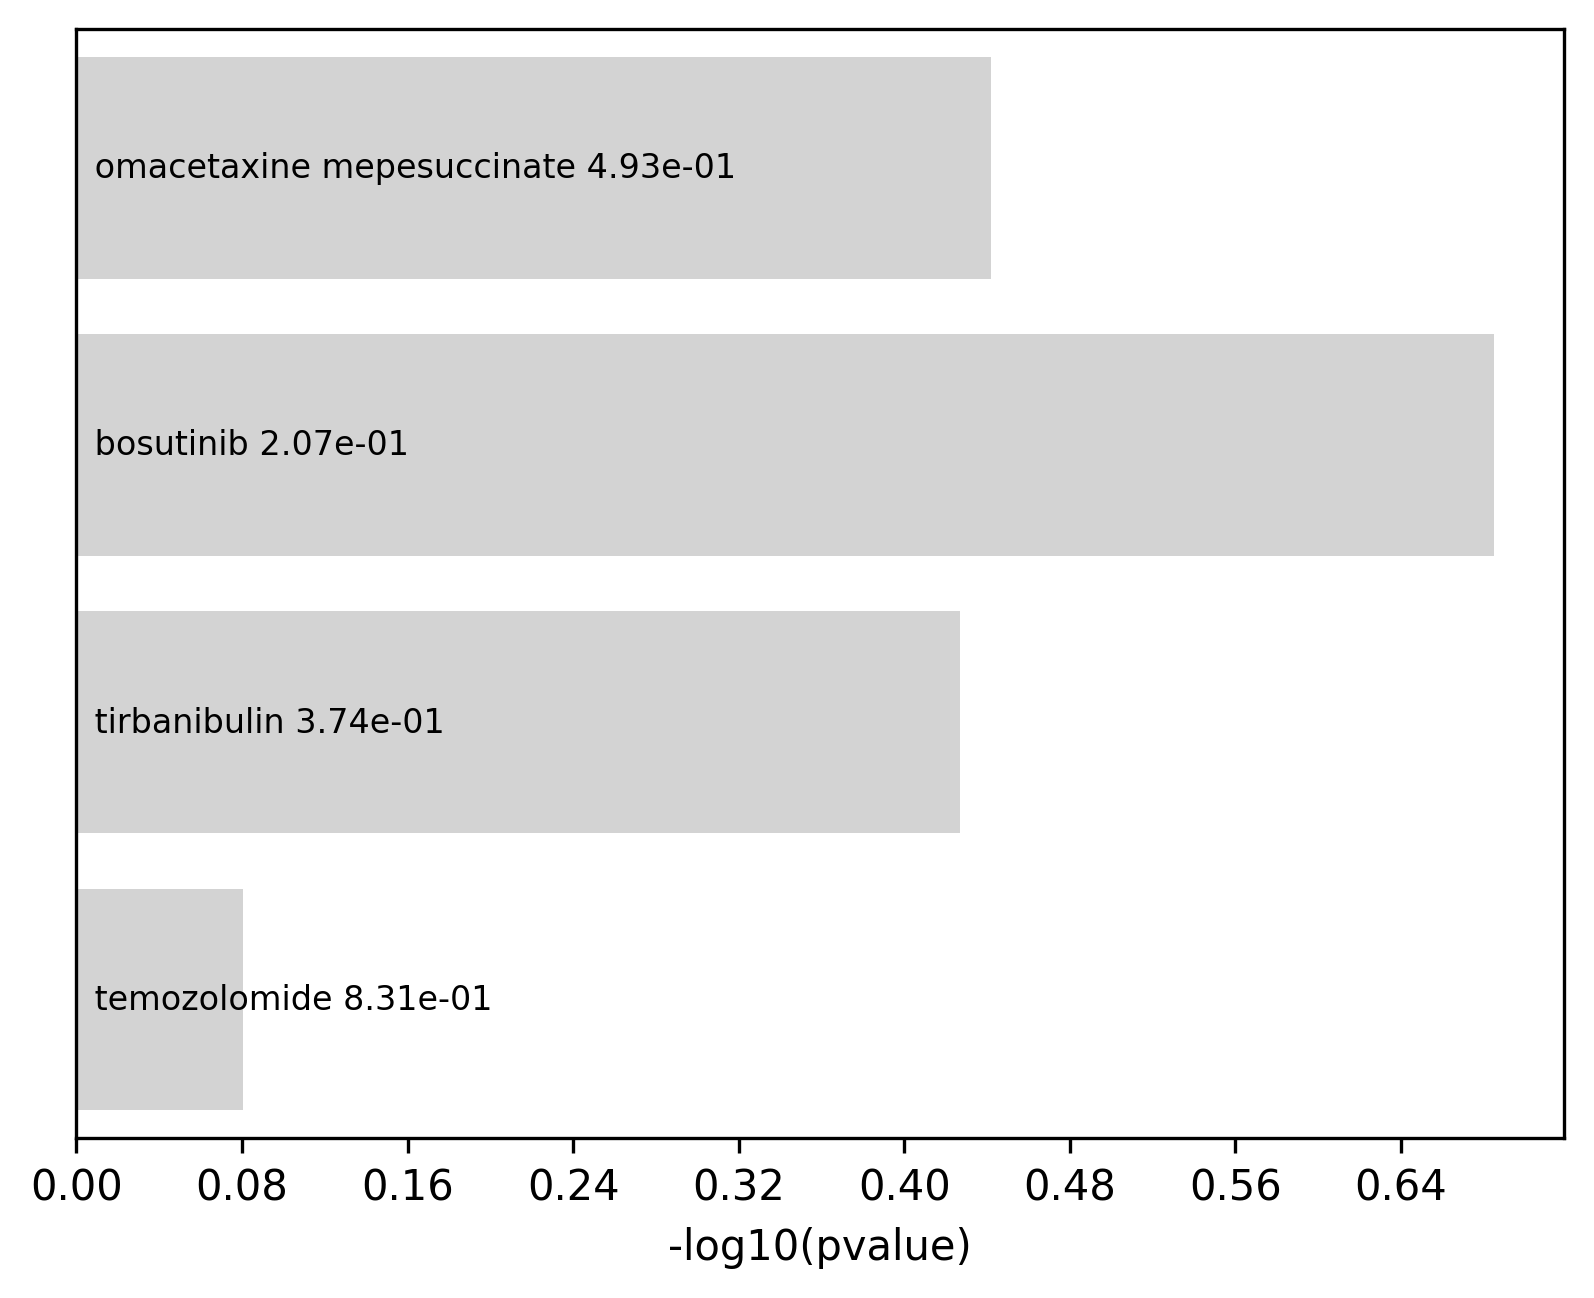

Figure 22: barplot representation depicting the -log10p values of the top FDA-approved drugseqr_fda reversers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_drugseqr_fda.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_drugseqr_fda.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_drugseqr_fda.jpeg

**drugseqr_all**

perturbation  \
0   omacetaxine mepesuccinate   
1              cephalochromin   
2                    24995756   
3                      tp-472   
4                               
5   omacetaxine mepesuccinate   
6                   bosutinib   
7                     pik-iii   
8   omacetaxine mepesuccinate   
9            pi4kiiibeta-in-9   
10                   tx1-85-1   
11    cathepsin g inhibitor i   
12               tirbanibulin   
13  omacetaxine mepesuccinate   
14                              
15                              
16                              
17                 mefloquine   
18                              
19                   46184988   

                                                 term  pvalueReverse  \
0   Omacetaxine Mepesuccinate_EA-18-FP00_batchid28...       5.96e-02   
1     Cephalochromin_QA-14-AU91_batchid40_10uM_24h up       1.13e-01   
2           24995756_CE-03-YQ91_batchid16_10uM_24h up       1.20e-01   
3             TP-472_HB-87-YY34_batchid28_10uM_24h up       1.63e-01   
4                   _HB-92-PE54_batchid52_10uM_24h up       1.91e-01   
5   Omacetaxine Mepesuccinate_EA-18-FP00_batchid40...       1.97e-01   
6          Bosutinib_FA-10-SN61_batchid16_10uM_24h up       2.07e-01   
7            Pik-III_EB-47-BB89_batchid16_10uM_24h up       2.12e-01   
8   Omacetaxine Mepesuccinate_EA-18-FP00_batchid6_...       2.86e-01   
9   PI4KIIIbeta-IN-9_PD-71-MW24_batchid24_10uM_24h up       3.09e-01   
10          TX1-85-1_S0-EE-YMWJ_batchid32_10uM_24h up       3.33e-01   
11  Cathepsin G Inhibitor I_PD-60-FM93_batchid16_1...       3.63e-01   
12      Tirbanibulin_AD-86-OB87_batchid6_0.1uM_24h up       3.74e-01   
13  Omacetaxine Mepesuccinate_EA-18-FP00_batchid3_...       4.34e-01   
14                  _BD-11-DV28_batchid32_10uM_24h up       4.76e-01   
15                  _BD-11-DV28_batchid48_10uM_24h up       4.88e-01   
16                  _BD-11-DV28_batchid33_10uM_24h up       5.17e-01   
17        Mefloquine_FA-16-HR75_batchid16_10uM_24h up       5.20e-01   
18                  _BD-11-DV28_batchid29_10uM_24h up       5.25e-01   
19          46184988_DE-69-QQ25_batchid32_10uM_24h up       5.90e-01   

    adjPvalueReverse  oddsRatioReverse  reverserOverlap  approved  count  
0                  1          1.58e+00               15      True    110  
1                  1          1.37e+00               19     False      5  
2                  1          1.49e+00               12     False      6  
3                  1          1.59e+00                7     False      7  
4                  1          1.80e+00                4     False      8  
5                  1          1.34e+00               12      True    110  
6                  1          1.37e+00               10      True      8  
7                  1          1.93e+00                3     False      7  
8                  1          1.23e+00               12      True    110  
9                  1          1.33e+00                6     False      7  
10                 1          1.29e+00                6     False      6  
11                 1          1.20e+00                8     False      7  
12                 1          1.15e+00               11      True      8  
13                 1          1.13e+00                7      True    110  
14                 1          1.12e+00                5     False    104  
15                 1          1.10e+00                5     False    104  
16                 1          1.04e+00                8     False    104  
17                 1          1.04e+00                7     False      8  
18                 1          1.03e+00               10     False    104  
19                 1          9.75e-01               11     False      5

Table 11: Ranked  DRUG-seq signatures predicted to reverse the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_drugseqr_all.tsv

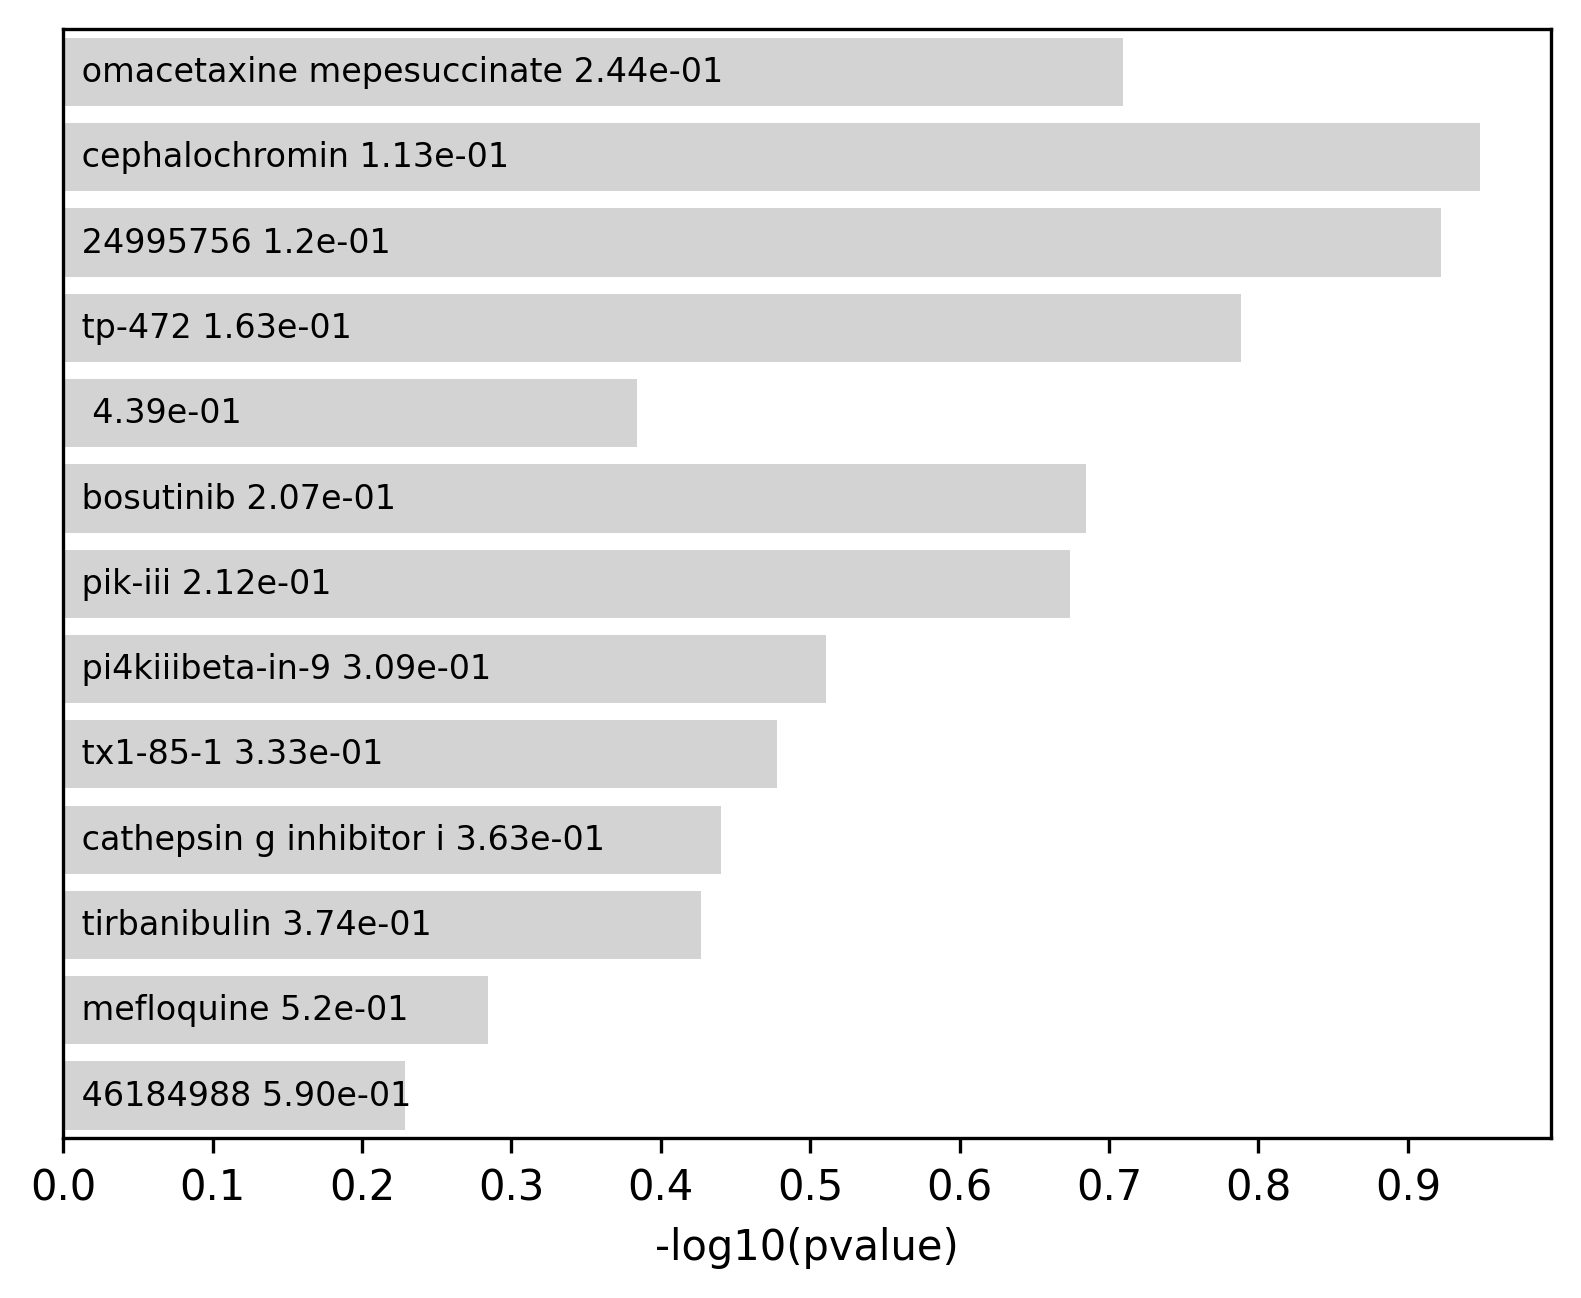

Figure 23: barplot representation depicting the -log10p values of the top  drugseqr_all reversers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_drugseqr_all.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_drugseqr_all.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_reversers_drugseqr_all.jpeg

---

In [70]:
from python_scripts.druganalysis import druganalysis

dbs = ['l2s2_fda', 'l2s2_all', 'drugseqr_fda', 'drugseqr_all']

for sig_name in sig_names_clean:
    # up_genes_t500 = upreg_t500[sig_name]
    # down_genes_t500 = downreg_t500[sig_name]
    up_genes = upreg[sig_name]
    down_genes = upreg[sig_name]
    
    rev_drugs = druganalysis(geneset=up_genes_t500, geneset_dn=down_genes_t500, direction="reversers", save_path=resource_path, save_name=sig_name, tab_num=tab_num, fig_num=fig_num)
    display(Markdown(f"#### **{sig_name}**"))
    
    for db in dbs:
        display(Markdown(f"**{db}**"))
        try:
            rev_drugs.display_table(db=db)
            rev_drugs.display_barplot(db=db, save_path=resource_path, save_formats=save_formats)
        except ValueError as e:
            print("Caught error: ", e)

    fig_num = rev_drugs.fig_num
    tab_num  = rev_drugs.tab_num

    display(Markdown("---"))
    

#### **Mimicker Results**

#### **cells dmso h rep-vs-cells rsl fer h rep**


**l2s2_fda**

perturbation                                               term  \
0         crizotinib          ASG003_XC.P914_24H_I04_crizotinib_10uM up   
1          sonidegib          FIBR011_MCLF015CN_6H_E03_sonidegib_4uM up   
2   ingenol-mebutate  REP.B027_HEK293_24H_D22_ingenol-mebutate_0.08u...   
3         dabrafenib          ASG002_MKN45_24H_K24_dabrafenib_0.12uM up   
4          sonidegib          FIBR010_MCLF123SZ_6H_E03_sonidegib_4uM up   
5         dabrafenib        ASG003_XC.P091_24H_H18_dabrafenib_0.12uM up   
6         raloxifene          ASG003_XC.P904_24H_I13_raloxifene_10uM up   
7       fluphenazine            PAC066_U2OS_6H_B24_fluphenazine_20uM up   
8    trifluoperazine         PAC004_U2OS_6H_A14_trifluoperazine_20uM up   
9            cyt-387              LJP005_A549_24H_P08_CYT-387_3.33uM up   
10      fluphenazine            PAC001_U2OS_6H_K24_fluphenazine_20uM up   
11           ingenol              HOG001_A549_24H_B16_ingenol_1.11uM up   
12      thioridazine            PAC067_U2OS_6H_L01_thioridazine_20uM up   
13         tretinoin          FIBR010_MCLF123SZ_6H_B03_tretinoin_4uM up   
14  ingenol-mebutate   REP.B027_HELA_24H_D20_ingenol-mebutate_0.74uM up   
15   trifluoperazine         PAC006_U2OS_6H_A14_trifluoperazine_20uM up   
16  ingenol-mebutate   REP.B027_HELA_24H_D21_ingenol-mebutate_0.25uM up   
17  ingenol-mebutate   REP.B027_HELA_24H_D22_ingenol-mebutate_0.08uM up   
18     carbamazepine       KTOX002_HPTEC_6H_N13_carbamazepine_1000uM up   
19         nilotinib             LKCP001_A549_24H_G01_nilotinib_10uM up   

    pvalueMimic  adjPvalueMimic  oddsRatioMimic  mimickerOverlap  approved  \
0      3.10e-12        5.20e-07        3.78e+00               40      True   
1      5.40e-11        5.04e-06        3.57e+00               38      True   
2      2.15e-10        1.03e-05        3.47e+00               37      True   
3      2.15e-10        1.03e-05        3.47e+00               37      True   
4      2.15e-10        1.03e-05        3.47e+00               37      True   
5      2.15e-10        1.03e-05        3.47e+00               37      True   
6      2.15e-10        1.03e-05        3.47e+00               37      True   
7      2.15e-10        1.03e-05        3.47e+00               37      True   
8      8.27e-10        2.10e-05        3.37e+00               36      True   
9      8.27e-10        2.10e-05        3.37e+00               36      True   
10     8.27e-10        2.10e-05        3.37e+00               36      True   
11     8.27e-10        2.10e-05        3.37e+00               36      True   
12     8.27e-10        2.10e-05        3.37e+00               36      True   
13     8.27e-10        2.10e-05        3.37e+00               36      True   
14     8.27e-10        2.10e-05        3.37e+00               36      True   
15     8.27e-10        2.10e-05        3.37e+00               36      True   
16     3.07e-09        5.37e-05        3.27e+00               35      True   
17     3.07e-09        5.37e-05        3.27e+00               35      True   
18     3.07e-09        5.37e-05        3.27e+00               35      True   
19     3.07e-09        5.37e-05        3.27e+00               35      True   

    count  
0    1884  
1     502  
2     310  
3    1304  
4     502  
5    1304  
6    1452  
7     750  
8    1388  
9     772  
10    750  
11    214  
12   1444  
13    988  
14    310  
15   1388  
16    310  
17    310  
18    638  
19   1230

Table 12: Ranked FDA-approved LINCS L1000 signatures predicted to mimic the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_l2s2_fda.tsv

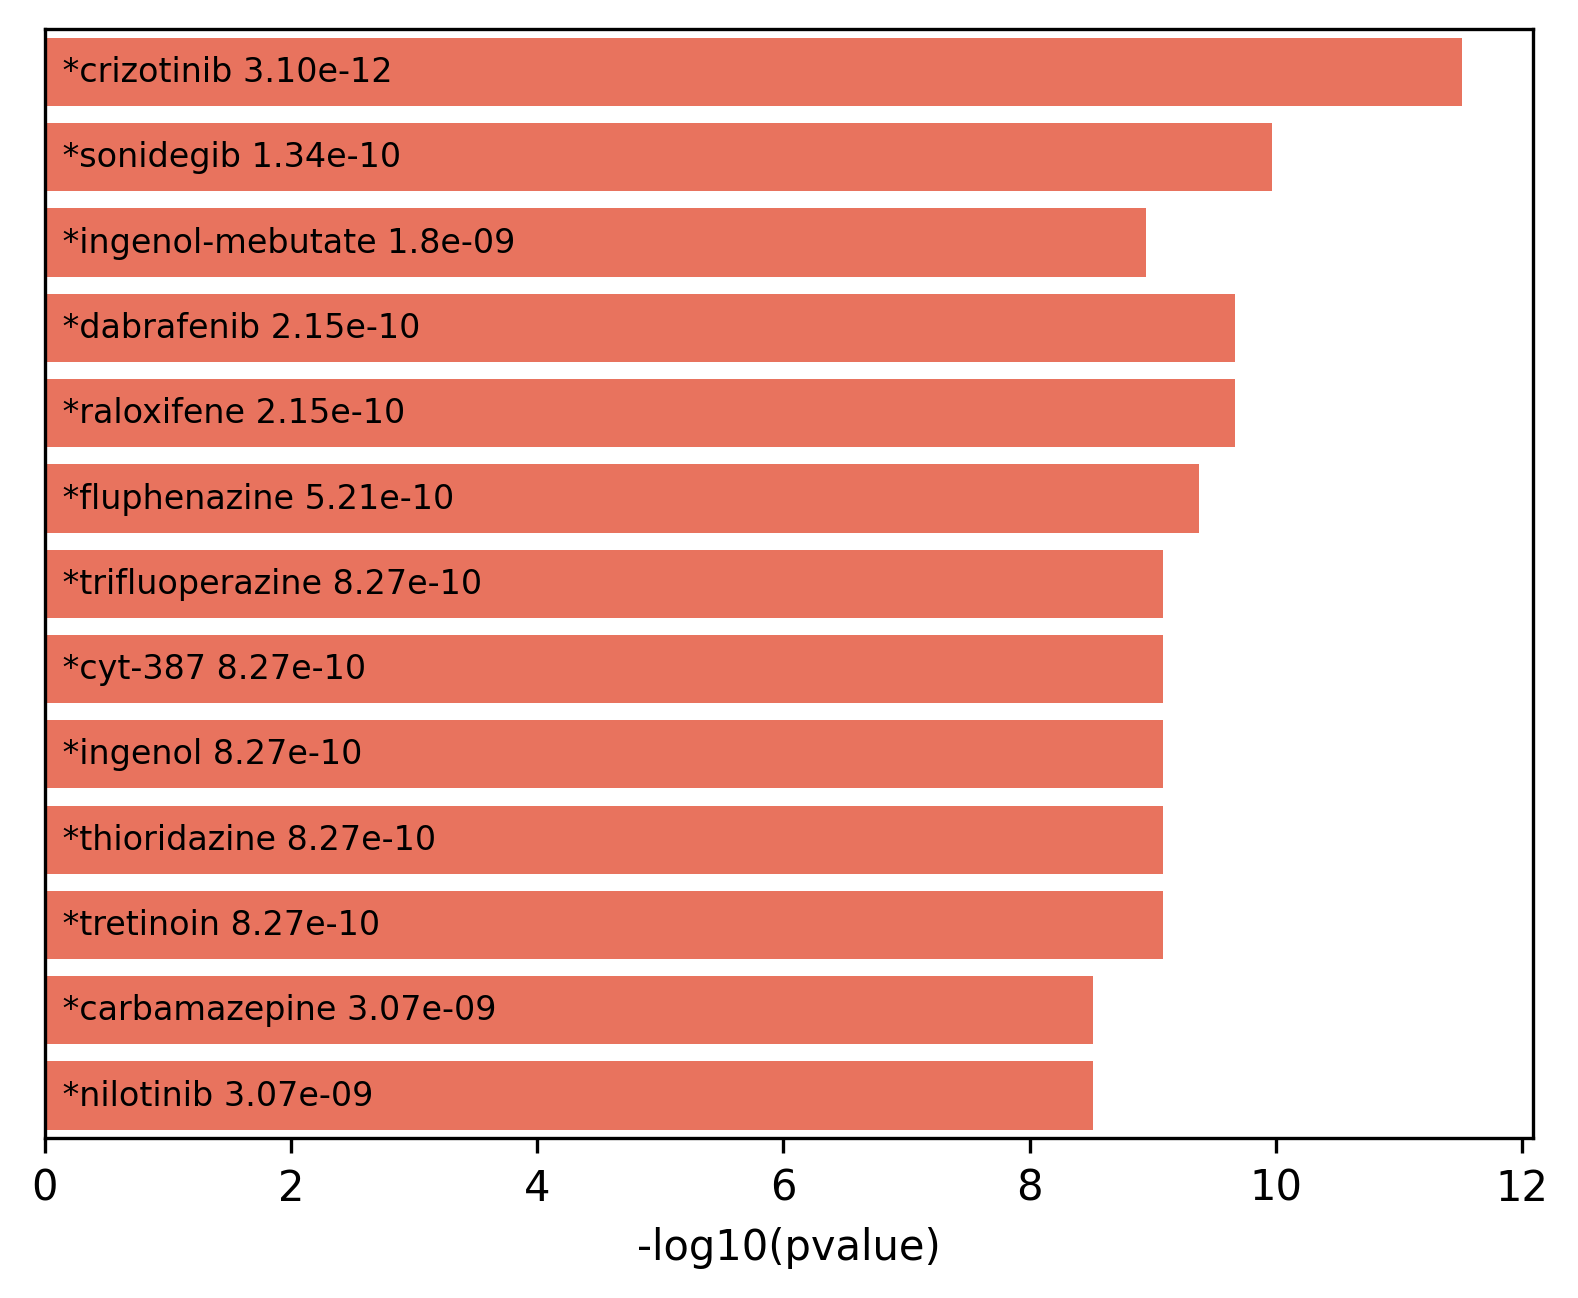

Figure 24: barplot representation depicting the -log10p values of the top FDA-approved l2s2_fda mimickers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_l2s2_fda.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_l2s2_fda.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_l2s2_fda.jpeg


**l2s2_all**

perturbation                                               term  \
0        quizartinib         ASG003_XC.P915_24H_F10_quizartinib_10uM up   
1         TL-HRAS-61             MOA001_A549_24H_G11_TL-HRAS-61_10uM up   
2          CGS-15943           ASG003_XC.P091_24H_K13_CGS-15943_10uM up   
3      BRD-K67526586            ERG012_PC3_6H_O17_BRD-K67526586_10uM up   
4        KIN-001-220           LJP009_SKL.C_24H_F13_KIN-001-220_10uM up   
5         crizotinib          ASG003_XC.P914_24H_I04_crizotinib_10uM up   
6      BRD-K68313733           CPC007_HT29_6H_I03_BRD-K68313733_10uM up   
7           IL3RA up                    XPR018_ES2.311_96H_G16_IL3RA up   
8       parbendazole           MOA001_A549_24H_P04_parbendazole_10uM up   
9       fenbendazole           MOA001_A549_24H_O03_fenbendazole_10uM up   
10     BRD-A15079084        HOG001_A549_6H_G22_BRD-A15079084_0.002uM up   
11             PX-12              FIBR027_MCLF130CN_6H_E18_PX-12_4uM up   
12      parbendazole           MOA001_A549_24H_O04_parbendazole_10uM up   
13     calmidazolium           CPC014_A549_6H_J20_calmidazolium_10uM up   
14         sonidegib          FIBR011_MCLF015CN_6H_E03_sonidegib_4uM up   
15     BRD-K51556300           CPC019_HT29_6H_P22_BRD-K51556300_10uM up   
16     BRD-A15079084           HOG001_A549_6H_G14_BRD-A15079084_10uM up   
17             QS-11              FIBR011_MCLF015CN_6H_K12_QS-11_4uM up   
18  ingenol-mebutate  REP.B027_HEK293_24H_D22_ingenol-mebutate_0.08u...   
19     BRD-K56411643          MOA001_A549_24H_C03_BRD-K56411643_10uM up   

    pvalueMimic  adjPvalueMimic  oddsRatioMimic  mimickerOverlap  approved  \
0      1.00e-17        1.68e-11        4.61e+00               48     False   
1      3.38e-14        2.83e-08        4.09e+00               43     False   
2      1.57e-13        8.78e-08        3.98e+00               42     False   
3      7.09e-13        2.38e-07        3.88e+00               41     False   
4      7.09e-13        2.38e-07        3.88e+00               41     False   
5      3.10e-12        5.20e-07        3.78e+00               40      True   
6      3.10e-12        5.20e-07        3.78e+00               40     False   
7      3.10e-12        5.20e-07        3.78e+00               40     False   
8      3.10e-12        5.20e-07        3.78e+00               40     False   
9      3.10e-12        5.20e-07        3.78e+00               40     False   
10     1.31e-11        2.01e-06        3.67e+00               39     False   
11     5.40e-11        5.04e-06        3.57e+00               38     False   
12     5.40e-11        5.04e-06        3.57e+00               38     False   
13     5.40e-11        5.04e-06        3.57e+00               38     False   
14     5.40e-11        5.04e-06        3.57e+00               38      True   
15     5.40e-11        5.04e-06        3.57e+00               38     False   
16     5.40e-11        5.04e-06        3.57e+00               38     False   
17     5.40e-11        5.04e-06        3.57e+00               38     False   
18     2.15e-10        1.03e-05        3.47e+00               37      True   
19     2.15e-10        1.03e-05        3.47e+00               37     False   

    count  
0    1482  
1     434  
2     712  
3      16  
4     650  
5    1884  
6      64  
7      40  
8     904  
9     126  
10    202  
11    508  
12    904  
13    174  
14    502  
15     82  
16    202  
17    212  
18    310  
19    178

Table 13: Ranked  LINCS L1000 signatures predicted to mimic the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_l2s2_all.tsv

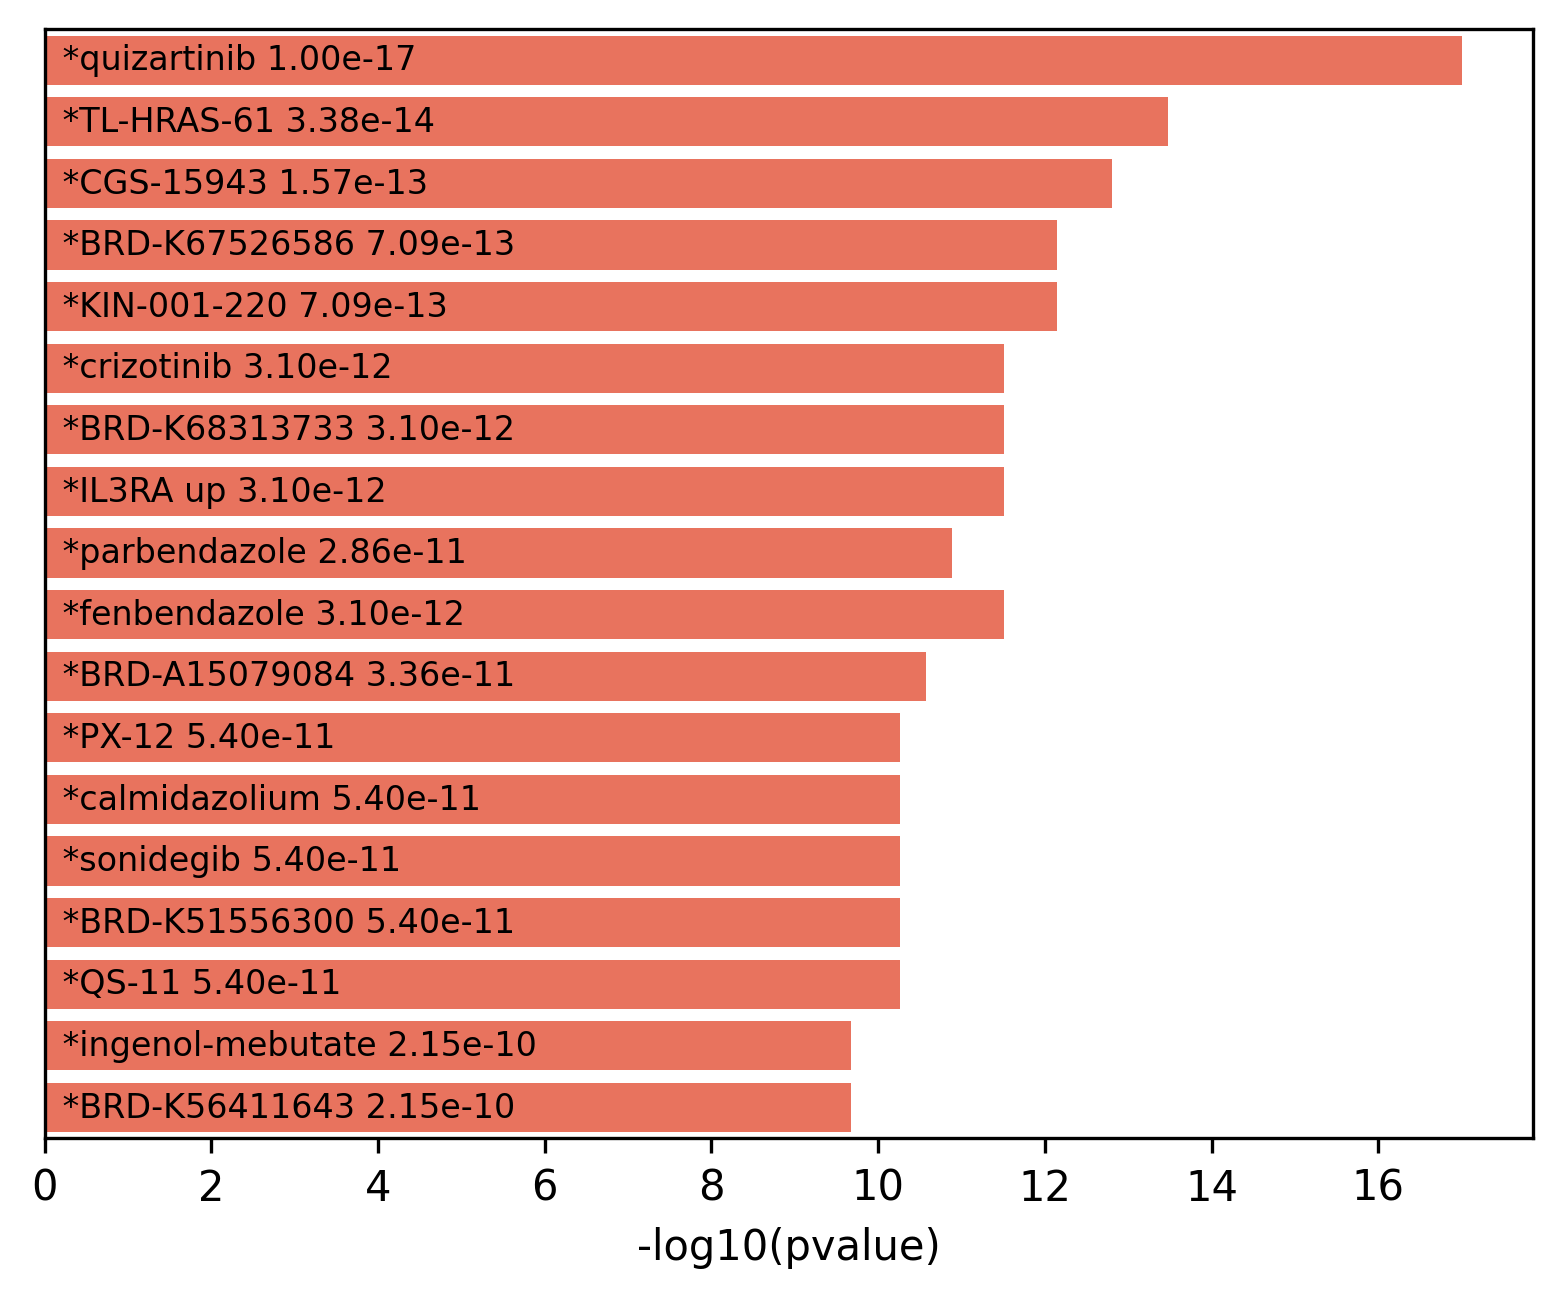

Figure 25: barplot representation depicting the -log10p values of the top  l2s2_all mimickers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_l2s2_all.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_l2s2_all.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_l2s2_all.jpeg


**drugseqr_fda**

perturbation  \
0  omacetaxine mepesuccinate   
1  omacetaxine mepesuccinate   
2  omacetaxine mepesuccinate   
3  omacetaxine mepesuccinate   
4  omacetaxine mepesuccinate   
5  omacetaxine mepesuccinate   
6  omacetaxine mepesuccinate   
7                  bosutinib   
8               temozolomide   
9               tirbanibulin   

                                                term  pvalueMimic  \
0  Omacetaxine Mepesuccinate_EA-18-FP00_batchid6_...     2.02e-06   
1  Omacetaxine Mepesuccinate_EA-18-FP00_batchid3_...     4.78e-06   
2  Omacetaxine Mepesuccinate_EA-18-FP00_batchid28...     1.20e-05   
3  Omacetaxine Mepesuccinate_EA-18-FP00_batchid40...     1.31e-05   
4  Omacetaxine Mepesuccinate_EA-18-FP00_batchid23...     3.15e-05   
5  Omacetaxine Mepesuccinate_EA-18-FP00_batchid16...     3.31e-05   
6  Omacetaxine Mepesuccinate_EA-18-FP00_batchid44...     4.99e-05   
7         Bosutinib_FA-10-SN61_batchid16_10uM_24h up     5.38e-05   
8      Temozolomide_BA-92-YC70_batchid20_10uM_24h up     7.03e-05   
9      Tirbanibulin_AD-86-OB87_batchid6_0.1uM_24h up     1.05e-04   

   adjPvalueMimic  oddsRatioMimic  mimickerOverlap  approved  count  
0        4.19e-03        2.81e+00               27      True    110  
1        5.72e-03        3.31e+00               20      True    110  
2        1.26e-02        2.67e+00               25      True    110  
3        1.33e-02        2.72e+00               24      True    110  
4        2.30e-02        2.58e+00               24      True    110  
5        2.35e-02        3.40e+00               16      True    110  
6        3.09e-02        2.44e+00               25      True    110  
7        3.15e-02        2.78e+00               20      True      8  
8        3.72e-02        5.42e+00                9      True      4  
9        4.79e-02        2.44e+00               23      True      8

Table 14: Ranked FDA-approved DRUG-seq signatures predicted to mimic the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_drugseqr_fda.tsv

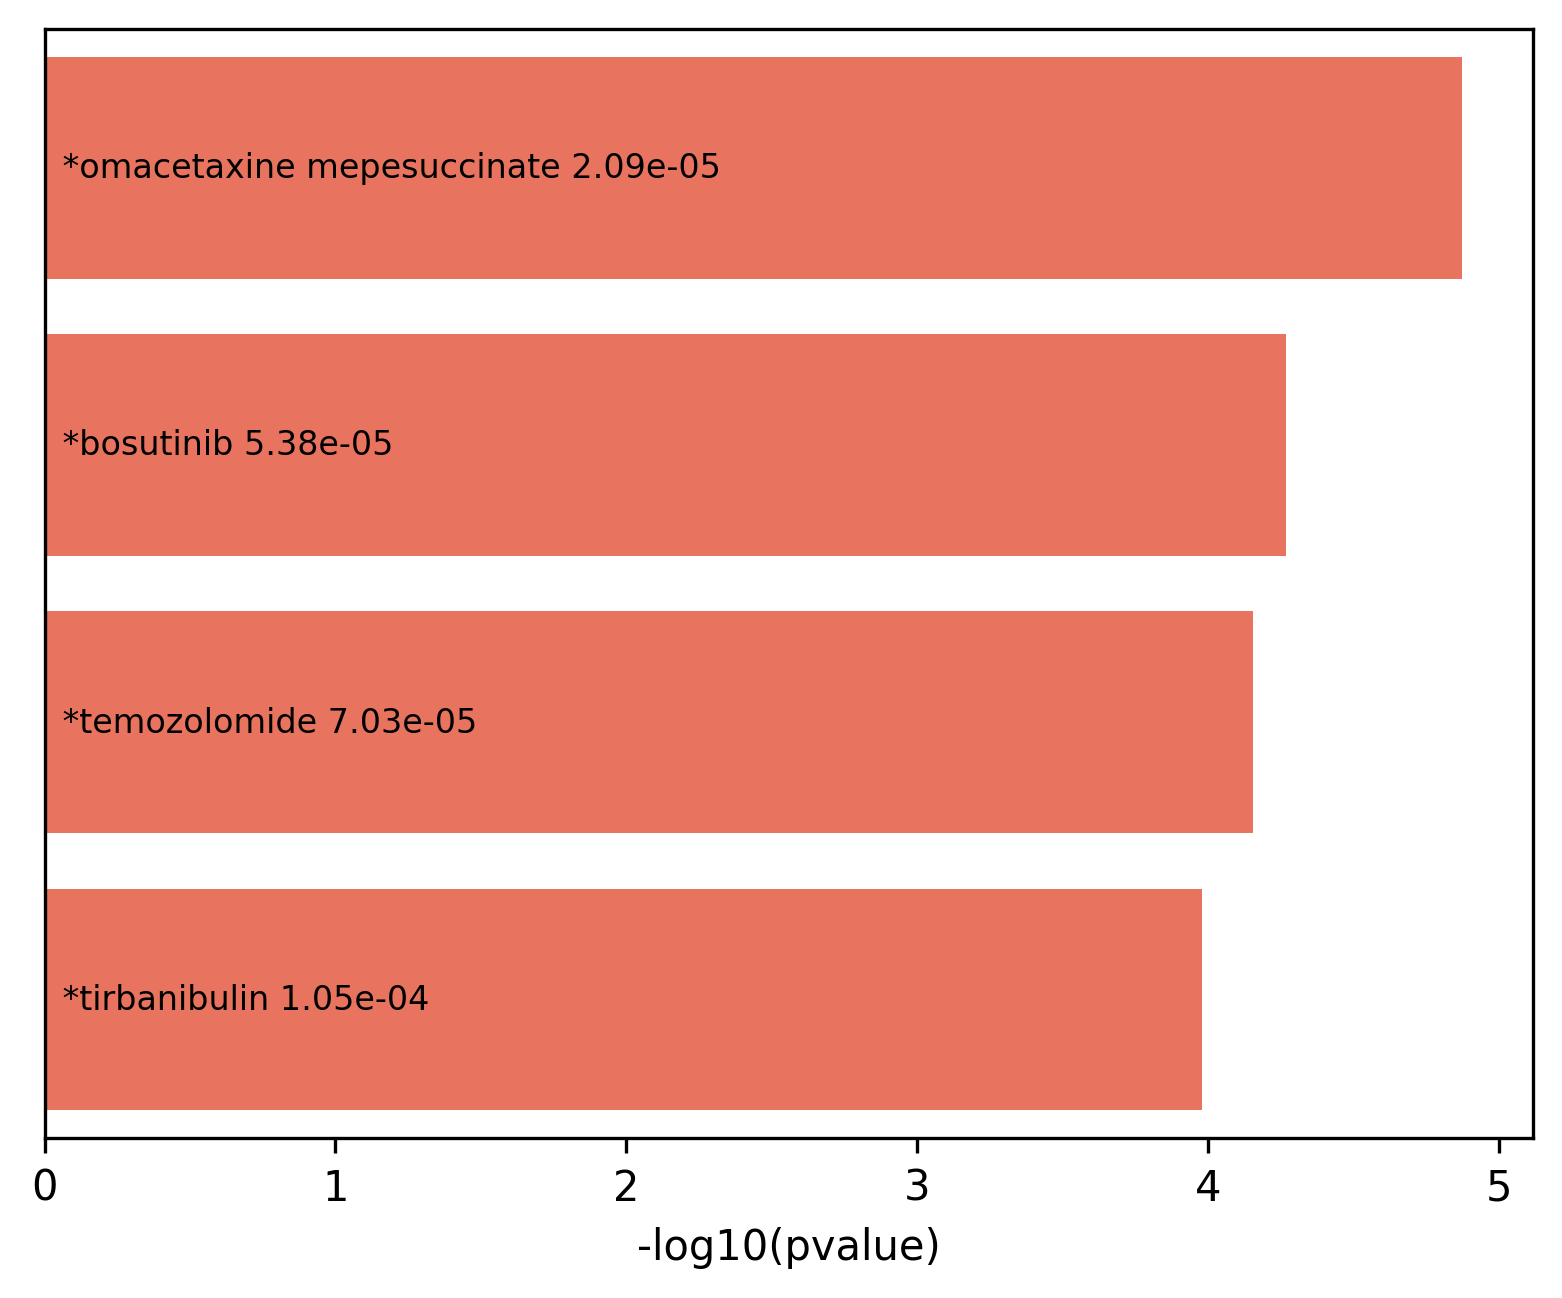

Figure 26: barplot representation depicting the -log10p values of the top FDA-approved drugseqr_fda mimickers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_drugseqr_fda.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_drugseqr_fda.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_drugseqr_fda.jpeg


**drugseqr_all**

perturbation  \
0                               
1                               
2                    11591924   
3                  mefloquine   
4                    46184988   
5                  galeterone   
6            pi4kiiibeta-in-9   
7               staurosporine   
8                    tx1-85-1   
9               inflachromene   
10               zygosporin a   
11  omacetaxine mepesuccinate   
12                    9807391   
13                              
14                              
15                              
16             cephalochromin   
17                   imd-0354   
18    cathepsin g inhibitor i   
19                    lly-507   

                                                 term  pvalueMimic  \
0                    _BD-11-DV28_batchid9_10uM_24h up     2.67e-08   
1                    _GE-53-SM76_batchid35_1uM_24h up     6.97e-08   
2           11591924_FB-95-JD99_batchid20_10uM_24h up     2.54e-07   
3         Mefloquine_FA-16-HR75_batchid16_10uM_24h up     3.26e-07   
4           46184988_DE-69-QQ25_batchid32_10uM_24h up     3.40e-07   
5         Galeterone_BD-36-VB52_batchid20_10uM_24h up     5.24e-07   
6   PI4KIIIbeta-IN-9_PD-71-MW24_batchid24_10uM_24h up     8.35e-07   
7    Staurosporine_AA-58-FJ71_batchid13_0.01uM_24h up     1.24e-06   
8           TX1-85-1_S0-EE-YMWJ_batchid32_10uM_24h up     1.28e-06   
9      Inflachromene_GD-72-XO18_batchid44_10uM_24h up     1.47e-06   
10      Zygosporin A_BE-42-IC00_batchid40_10uM_24h up     1.78e-06   
11  Omacetaxine Mepesuccinate_EA-18-FP00_batchid6_...     2.02e-06   
12           9807391_AD-00-WA10_batchid28_10uM_24h up     2.13e-06   
13                  _QC-76-GI57_batchid36_10uM_24h up     2.23e-06   
14                  _BD-11-DV28_batchid32_10uM_24h up     3.25e-06   
15                  _BD-11-DV28_batchid35_10uM_24h up     3.41e-06   
16    Cephalochromin_QA-14-AU91_batchid40_10uM_24h up     3.84e-06   
17          Imd-0354_LB-65-SM65_batchid32_10uM_24h up     4.03e-06   
18  Cathepsin G Inhibitor I_PD-60-FM93_batchid16_1...     4.26e-06   
19           Lly-507_AE-52-NW93_batchid20_10uM_24h up     4.28e-06   

    adjPvalueMimic  oddsRatioMimic  mimickerOverlap  approved  count  
0         7.02e-04        3.77e+00               25     False    104  
1         9.17e-04        4.63e+00               19     False      7  
2         1.79e-03        3.86e+00               21     False      5  
3         1.79e-03        3.52e+00               23     False      8  
4         1.79e-03        2.80e+00               31     False      5  
5         2.30e-03        5.13e+00               15     False      6  
6         3.14e-03        4.11e+00               18     False      7  
7         3.75e-03        2.49e+00               34     False      8  
8         3.75e-03        3.98e+00               18     False      6  
9         3.87e-03        2.00e+01                6     False      6  
10        4.19e-03        2.36e+00               36     False      8  
11        4.19e-03        2.81e+00               27      True    110  
12        4.19e-03        2.00e+00               49     False      6  
13        4.19e-03        4.87e+00               14     False      5  
14        5.61e-03        3.91e+00               17     False    104  
15        5.61e-03        2.88e+00               25     False    104  
16        5.63e-03        2.40e+00               33     False      5  
17        5.63e-03        2.85e+00               25     False      8  
18        5.63e-03        3.22e+00               21     False      7  
19        5.63e-03        2.18e+00               39     False      4

Table 15: Ranked  DRUG-seq signatures predicted to mimic the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_drugseqr_all.tsv

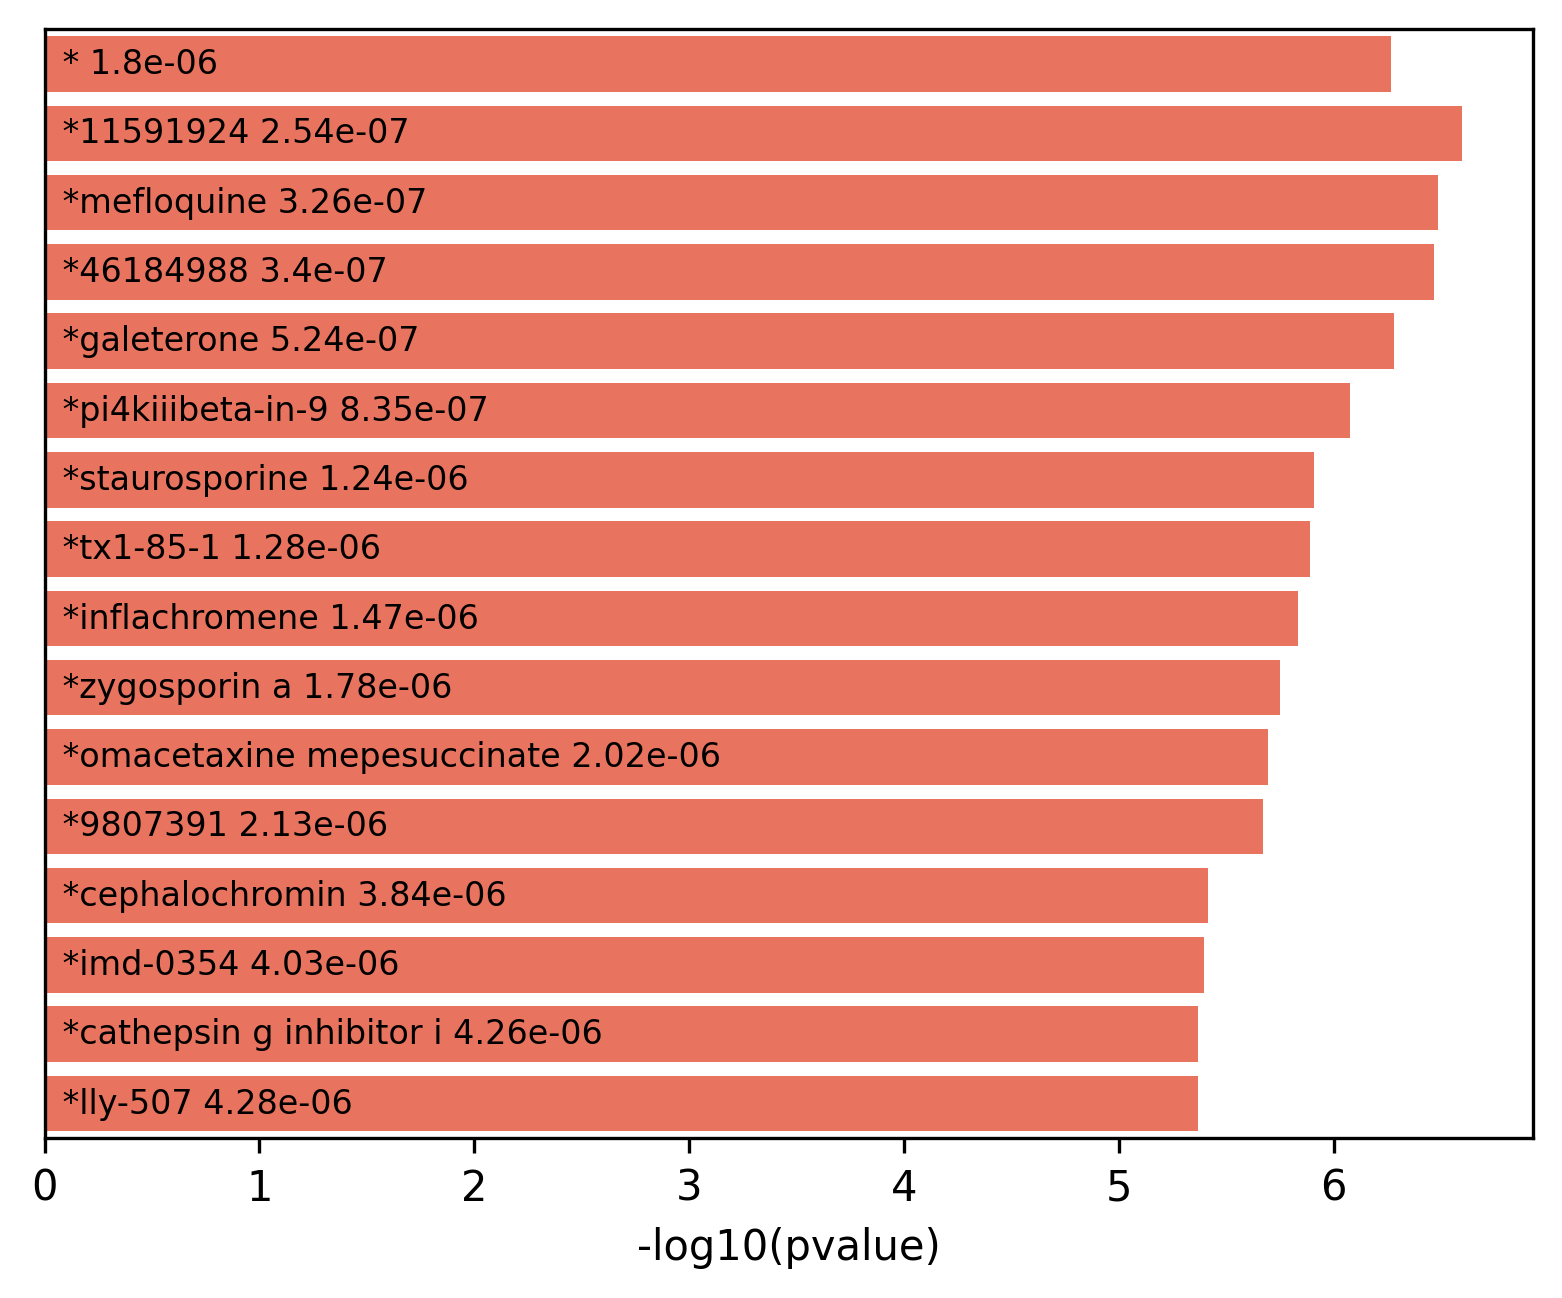

Figure 27: barplot representation depicting the -log10p values of the top  drugseqr_all mimickers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_drugseqr_all.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_drugseqr_all.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl fer h rep_mimickers_drugseqr_all.jpeg

---

#### **cells dmso h rep-vs-cells rsl h rep**


**l2s2_fda**

perturbation                                               term  \
0         crizotinib          ASG003_XC.P914_24H_I04_crizotinib_10uM up   
1          sonidegib          FIBR011_MCLF015CN_6H_E03_sonidegib_4uM up   
2   ingenol-mebutate  REP.B027_HEK293_24H_D22_ingenol-mebutate_0.08u...   
3         dabrafenib          ASG002_MKN45_24H_K24_dabrafenib_0.12uM up   
4          sonidegib          FIBR010_MCLF123SZ_6H_E03_sonidegib_4uM up   
5         dabrafenib        ASG003_XC.P091_24H_H18_dabrafenib_0.12uM up   
6         raloxifene          ASG003_XC.P904_24H_I13_raloxifene_10uM up   
7       fluphenazine            PAC066_U2OS_6H_B24_fluphenazine_20uM up   
8    trifluoperazine         PAC004_U2OS_6H_A14_trifluoperazine_20uM up   
9            cyt-387              LJP005_A549_24H_P08_CYT-387_3.33uM up   
10      fluphenazine            PAC001_U2OS_6H_K24_fluphenazine_20uM up   
11           ingenol              HOG001_A549_24H_B16_ingenol_1.11uM up   
12      thioridazine            PAC067_U2OS_6H_L01_thioridazine_20uM up   
13         tretinoin          FIBR010_MCLF123SZ_6H_B03_tretinoin_4uM up   
14  ingenol-mebutate   REP.B027_HELA_24H_D20_ingenol-mebutate_0.74uM up   
15   trifluoperazine         PAC006_U2OS_6H_A14_trifluoperazine_20uM up   
16  ingenol-mebutate   REP.B027_HELA_24H_D21_ingenol-mebutate_0.25uM up   
17  ingenol-mebutate   REP.B027_HELA_24H_D22_ingenol-mebutate_0.08uM up   
18     carbamazepine       KTOX002_HPTEC_6H_N13_carbamazepine_1000uM up   
19         nilotinib             LKCP001_A549_24H_G01_nilotinib_10uM up   

    pvalueMimic  adjPvalueMimic  oddsRatioMimic  mimickerOverlap  approved  \
0      3.10e-12        5.20e-07        3.78e+00               40      True   
1      5.40e-11        5.04e-06        3.57e+00               38      True   
2      2.15e-10        1.03e-05        3.47e+00               37      True   
3      2.15e-10        1.03e-05        3.47e+00               37      True   
4      2.15e-10        1.03e-05        3.47e+00               37      True   
5      2.15e-10        1.03e-05        3.47e+00               37      True   
6      2.15e-10        1.03e-05        3.47e+00               37      True   
7      2.15e-10        1.03e-05        3.47e+00               37      True   
8      8.27e-10        2.10e-05        3.37e+00               36      True   
9      8.27e-10        2.10e-05        3.37e+00               36      True   
10     8.27e-10        2.10e-05        3.37e+00               36      True   
11     8.27e-10        2.10e-05        3.37e+00               36      True   
12     8.27e-10        2.10e-05        3.37e+00               36      True   
13     8.27e-10        2.10e-05        3.37e+00               36      True   
14     8.27e-10        2.10e-05        3.37e+00               36      True   
15     8.27e-10        2.10e-05        3.37e+00               36      True   
16     3.07e-09        5.37e-05        3.27e+00               35      True   
17     3.07e-09        5.37e-05        3.27e+00               35      True   
18     3.07e-09        5.37e-05        3.27e+00               35      True   
19     3.07e-09        5.37e-05        3.27e+00               35      True   

    count  
0    1884  
1     502  
2     310  
3    1304  
4     502  
5    1304  
6    1452  
7     750  
8    1388  
9     772  
10    750  
11    214  
12   1444  
13    988  
14    310  
15   1388  
16    310  
17    310  
18    638  
19   1230

Table 16: Ranked FDA-approved LINCS L1000 signatures predicted to mimic the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_l2s2_fda.tsv

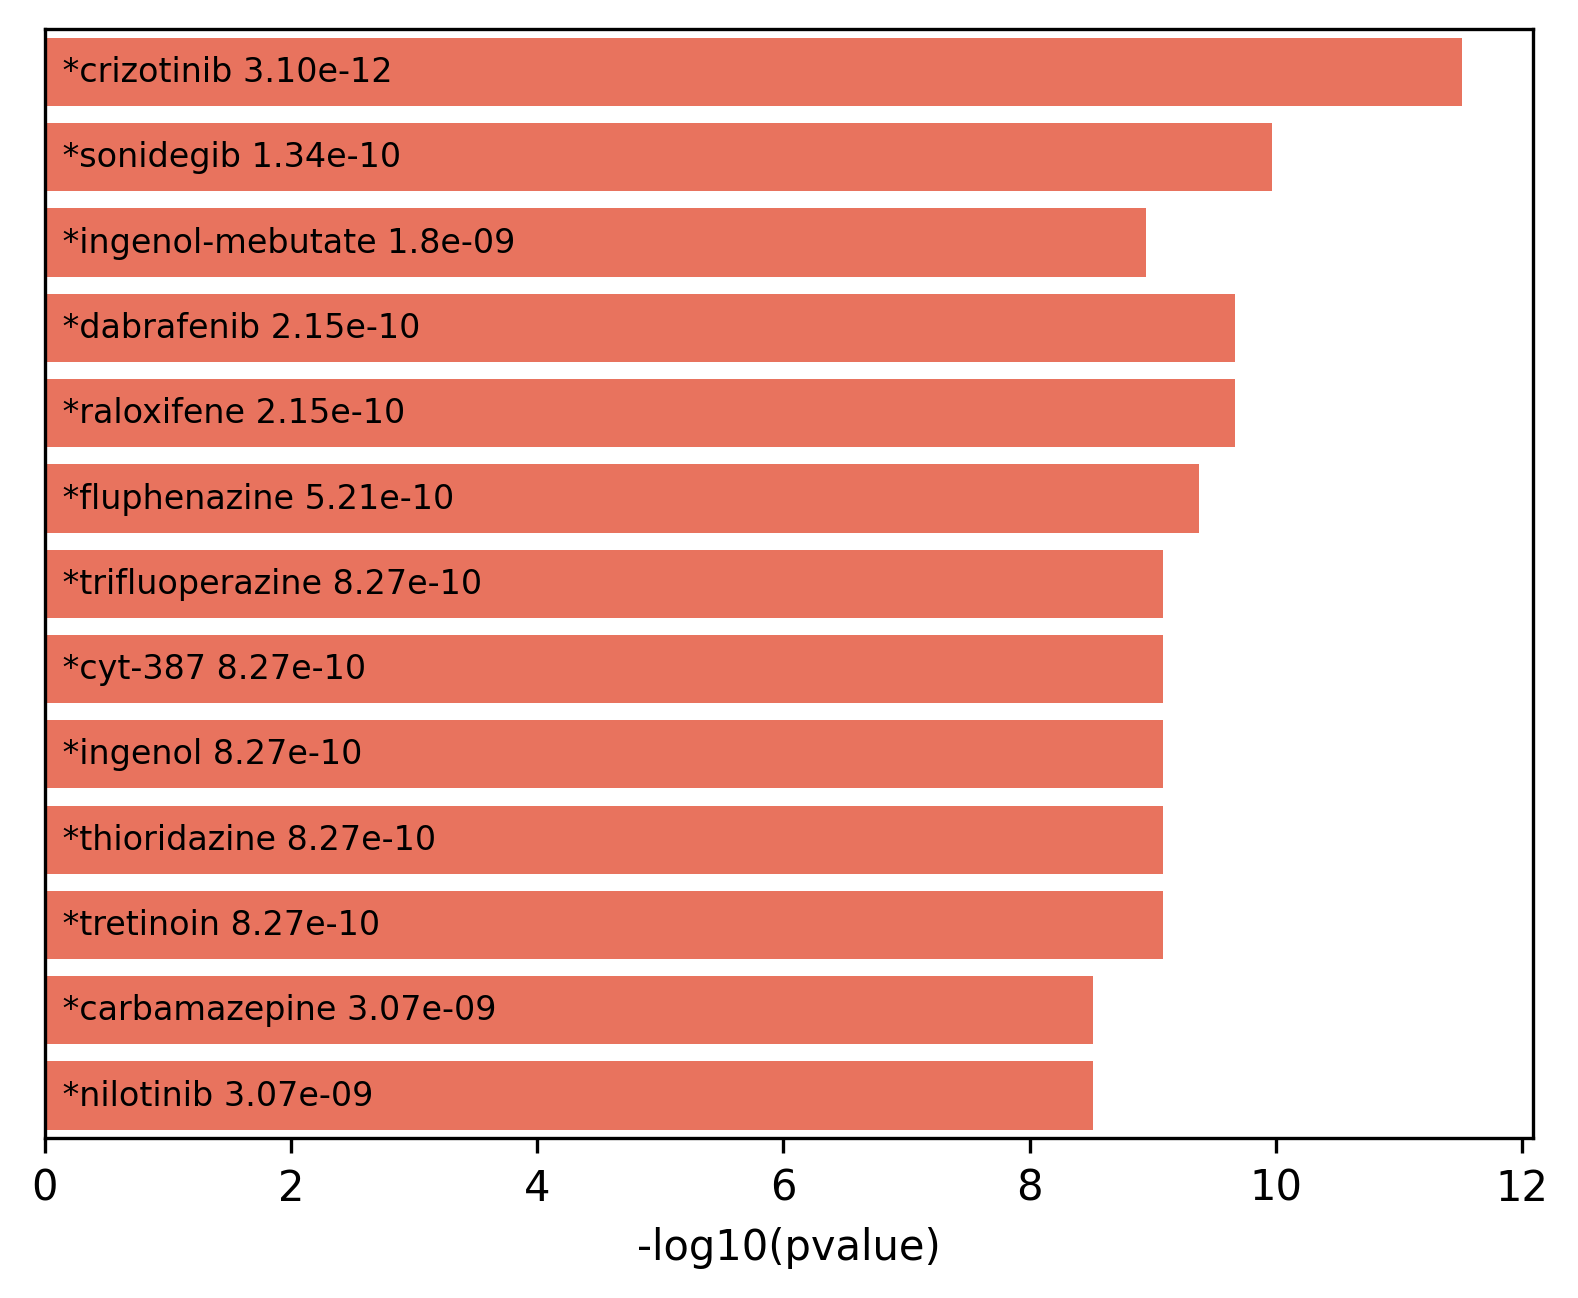

Figure 28: barplot representation depicting the -log10p values of the top FDA-approved l2s2_fda mimickers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_l2s2_fda.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_l2s2_fda.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_l2s2_fda.jpeg


**l2s2_all**

perturbation                                               term  \
0        quizartinib         ASG003_XC.P915_24H_F10_quizartinib_10uM up   
1         TL-HRAS-61             MOA001_A549_24H_G11_TL-HRAS-61_10uM up   
2          CGS-15943           ASG003_XC.P091_24H_K13_CGS-15943_10uM up   
3      BRD-K67526586            ERG012_PC3_6H_O17_BRD-K67526586_10uM up   
4        KIN-001-220           LJP009_SKL.C_24H_F13_KIN-001-220_10uM up   
5         crizotinib          ASG003_XC.P914_24H_I04_crizotinib_10uM up   
6      BRD-K68313733           CPC007_HT29_6H_I03_BRD-K68313733_10uM up   
7           IL3RA up                    XPR018_ES2.311_96H_G16_IL3RA up   
8       parbendazole           MOA001_A549_24H_P04_parbendazole_10uM up   
9       fenbendazole           MOA001_A549_24H_O03_fenbendazole_10uM up   
10     BRD-A15079084        HOG001_A549_6H_G22_BRD-A15079084_0.002uM up   
11             PX-12              FIBR027_MCLF130CN_6H_E18_PX-12_4uM up   
12      parbendazole           MOA001_A549_24H_O04_parbendazole_10uM up   
13     calmidazolium           CPC014_A549_6H_J20_calmidazolium_10uM up   
14         sonidegib          FIBR011_MCLF015CN_6H_E03_sonidegib_4uM up   
15     BRD-K51556300           CPC019_HT29_6H_P22_BRD-K51556300_10uM up   
16     BRD-A15079084           HOG001_A549_6H_G14_BRD-A15079084_10uM up   
17             QS-11              FIBR011_MCLF015CN_6H_K12_QS-11_4uM up   
18  ingenol-mebutate  REP.B027_HEK293_24H_D22_ingenol-mebutate_0.08u...   
19     BRD-K56411643          MOA001_A549_24H_C03_BRD-K56411643_10uM up   

    pvalueMimic  adjPvalueMimic  oddsRatioMimic  mimickerOverlap  approved  \
0      1.00e-17        1.68e-11        4.61e+00               48     False   
1      3.38e-14        2.83e-08        4.09e+00               43     False   
2      1.57e-13        8.78e-08        3.98e+00               42     False   
3      7.09e-13        2.38e-07        3.88e+00               41     False   
4      7.09e-13        2.38e-07        3.88e+00               41     False   
5      3.10e-12        5.20e-07        3.78e+00               40      True   
6      3.10e-12        5.20e-07        3.78e+00               40     False   
7      3.10e-12        5.20e-07        3.78e+00               40     False   
8      3.10e-12        5.20e-07        3.78e+00               40     False   
9      3.10e-12        5.20e-07        3.78e+00               40     False   
10     1.31e-11        2.01e-06        3.67e+00               39     False   
11     5.40e-11        5.04e-06        3.57e+00               38     False   
12     5.40e-11        5.04e-06        3.57e+00               38     False   
13     5.40e-11        5.04e-06        3.57e+00               38     False   
14     5.40e-11        5.04e-06        3.57e+00               38      True   
15     5.40e-11        5.04e-06        3.57e+00               38     False   
16     5.40e-11        5.04e-06        3.57e+00               38     False   
17     5.40e-11        5.04e-06        3.57e+00               38     False   
18     2.15e-10        1.03e-05        3.47e+00               37      True   
19     2.15e-10        1.03e-05        3.47e+00               37     False   

    count  
0    1482  
1     434  
2     712  
3      16  
4     650  
5    1884  
6      64  
7      40  
8     904  
9     126  
10    202  
11    508  
12    904  
13    174  
14    502  
15     82  
16    202  
17    212  
18    310  
19    178

Table 17: Ranked  LINCS L1000 signatures predicted to mimic the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_l2s2_all.tsv

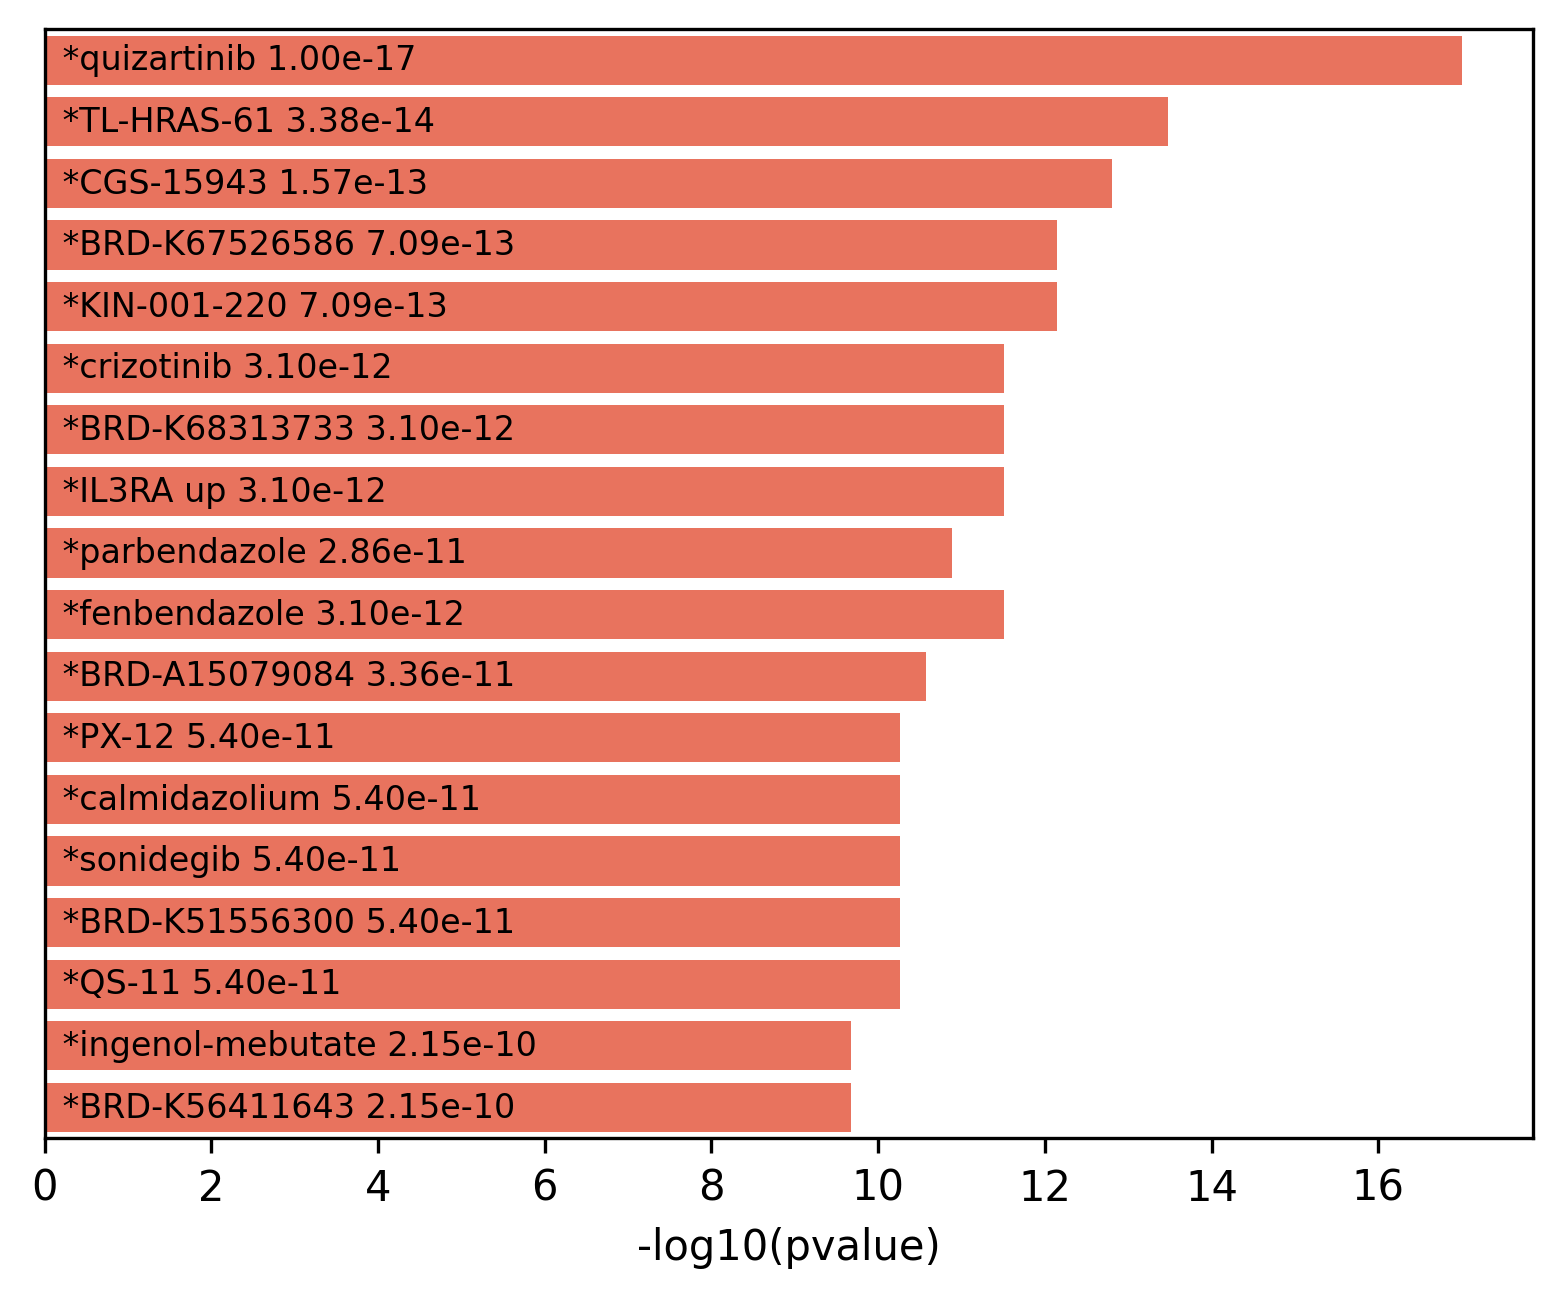

Figure 29: barplot representation depicting the -log10p values of the top  l2s2_all mimickers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_l2s2_all.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_l2s2_all.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_l2s2_all.jpeg


**drugseqr_fda**

perturbation  \
0  omacetaxine mepesuccinate   
1  omacetaxine mepesuccinate   
2  omacetaxine mepesuccinate   
3  omacetaxine mepesuccinate   
4  omacetaxine mepesuccinate   
5  omacetaxine mepesuccinate   
6  omacetaxine mepesuccinate   
7                  bosutinib   
8               temozolomide   
9               tirbanibulin   

                                                term  pvalueMimic  \
0  Omacetaxine Mepesuccinate_EA-18-FP00_batchid6_...     2.02e-06   
1  Omacetaxine Mepesuccinate_EA-18-FP00_batchid3_...     4.78e-06   
2  Omacetaxine Mepesuccinate_EA-18-FP00_batchid28...     1.20e-05   
3  Omacetaxine Mepesuccinate_EA-18-FP00_batchid40...     1.31e-05   
4  Omacetaxine Mepesuccinate_EA-18-FP00_batchid23...     3.15e-05   
5  Omacetaxine Mepesuccinate_EA-18-FP00_batchid16...     3.31e-05   
6  Omacetaxine Mepesuccinate_EA-18-FP00_batchid44...     4.99e-05   
7         Bosutinib_FA-10-SN61_batchid16_10uM_24h up     5.38e-05   
8      Temozolomide_BA-92-YC70_batchid20_10uM_24h up     7.03e-05   
9      Tirbanibulin_AD-86-OB87_batchid6_0.1uM_24h up     1.05e-04   

   adjPvalueMimic  oddsRatioMimic  mimickerOverlap  approved  count  
0        4.19e-03        2.81e+00               27      True    110  
1        5.72e-03        3.31e+00               20      True    110  
2        1.26e-02        2.67e+00               25      True    110  
3        1.33e-02        2.72e+00               24      True    110  
4        2.30e-02        2.58e+00               24      True    110  
5        2.35e-02        3.40e+00               16      True    110  
6        3.09e-02        2.44e+00               25      True    110  
7        3.15e-02        2.78e+00               20      True      8  
8        3.72e-02        5.42e+00                9      True      4  
9        4.79e-02        2.44e+00               23      True      8

Table 18: Ranked FDA-approved DRUG-seq signatures predicted to mimic the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_drugseqr_fda.tsv

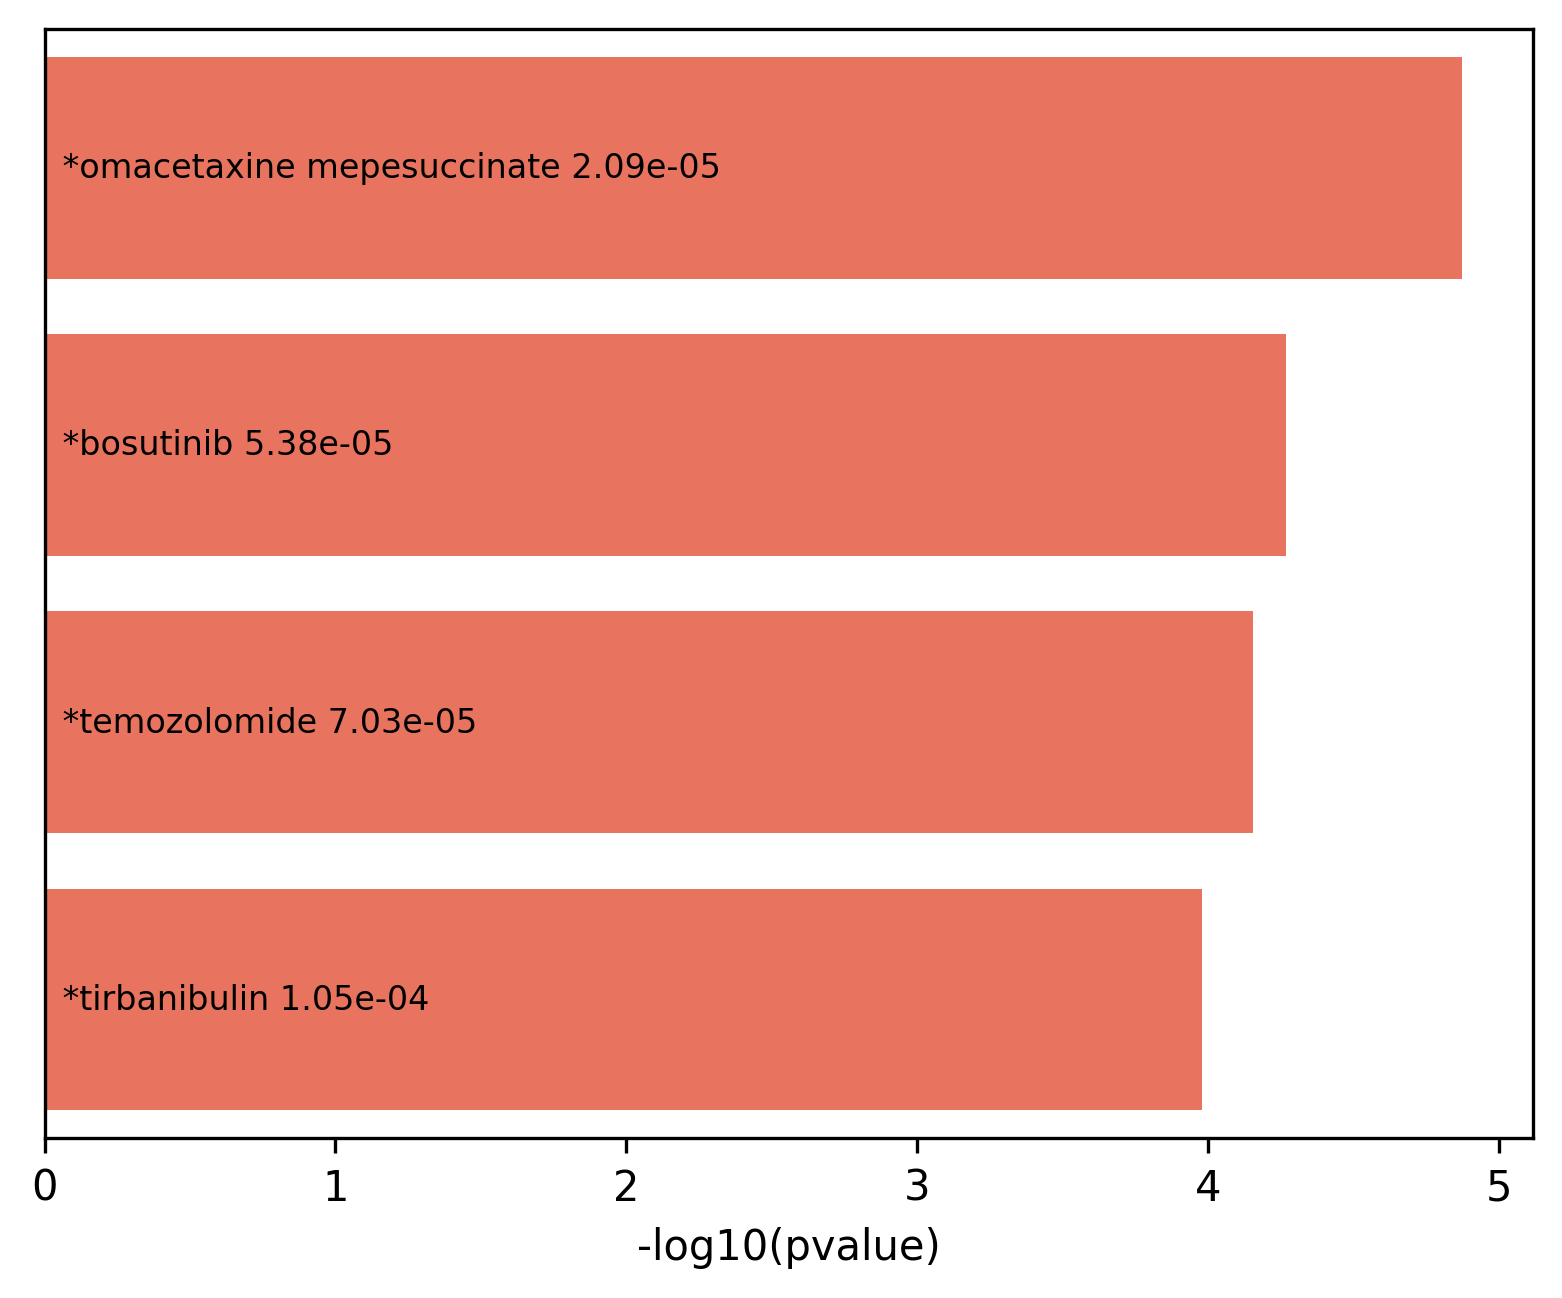

Figure 30: barplot representation depicting the -log10p values of the top FDA-approved drugseqr_fda mimickers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_drugseqr_fda.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_drugseqr_fda.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_drugseqr_fda.jpeg


**drugseqr_all**

perturbation  \
0                               
1                               
2                    11591924   
3                  mefloquine   
4                    46184988   
5                  galeterone   
6            pi4kiiibeta-in-9   
7               staurosporine   
8                    tx1-85-1   
9               inflachromene   
10               zygosporin a   
11  omacetaxine mepesuccinate   
12                    9807391   
13                              
14                              
15                              
16             cephalochromin   
17                   imd-0354   
18    cathepsin g inhibitor i   
19                    lly-507   

                                                 term  pvalueMimic  \
0                    _BD-11-DV28_batchid9_10uM_24h up     2.67e-08   
1                    _GE-53-SM76_batchid35_1uM_24h up     6.97e-08   
2           11591924_FB-95-JD99_batchid20_10uM_24h up     2.54e-07   
3         Mefloquine_FA-16-HR75_batchid16_10uM_24h up     3.26e-07   
4           46184988_DE-69-QQ25_batchid32_10uM_24h up     3.40e-07   
5         Galeterone_BD-36-VB52_batchid20_10uM_24h up     5.24e-07   
6   PI4KIIIbeta-IN-9_PD-71-MW24_batchid24_10uM_24h up     8.35e-07   
7    Staurosporine_AA-58-FJ71_batchid13_0.01uM_24h up     1.24e-06   
8           TX1-85-1_S0-EE-YMWJ_batchid32_10uM_24h up     1.28e-06   
9      Inflachromene_GD-72-XO18_batchid44_10uM_24h up     1.47e-06   
10      Zygosporin A_BE-42-IC00_batchid40_10uM_24h up     1.78e-06   
11  Omacetaxine Mepesuccinate_EA-18-FP00_batchid6_...     2.02e-06   
12           9807391_AD-00-WA10_batchid28_10uM_24h up     2.13e-06   
13                  _QC-76-GI57_batchid36_10uM_24h up     2.23e-06   
14                  _BD-11-DV28_batchid32_10uM_24h up     3.25e-06   
15                  _BD-11-DV28_batchid35_10uM_24h up     3.41e-06   
16    Cephalochromin_QA-14-AU91_batchid40_10uM_24h up     3.84e-06   
17          Imd-0354_LB-65-SM65_batchid32_10uM_24h up     4.03e-06   
18  Cathepsin G Inhibitor I_PD-60-FM93_batchid16_1...     4.26e-06   
19           Lly-507_AE-52-NW93_batchid20_10uM_24h up     4.28e-06   

    adjPvalueMimic  oddsRatioMimic  mimickerOverlap  approved  count  
0         7.02e-04        3.77e+00               25     False    104  
1         9.17e-04        4.63e+00               19     False      7  
2         1.79e-03        3.86e+00               21     False      5  
3         1.79e-03        3.52e+00               23     False      8  
4         1.79e-03        2.80e+00               31     False      5  
5         2.30e-03        5.13e+00               15     False      6  
6         3.14e-03        4.11e+00               18     False      7  
7         3.75e-03        2.49e+00               34     False      8  
8         3.75e-03        3.98e+00               18     False      6  
9         3.87e-03        2.00e+01                6     False      6  
10        4.19e-03        2.36e+00               36     False      8  
11        4.19e-03        2.81e+00               27      True    110  
12        4.19e-03        2.00e+00               49     False      6  
13        4.19e-03        4.87e+00               14     False      5  
14        5.61e-03        3.91e+00               17     False    104  
15        5.61e-03        2.88e+00               25     False    104  
16        5.63e-03        2.40e+00               33     False      5  
17        5.63e-03        2.85e+00               25     False      8  
18        5.63e-03        3.22e+00               21     False      7  
19        5.63e-03        2.18e+00               39     False      4

Table 19: Ranked  DRUG-seq signatures predicted to mimic the uploaded geneset.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_drugseqr_all.tsv

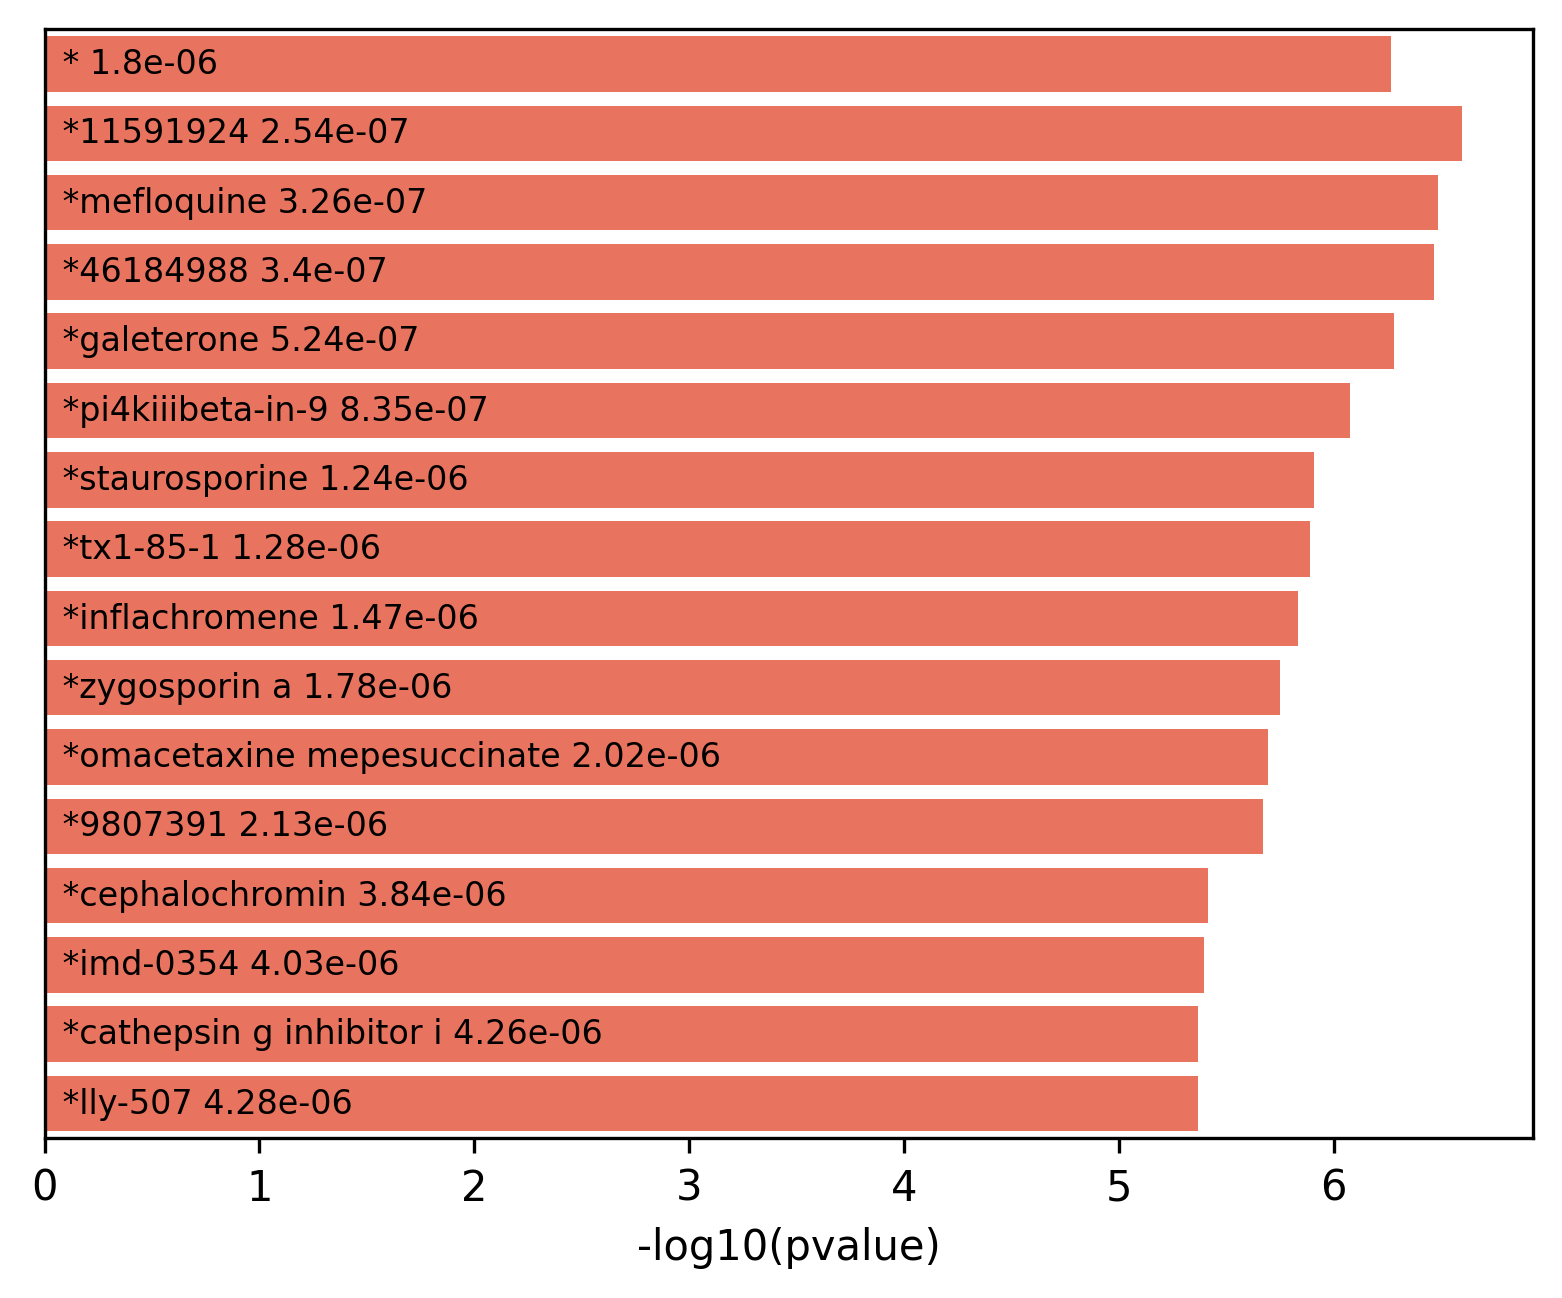

Figure 31: barplot representation depicting the -log10p values of the top  drugseqr_all mimickers. Red bars represent statistically significant results; otherwise gray.

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_drugseqr_all.png

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_drugseqr_all.svg

/home/ajy20/geo2reports/output/GSE247883/cells dmso h rep-vs-cells rsl h rep_mimickers_drugseqr_all.jpeg

---

In [71]:
for sig_name in sig_names_clean:
    # up_genes_t500 = upreg_t500[sig_name]
    # down_genes_t500 = downreg_t500[sig_name]

    up_genes = upreg[sig_name]
    down_genes = upreg[sig_name]

    mim_drugs = druganalysis(geneset=up_genes_t500, geneset_dn=down_genes_t500, direction="mimickers", save_path=resource_path, save_name=sig_name, tab_num=tab_num, fig_num=fig_num)
    display(Markdown(f"#### **{sig_name}**"))
    
    for db in dbs:
        display(Markdown(f"\n**{db}**"))
        try:
            mim_drugs.display_table(db=db)
            mim_drugs.display_barplot(db=db, save_path=resource_path, save_formats=save_formats)
        except ValueError as e:
            print("Caught error: ", e)

    fig_num = mim_drugs.fig_num
    tab_num  = mim_drugs.tab_num

    display(Markdown("---"))
    

## **References**

In [72]:
references = f'''
[1] {citation}

[2] McInnes L, Healy J, Saul N, Großberger L. UMAP: Uniform manifold approximation and projection. Journal of Open Source Software. 2018;3(29):861. doi:10.21105/joss.00861

[3] Clark NR, Ma’ayan A. Introduction to statistical methods to analyze large data sets: Principal Components Analysis. Science Signaling. 2011;4(190):tr3-tr3. doi:10.1126/scisignal.2001967 

[4] van der Maaten L, Hinton G. Visualizing Data using t-SNE. Journal of Machine Learning Research. 2008;9(86):2579-2605.

[5] Chen EY, Tan CM, Kou Y, Duan Q, Wang Z, Meirelles GV, Clark NR, Ma'ayan A. Enrichr: interactive and collaborative HTML5 gene list enrichment analysis tool. BMC Bioinformatics. 2013;128(14)

[6] Kuleshov MV, Jones MR, Rouillard AD, Fernandez NF, Duan Q, Wang Z, Koplev S, Jenkins SL, Jagodnik KM, Lachmann A, McDermott MG, Monteiro CD, Gundersen GW, Ma'ayan A. Enrichr: a comprehensive gene set enrichment analysis web server 2016 update. Nucleic Acids Research. 2016; gkw377.

[7] Xie Z, Bailey A, Kuleshov MV, Clarke DJB., Evangelista JE, Jenkins SL, Lachmann A, Wojciechowicz ML, Kropiwnicki E, Jagodnik KM, Jeon M, & Ma’ayan A. Gene set knowledge discovery with Enrichr. Current Protocols, 1, e90. 2021. doi: 10.1002/cpz1.90

[8] Keenan AB, Torre D, Lachmann A, Leong AK, Wojciechowicz M, Utti V, Jagodnik K, Kropiwnicki E, Wang Z, Ma'ayan A (2019) ChEA3: transcription factor enrichment analysis by orthogonal omics integration. Nucleic Acids Research. doi: 10.1093/nar/gkz446

[9] Marino GB, Evangelista JE, Clarke DJB, Ma’ayan A. L2S2: chemical perturbation and CRISPR KO LINCS L1000 signature search engine. Nucleic Acids Res. 2025; gkaf373. doi:10.1093/nar/gkaf373

[10] Li J, Ho DJ, Henault M, et al. DRUG-seq Provides Unbiased Biological Activity Readouts for Neuroscience Drug Discovery. ACS Chem Biol. 2022;17(6):1401-1414. doi:10.1021/acschembio.1c00920

[11] Lachmann A, Torre D, Keenan AB, Jagodnik KM, Lee HJ, Wang L, Silverstein MC, Ma'ayan A. Massive mining of publicly available RNA-seq data from human and mouse. Nature Communications 9. Article number: 1366 (2018), doi: 10.1038/s41467-018-03751-6.

[12] Bray, N., Pimentel, H., Melsted, P. et al. Near-optimal probabilistic RNA-seq quantification. Nat Biotechnol 34, 525–527 (2016). https://doi.org/10.1038/nbt.3519

[13] Fernandez, N. F. et al. Clustergrammer, a web-based heatmap visualization and analysis tool for high-dimensional biological data. Sci. Data 4:170151 doi: 10.1038/sdata.2017.151 (2017).

[14] Ritchie ME, Phipson B, Wu D, Hu Y, Law CW, Shi W, Smyth GK. limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic Acids Res. 2015 Apr 20;43(7):e47. doi: 10.1093/nar/gkv007.

[15] Milacic M, Beavers D, Conley P, Gong C, Gillespie M, Griss J, Haw R, Jassal B, Matthews L, May B, Petryszak R, Ragueneau E, Rothfels K, Sevilla C, Shamovsky V, Stephan R, Tiwari K, Varusai T, Weiser J, Wright A, Wu G, Stein L, Hermjakob H, D’Eustachio P. The Reactome Pathway Knowledgebase 2024. Nucleic Acids Research. 2024. doi: 10.1093/nar/gkad1025.

[16] Eppig JT, Smith CL, Blake JA, Ringwald M, Kadin JA, Richardson JE, Bult CJ. Mouse Genome Informatics (MGI): Resources for Mining Mouse Genetic, Genomic, and Biological Data in Support of Primary and Translational Research. Methods Mol Biol. 2017;1488:47-73. doi: 10.1007/978-1-4939-6427-7_3.

[17] Ashburner M, Ball CA, Blake JA, Botstein D, Butler H, Cherry JM, Davis AP, Dolinski K, Dwight SS, Eppig JT, Harris MA, Hill DP, Issel-Tarver L, Kasarskis A, Lewis S, Matese JC, Richardson JE, Ringwald M, Rubin GM, Sherlock G. Gene ontology: tool for the unification of biology. The Gene Ontology Consortium. Nat Genet. 2000 May;25(1):25-9. doi: 10.1038/75556.

[18] Cerezo M, Sollis E, Ji Y, et al. The NHGRI-EBI GWAS Catalog: standards for reusability, sustainability and diversity. Nucleic Acids Res. 2025;53(D1):D998-D1005. doi:10.1093/nar/gkae1070

[19] Kanehisa M, Furumichi M, Sato Y, Matsuura Y, Ishiguro-Watanabe M. KEGG: biological systems database as a model of the real world. Nucleic Acids Res. 2025;53(D1):D672-D677. doi:10.1093/nar/gkae909

[20] Kanehisa M, Goto S. KEGG: kyoto encyclopedia of genes and genomes. Nucleic Acids Res. 2000;28(1):27-30. doi:10.1093/nar/28.1.27

[21] Kanehisa M. Toward understanding the origin and evolution of cellular organisms. Protein Sci. 2019;28(11):1947-1951. doi:10.1002/pro.3715

[22] Pico AR, Kelder T, van Iersel MP, Hanspers K, Conklin BR, Evelo C. WikiPathways: pathway editing for the people. PLoS Biol. 2008 Jul 22;6(7):e184. doi: 10.1371/journal.pbio.0060184.

[23] GTEx Consortium. The Genotype-Tissue Expression (GTEx) project. Nat Genet. 2013 Jun;45(6):580-5. doi: 10.1038/ng.2653.

[24] ENCODE Project Consortium. An integrated encyclopedia of DNA elements in the human genome. Nature. 2012;489(7414):57-74. doi:10.1038/nature11247

[25] Luo Y, Hitz BC, Gabdank I, et al. New developments on the Encyclopedia of DNA Elements (ENCODE) data portal. Nucleic Acids Res. 2020;48(D1):D882-D889. doi:10.1093/nar/gkz1062

[26] Hammal F, de Langen P, Bergon A, Lopez F, Ballester B. ReMap 2022: a database of Human, Mouse, Drosophila and Arabidopsis regulatory regions from an integrative analysis of DNA-binding sequencing experiments. Nucleic Acids Res. 2022;50(D1):D316-D325. doi:10.1093/nar/gkab996

'''

In [73]:
display(Markdown(references))


[1] Tai, F., Zhai, R., Ding, K., Zhang, Y., Yang, H., Li, H., Wang, Q., Cao, Z., Ge, C., Fu, H., Xiao, F., & Zheng, X. (2024). Long non‑coding RNA lung cancer‑associated transcript 1 regulates ferroptosis via microRNA‑34a‑5p‑mediated GTP cyclohydrolase 1 downregulation in lung cancer cells.. *Int J Oncol*, 64(6), .

[2] McInnes L, Healy J, Saul N, Großberger L. UMAP: Uniform manifold approximation and projection. Journal of Open Source Software. 2018;3(29):861. doi:10.21105/joss.00861

[3] Clark NR, Ma’ayan A. Introduction to statistical methods to analyze large data sets: Principal Components Analysis. Science Signaling. 2011;4(190):tr3-tr3. doi:10.1126/scisignal.2001967 

[4] van der Maaten L, Hinton G. Visualizing Data using t-SNE. Journal of Machine Learning Research. 2008;9(86):2579-2605.

[5] Chen EY, Tan CM, Kou Y, Duan Q, Wang Z, Meirelles GV, Clark NR, Ma'ayan A. Enrichr: interactive and collaborative HTML5 gene list enrichment analysis tool. BMC Bioinformatics. 2013;128(14)

[6] Kuleshov MV, Jones MR, Rouillard AD, Fernandez NF, Duan Q, Wang Z, Koplev S, Jenkins SL, Jagodnik KM, Lachmann A, McDermott MG, Monteiro CD, Gundersen GW, Ma'ayan A. Enrichr: a comprehensive gene set enrichment analysis web server 2016 update. Nucleic Acids Research. 2016; gkw377.

[7] Xie Z, Bailey A, Kuleshov MV, Clarke DJB., Evangelista JE, Jenkins SL, Lachmann A, Wojciechowicz ML, Kropiwnicki E, Jagodnik KM, Jeon M, & Ma’ayan A. Gene set knowledge discovery with Enrichr. Current Protocols, 1, e90. 2021. doi: 10.1002/cpz1.90

[8] Keenan AB, Torre D, Lachmann A, Leong AK, Wojciechowicz M, Utti V, Jagodnik K, Kropiwnicki E, Wang Z, Ma'ayan A (2019) ChEA3: transcription factor enrichment analysis by orthogonal omics integration. Nucleic Acids Research. doi: 10.1093/nar/gkz446

[9] Marino GB, Evangelista JE, Clarke DJB, Ma’ayan A. L2S2: chemical perturbation and CRISPR KO LINCS L1000 signature search engine. Nucleic Acids Res. 2025; gkaf373. doi:10.1093/nar/gkaf373

[10] Li J, Ho DJ, Henault M, et al. DRUG-seq Provides Unbiased Biological Activity Readouts for Neuroscience Drug Discovery. ACS Chem Biol. 2022;17(6):1401-1414. doi:10.1021/acschembio.1c00920

[11] Lachmann A, Torre D, Keenan AB, Jagodnik KM, Lee HJ, Wang L, Silverstein MC, Ma'ayan A. Massive mining of publicly available RNA-seq data from human and mouse. Nature Communications 9. Article number: 1366 (2018), doi: 10.1038/s41467-018-03751-6.

[12] Bray, N., Pimentel, H., Melsted, P. et al. Near-optimal probabilistic RNA-seq quantification. Nat Biotechnol 34, 525–527 (2016). https://doi.org/10.1038/nbt.3519

[13] Fernandez, N. F. et al. Clustergrammer, a web-based heatmap visualization and analysis tool for high-dimensional biological data. Sci. Data 4:170151 doi: 10.1038/sdata.2017.151 (2017).

[14] Ritchie ME, Phipson B, Wu D, Hu Y, Law CW, Shi W, Smyth GK. limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic Acids Res. 2015 Apr 20;43(7):e47. doi: 10.1093/nar/gkv007.

[15] Milacic M, Beavers D, Conley P, Gong C, Gillespie M, Griss J, Haw R, Jassal B, Matthews L, May B, Petryszak R, Ragueneau E, Rothfels K, Sevilla C, Shamovsky V, Stephan R, Tiwari K, Varusai T, Weiser J, Wright A, Wu G, Stein L, Hermjakob H, D’Eustachio P. The Reactome Pathway Knowledgebase 2024. Nucleic Acids Research. 2024. doi: 10.1093/nar/gkad1025.

[16] Eppig JT, Smith CL, Blake JA, Ringwald M, Kadin JA, Richardson JE, Bult CJ. Mouse Genome Informatics (MGI): Resources for Mining Mouse Genetic, Genomic, and Biological Data in Support of Primary and Translational Research. Methods Mol Biol. 2017;1488:47-73. doi: 10.1007/978-1-4939-6427-7_3.

[17] Ashburner M, Ball CA, Blake JA, Botstein D, Butler H, Cherry JM, Davis AP, Dolinski K, Dwight SS, Eppig JT, Harris MA, Hill DP, Issel-Tarver L, Kasarskis A, Lewis S, Matese JC, Richardson JE, Ringwald M, Rubin GM, Sherlock G. Gene ontology: tool for the unification of biology. The Gene Ontology Consortium. Nat Genet. 2000 May;25(1):25-9. doi: 10.1038/75556.

[18] Cerezo M, Sollis E, Ji Y, et al. The NHGRI-EBI GWAS Catalog: standards for reusability, sustainability and diversity. Nucleic Acids Res. 2025;53(D1):D998-D1005. doi:10.1093/nar/gkae1070

[19] Kanehisa M, Furumichi M, Sato Y, Matsuura Y, Ishiguro-Watanabe M. KEGG: biological systems database as a model of the real world. Nucleic Acids Res. 2025;53(D1):D672-D677. doi:10.1093/nar/gkae909

[20] Kanehisa M, Goto S. KEGG: kyoto encyclopedia of genes and genomes. Nucleic Acids Res. 2000;28(1):27-30. doi:10.1093/nar/28.1.27

[21] Kanehisa M. Toward understanding the origin and evolution of cellular organisms. Protein Sci. 2019;28(11):1947-1951. doi:10.1002/pro.3715

[22] Pico AR, Kelder T, van Iersel MP, Hanspers K, Conklin BR, Evelo C. WikiPathways: pathway editing for the people. PLoS Biol. 2008 Jul 22;6(7):e184. doi: 10.1371/journal.pbio.0060184.

[23] GTEx Consortium. The Genotype-Tissue Expression (GTEx) project. Nat Genet. 2013 Jun;45(6):580-5. doi: 10.1038/ng.2653.

[24] ENCODE Project Consortium. An integrated encyclopedia of DNA elements in the human genome. Nature. 2012;489(7414):57-74. doi:10.1038/nature11247

[25] Luo Y, Hitz BC, Gabdank I, et al. New developments on the Encyclopedia of DNA Elements (ENCODE) data portal. Nucleic Acids Res. 2020;48(D1):D882-D889. doi:10.1093/nar/gkz1062

[26] Hammal F, de Langen P, Bergon A, Lopez F, Ballester B. ReMap 2022: a database of Human, Mouse, Drosophila and Arabidopsis regulatory regions from an integrative analysis of DNA-binding sequencing experiments. Nucleic Acids Res. 2022;50(D1):D316-D325. doi:10.1093/nar/gkab996



In [74]:
# %%capture
# !jupyter nbconvert --to html --no-input "{gse}.ipynb"